<a href="https://colab.research.google.com/github/MobinEzzati/Maze/blob/main/Copy_of_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search: Solving a Maze Using a Goal-based Agent

Student Name: MohammadAli Ezzati

I have used the following AI tools: Scipy, Numpy, Pandas

I understand that my submission needs to be my own work: MohammadAli Ezzati

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [ ]:
!pip install pyTree


  Preparing metadata (setup.py) ... done
  Created wheel for pyTree: filename=pyTree-2.0.0-py3-none-any.whl size=4393 sha256=8b6b0062bf9293c3e6991844189565360b8bdb02a4461007b194284591eac7a5
  Stored in directory: /root/.cache/pip/wheels/79/5e/06/cedb8b9ae0984893a4c49bc00dd93b5944f42f0496063cf98b
Successfully built pyTree


In [ ]:
import maze_helper as mp
!python maze_helper.py

Helper functions for the Maze Assignment by M. Hahsler
Usage: 
  import maze_helper as mh
  mh.show_some_mazes()
  
Here is an example maze:

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

The goal is at (8, 1).


In [ ]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [ ]:
import maze_helper as mh
import numpy as np
import pandas as pd
import glob
from pyTree.Tree import Tree



maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))



Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

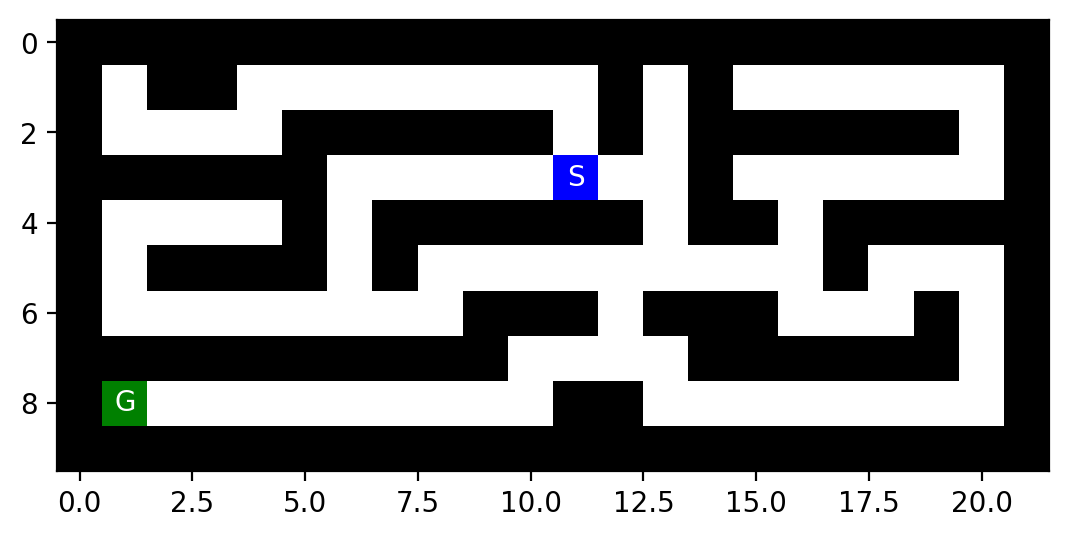

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [ ]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

In [ ]:
def find_pos(maze, what = "S"):
  pos = np.where(maze == what)
  return ([pos[0][0], pos[1][0]])





def show_path(maze, path, reached =[]):
  maze_viz = np.copy(maze)
  for pos in path:
    if maze_viz[pos[0], pos[1]] == " ":
       maze_viz[pos[0], pos[1]] = "P"
  for pos in reached:
    if maze_viz[pos[0], pos[1]] == " ":
       maze_viz[pos[0], pos[1]] = "."
  mh.show_maze(maze_viz)

def look(maze, pos):
  return (maze[pos[0], pos[1]])

def manhattan(pos1, pos2):
  return(np.sum(np.abs(np.subtract(pos1,pos2))))

def euclidean(pos1, pos2):
  return (np.sqrt(np.sum(np.square(np.subtract(pos1, pos2)))))

def min_index(x):
  return(np.random.choice(np.where(x == np.amin(x))[0]))


def available_directions(maze, pos):
      global positions
      positions = np.add(pos, [[-1,0], [0,1], [1,0], [0,-1]])
      np.random.shuffle(positions)
      return([new_pos.tolist() for new_pos in positions if look(maze, new_pos) !="X"])

def get_path(node):
    path = []
    # Start by adding the current node's data
    path.append(node.data)
    # Traverse up to the root node
    while not node.isRoot():
        node = node.getParent()
        path.append(node.data)
    # Reverse the path once after constructing it
    path.reverse()
    return path


def g(n):
  return(len(get_path(n))-1)

def get_parent(child):
  if child != (start_pos):
     return child.getParent()
  elif child == (start_pos):
    print("Major Parent")

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

Initial state: Starting state which is the point that our agent starts to navigate the maze
Actions: Moving North, South, East, and West
Transition model: The ideal transition model can be achieved when we define intersections as
states which means one transition is equal to go from one intersection(state) to another intersection but for this assignment I have assigned every empty square as a state which means moving from one square of the maze to another square of the maze is defined as the transition.
Goal state: final state which is point that our agent stops to navigate the maze and if the agent reaches this state, the maze is succesfully done.
Path cost: Every single action would cost one unit of energy which means if the agent passes two squres, it has consumed two units of energy



Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

𝑛: State Space Size
The state space size represents the total number of unique states (positions) the agent can be in within the maze. In the context of a maze, a state typically corresponds to a cell or square in the maze. Thus, the state space size (𝑛) can be estimated by counting the number of accessible cells in the maze. This includes all cells the agent can move into, excluding walls and other barriers. If the maze is represented as a grid, 𝑛 would be the number of cells minus the number of cells occupied by walls.

𝑑: Depth of the Optimal Solution
The depth of the optimal solution (𝑑) refers to the number of moves or actions required to reach the goal from the start position in the best case. Estimating 𝑑 requires knowledge of the maze's layout and the start and goal positions. In simple cases, this might be visually apparent or require running a search algorithm to determine the shortest path length. Note that 𝑑 depends on the particular start and goal configuration and the maze's structure.

𝑚: Maximum Depth of the Tree
The maximum depth of the tree (𝑚) represents the farthest the search algorithm could theoretically go without finding a solution. This is often a theoretical limit rather than a practical one, as searches are usually constrained by other factors (like memory or time limits). In the worst case, 𝑚 could be as large as the state space size 𝑛 if the maze allows for complex paths that visit every cell. However, 𝑚 is typically limited by the maze's design and the search algorithm's pruning strategies


𝑏: Maximum Branching Factor
The maximum branching factor (𝑏) represents the maximum number of actions (moves) available from any given state in the maze. In a simple grid-based maze where the agent can move up, down, left, or right, 𝑏 could be up to 4. However, the actual branching factor at a given position depends on the maze's walls and barriers; for example, a cell surrounded on three sides by walls has a branching factor of 1.


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, cycle checking abilities are limited.
You need to implement cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [ ]:
def TreeSearch (maze, strategy = "BFS", debug = False,limit=None, vis = False):
  global start_pos
  start_pos = find_pos(maze, "S")
  goal_pos = find_pos(maze, "G")
  if vis: maze_vis = np.copy(maze)
  root = Tree(data = start_pos)
  frontier = list()
  frontier.append(root)
  global reached
  reached = dict()
  reached[tuple(root.data)] = root
  if look(maze, root.data) == "G":
    return ({"path": get_path(node), "reached": reached.keys() })
  global depth, depth_IDS, pos_intersection, depth_Intersections,max_frontier,max_depth

  depth = list()
  depth_IDS = list()
  pos_intersection = list()
  depth_Intersections = list()
  max_frontier = list()
  max_depth = 20
  node = root
  weight_A = abs(np.random.normal(0,1))

  while not len(frontier) < 1:
    max_frontier.append(len(frontier))
    if debug: print("Frontier:", [n.data for n in frontier])
    if strategy == "BFS":
      node = frontier.pop(0)
    elif strategy == "A*-M":
      f = [g(n) + manhattan(n.data, goal_pos) for n in frontier]
      if debug: print("f(n)", f)
      node = frontier.pop(min_index(f))
    elif strategy == "A*-M-weighted":
      f = [g(n) + weight_A*(manhattan(n.data, goal_pos)) for n in frontier]
      if debug: print("f(n)", f)
      node = frontier.pop(min_index(f))
    elif strategy == "A*-E-weighted":
      f = [g(n) + weight_A*(euclidean(n.data, goal_pos)) for n in frontier]
      if debug : print ("f(n)", f)
      node = frontier.pop(min_index(f))
    elif strategy == "A*-E":
      f = [g(n) + euclidean(n.data, goal_pos) for n in frontier]
      if debug : print ("f(n)", f)
      node = frontier.pop(min_index(f))
    elif strategy == "DFS":
      node = frontier.pop(-1)
    elif strategy == "IDS":
      node = frontier.pop(-1)
    elif strategy == "GBFS-M":
      h = [manhattan(n.data, goal_pos) for n in frontier]
      if debug: print("h(n)", h)
      node = frontier.pop(min_index(h))
    elif strategy == "GBFS-E":
      h = [euclidean(n.data, goal_pos) for n in frontier]
      if debug: print("h(n)", h)
      node = frontier.pop(min_index(h))

    else:
      print("Not Listed Name for Strategy")
      return(None)


    if look(maze, node.data) == "G":
      return ({"path": get_path(node), "reached": reached.keys()})
    if debug: print("Expanding", node.data)

    if (limit!=None and len(get_path(node))>limit):
     if debug:print(f"Depth limit reached for {node.data}")

    depth.append(len(get_path(node)))

    for pos in available_directions(maze, node.data):
      if len(available_directions(maze, node.data)) > 2:
         pos_intersection.append(node)
         depth_Intersections.append(len(get_path(node)))

      if strategy in ["DFS", "GBFS-M", "GBFS-E"]:
        if tuple(pos) in reached.keys():
          if g(reached[tuple(pos)]) <= g(node) + 1: continue
      elif tuple(pos) in reached.keys(): continue

      n = Tree(data = pos)
      node.addChild(n)
      frontier.append(n)
      reached[tuple(pos)] = n
      if vis: maze_vis[pos[0], pos[1]] = "."
  if debug: print("Adding to frontier:", [n.data for n in node.getChildren()])
  if vis:
    # Check if the current node's position in the maze has not been visited (marked as ".")
    if maze_vis[node.data[0], node.data[1]] == ".":
        # Mark the node as visited by changing its value
        maze_vis[node.data[0], node.data[1]] = "X"  # Assuming "X" marks visited

    # Display the maze with the current visualization
    mh.show_maze(maze_vis)

    return(None)




def Itterative_DS(maze,max_limit=np.inf,debug=False,vis=False):
  reached=[]
  limit=1
  while True:
    result=TreeSearch(maze, strategy = "DFS",limit=limit, debug = debug, vis = vis)
    result["limit"]=limit
    reached=list(set().union(reached,result["reached"]))
    result["reached"]=reached
    if(result["path"]!=None):break
    if(limit>max_limit):return(result)
    limit+=1

  if debug:print(f"Solution is found in ={limit}")
  return(result)



  f1 = np.zeros(len(result["reached"]))
  f2 = np.zeros(len(result["reached"]))
  a = (list(result["reached"]))
  for i in range(len(result["reached"])):
        f1[i] = int(a[i][0])
        f2[i] = int(a[i][1])

  step = np.zeros(len(f1))
  for i in range(len(f1)):
    while reached[(f1[i], f2[i])] != None:
      reached[(f1[i], f2[i])] = get_parent(reached[(f1[i], f2[i])])
    step[i] = (step[i] + 1)

 
Algorithm Name: BFS
Type of Maze: medium_maze.txt


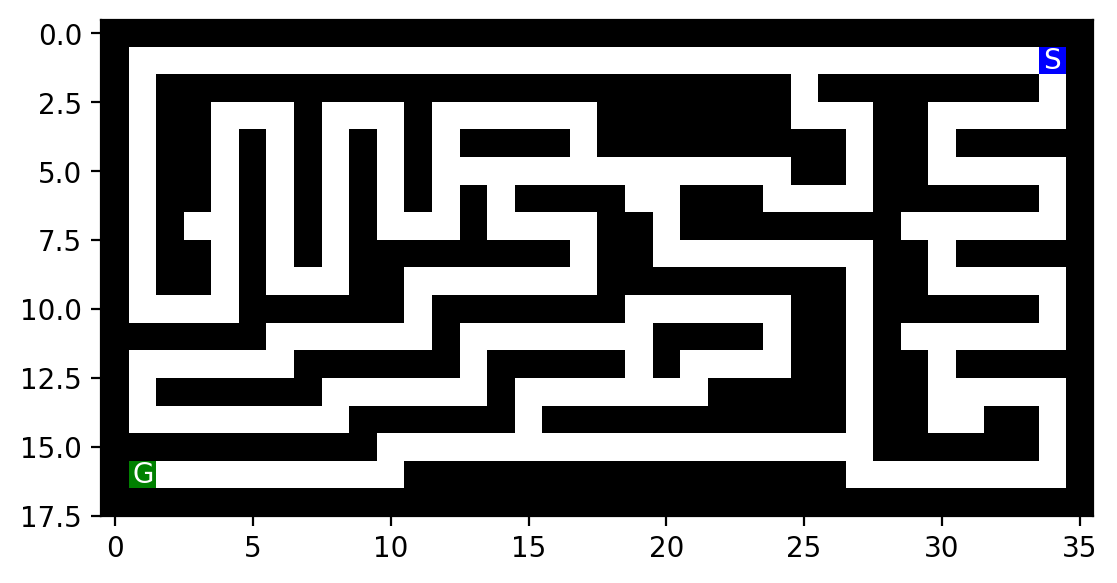

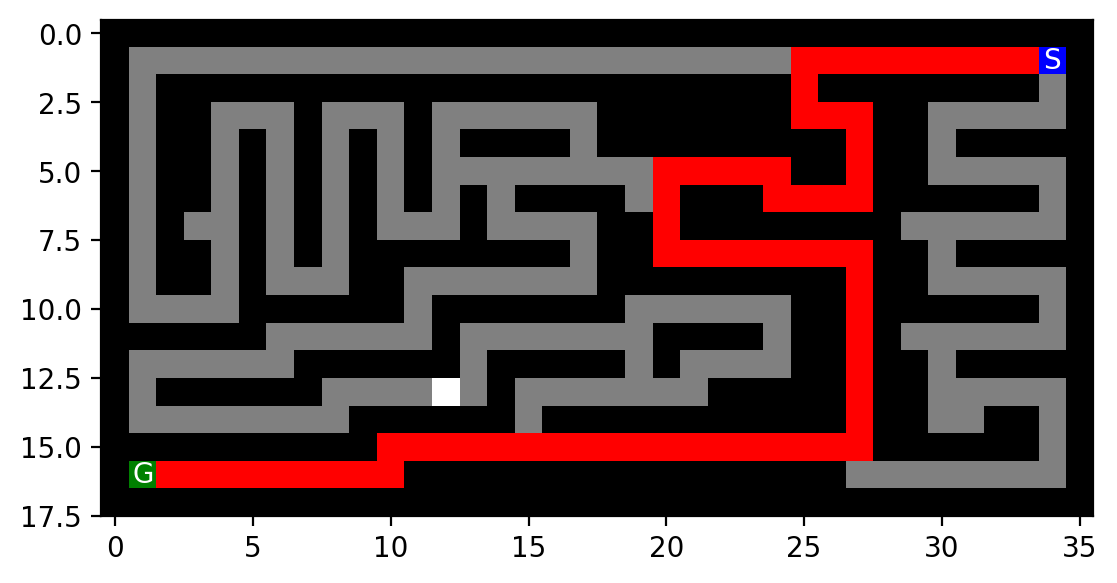

Path cost: 68
Number of nodes expanded: 273
Maximum size of the frontier: 8
Maximum Tree Depth: 69
Maximum Number of Node in Memory: 342
this is File medium_maze.txt
 
Algorithm Name: BFS
Type of Maze: small_maze.txt


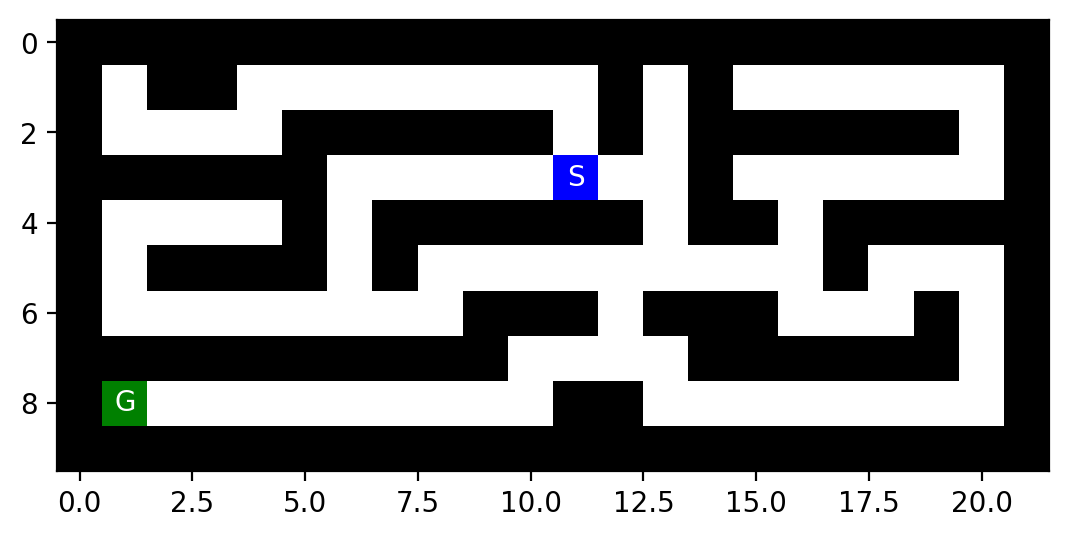

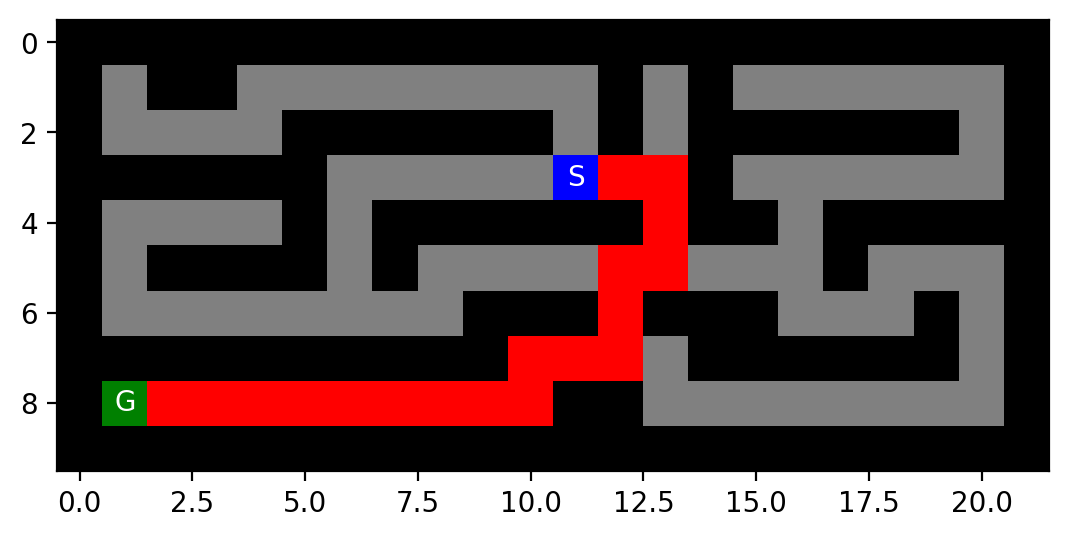

Path cost: 19
Number of nodes expanded: 94
Maximum size of the frontier: 9
Maximum Tree Depth: 20
Maximum Number of Node in Memory: 114
this is File small_maze.txt
 
Algorithm Name: BFS
Type of Maze: empty_maze.txt


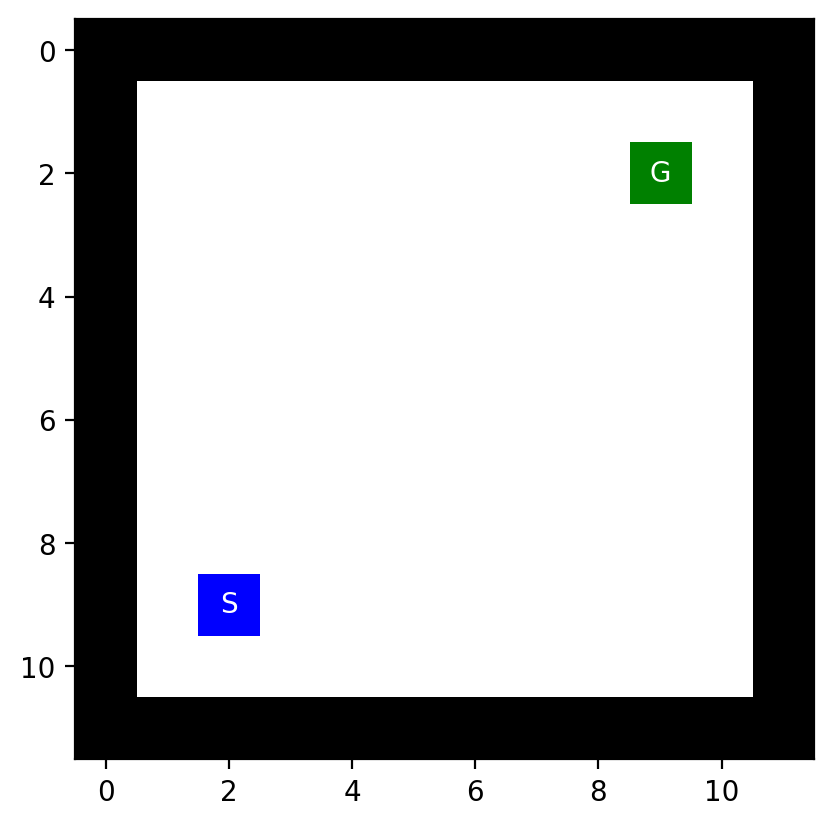

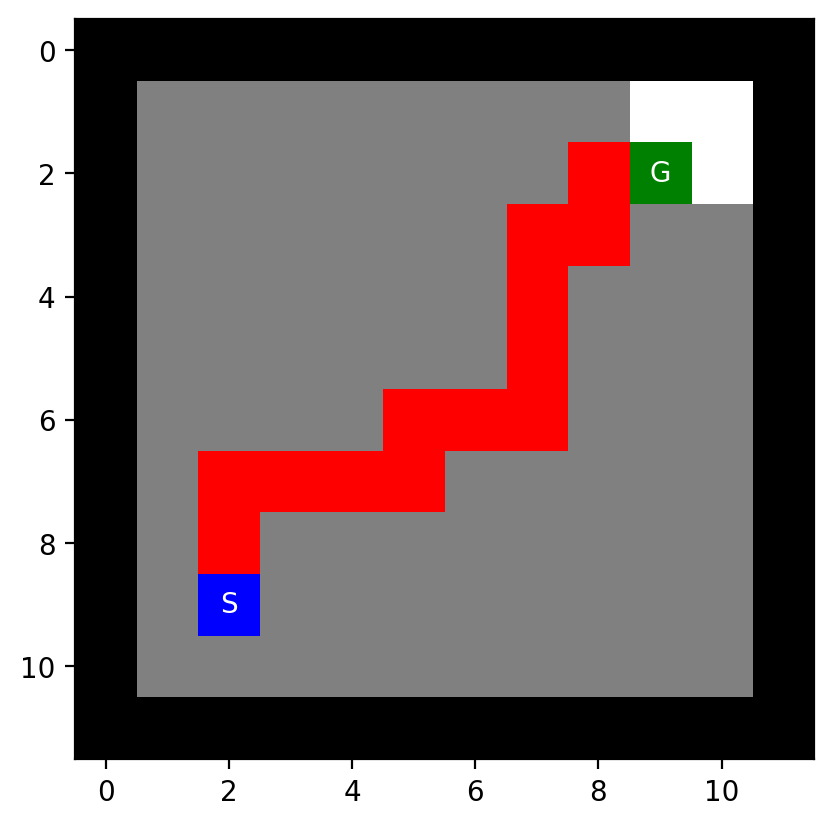

Path cost: 14
Number of nodes expanded: 97
Maximum size of the frontier: 12
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 112
this is File empty_maze.txt
 
Algorithm Name: BFS
Type of Maze: empty_2_maze.txt


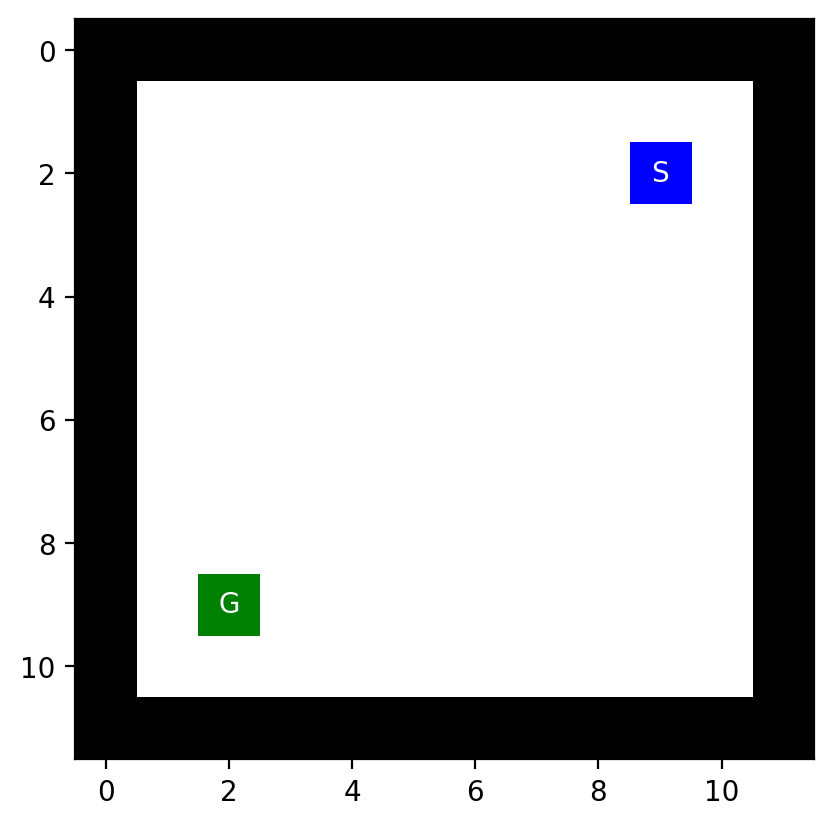

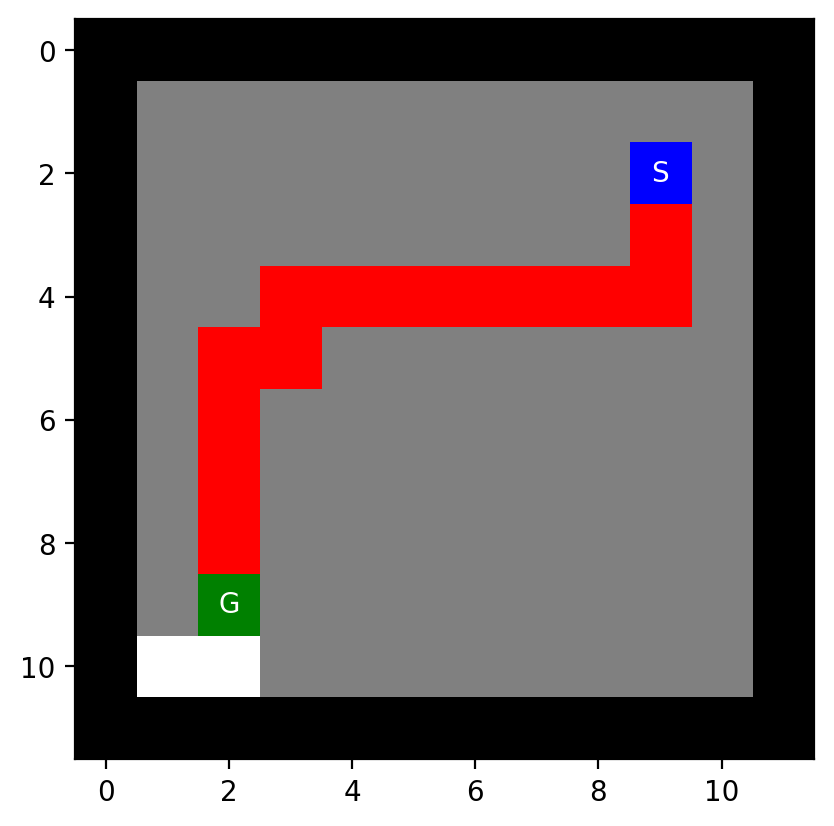

Path cost: 14
Number of nodes expanded: 98
Maximum size of the frontier: 12
Maximum Tree Depth: 15
Maximum Number of Node in Memory: 113
this is File empty_2_maze.txt
 
Algorithm Name: BFS
Type of Maze: wall_maze.txt


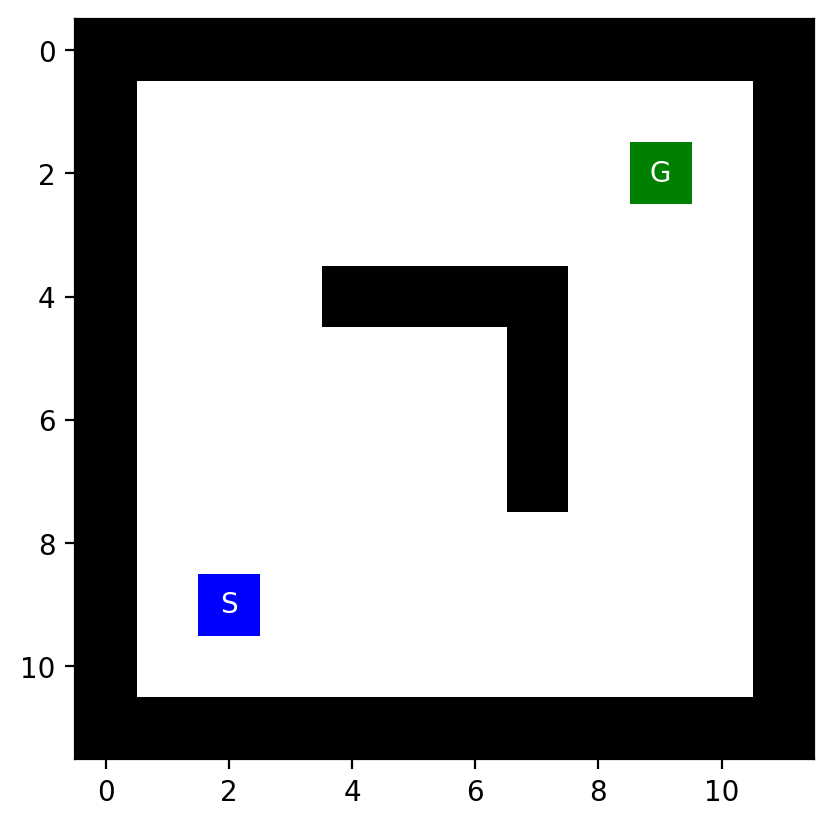

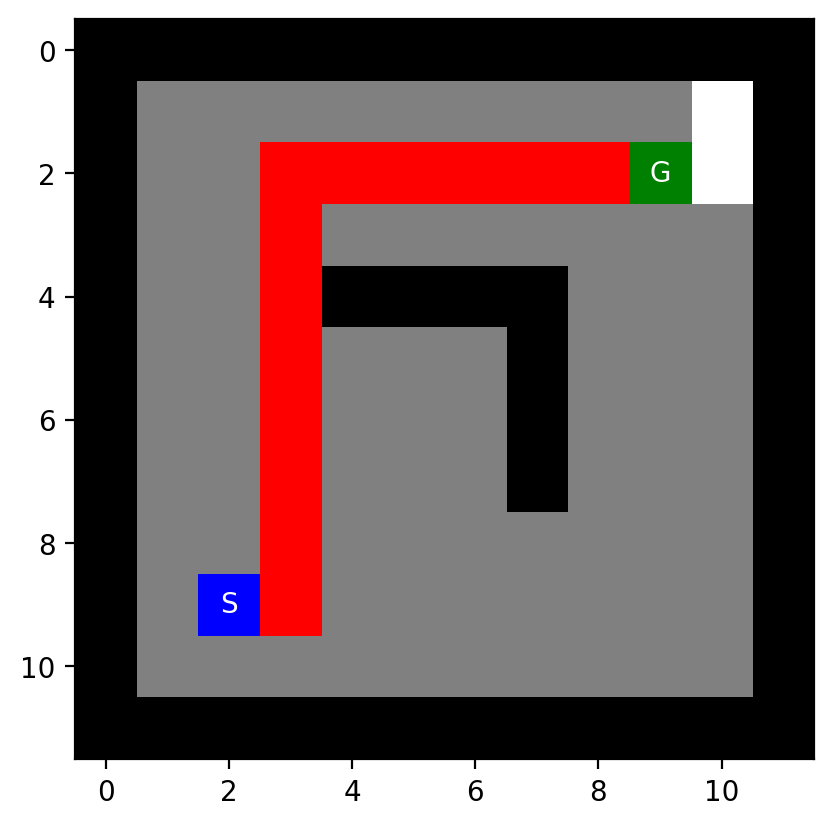

Path cost: 14
Number of nodes expanded: 91
Maximum size of the frontier: 10
Maximum Tree Depth: 15
Maximum Number of Node in Memory: 106
this is File wall_maze.txt
 
Algorithm Name: BFS
Type of Maze: open_maze.txt


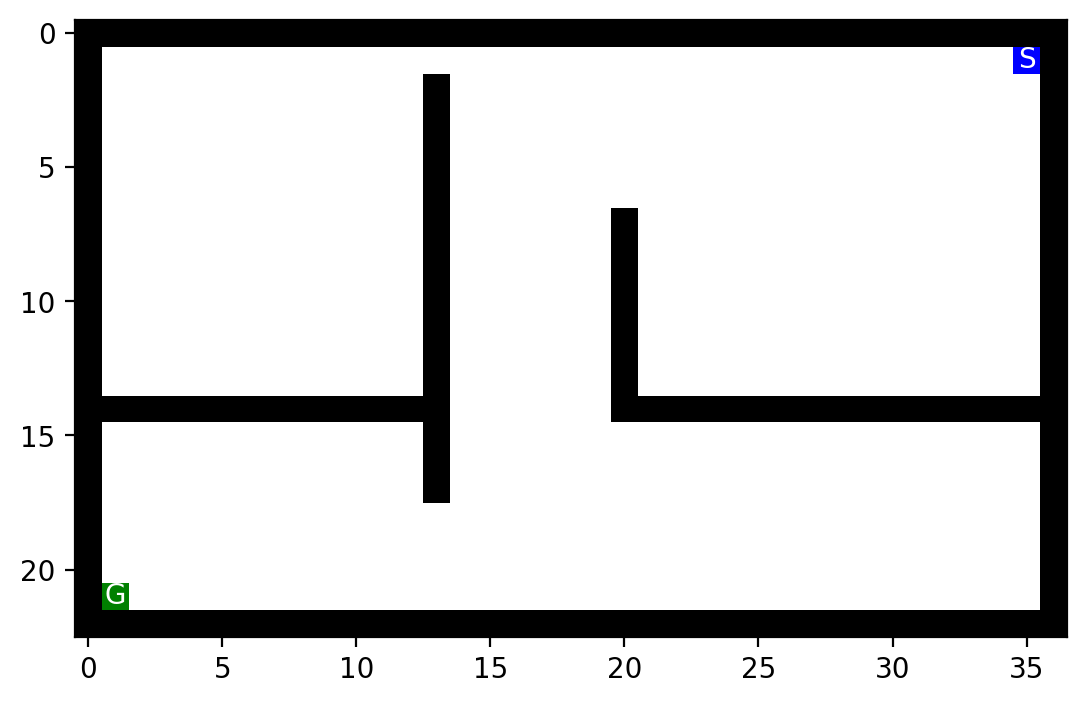

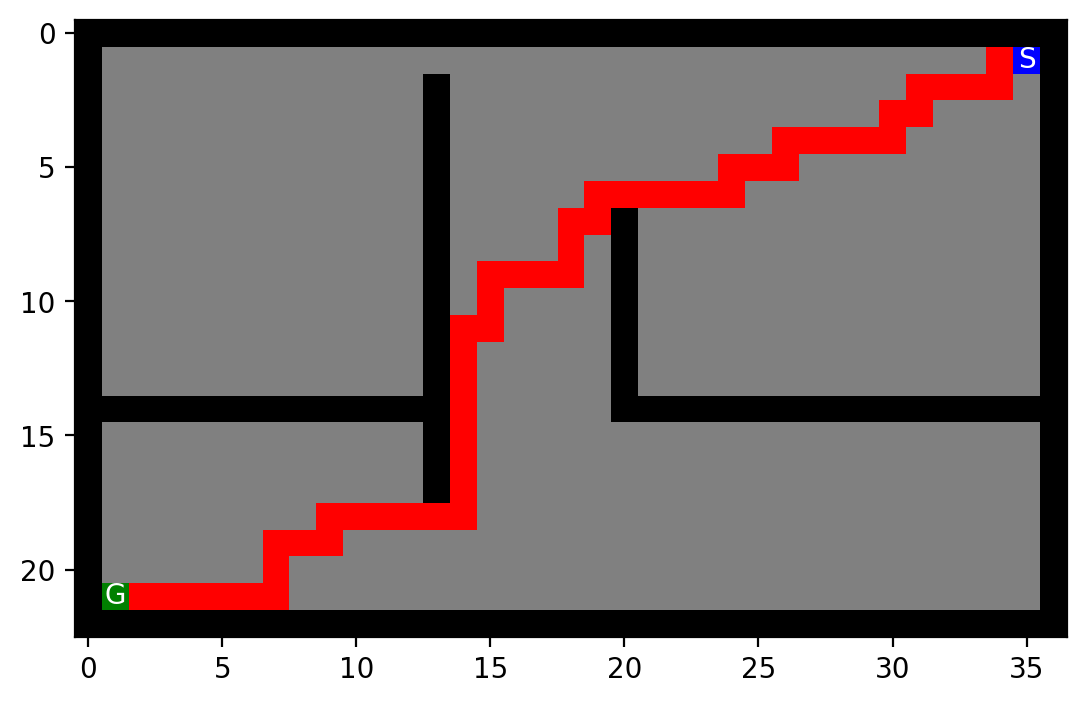

Path cost: 54
Number of nodes expanded: 684
Maximum size of the frontier: 25
Maximum Tree Depth: 55
Maximum Number of Node in Memory: 739
this is File open_maze.txt
 
Algorithm Name: BFS
Type of Maze: loops_maze.txt


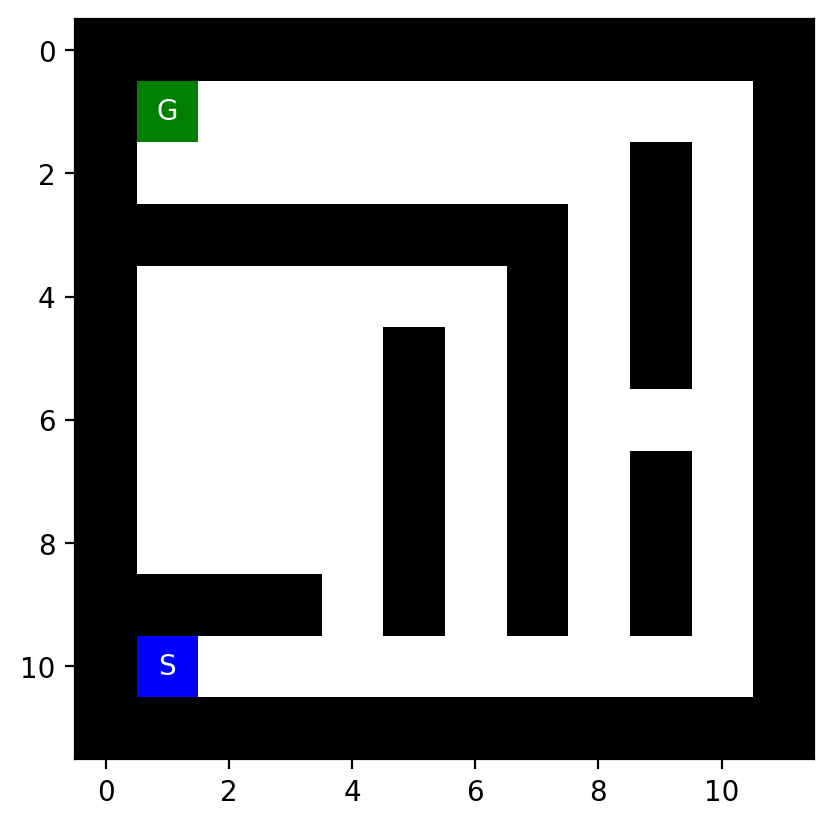

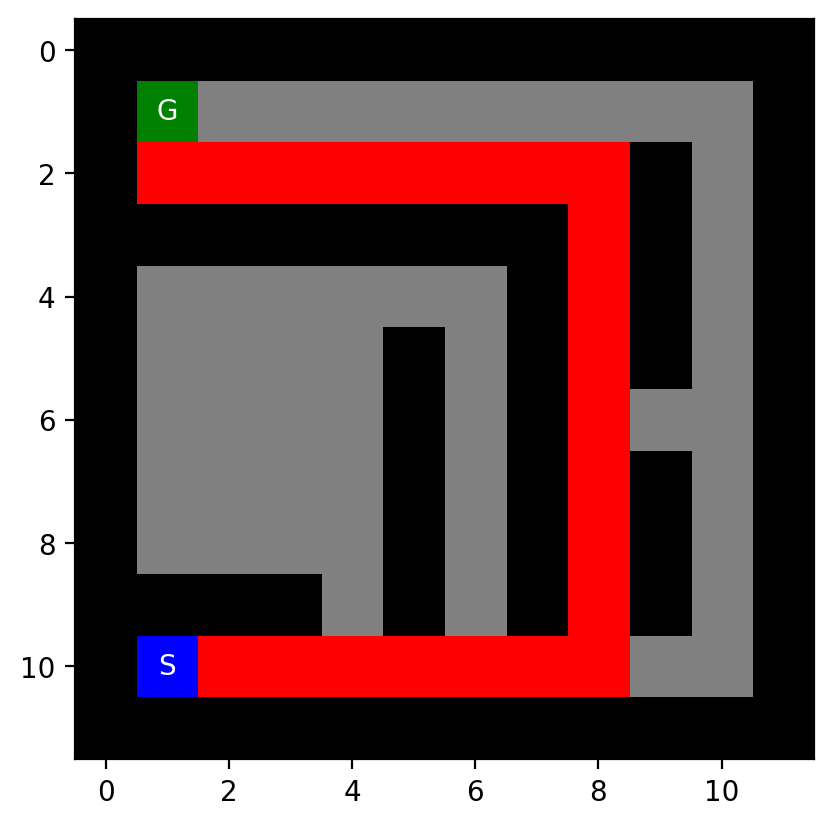

Path cost: 23
Number of nodes expanded: 72
Maximum size of the frontier: 8
Maximum Tree Depth: 23
Maximum Number of Node in Memory: 96
this is File loops_maze.txt
 
Algorithm Name: BFS
Type of Maze: large_maze.txt


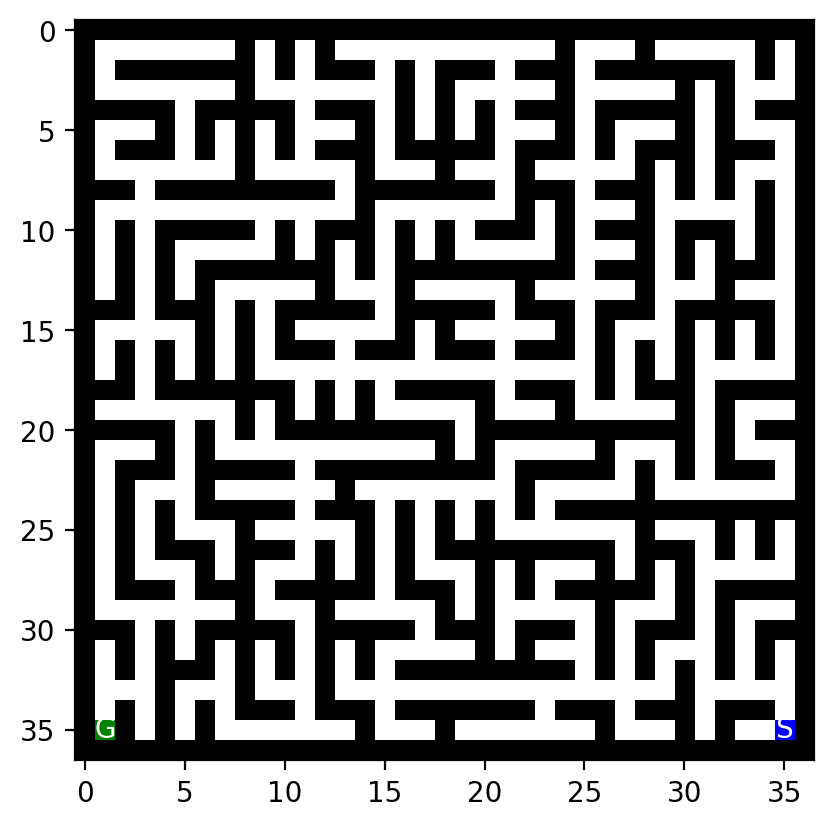

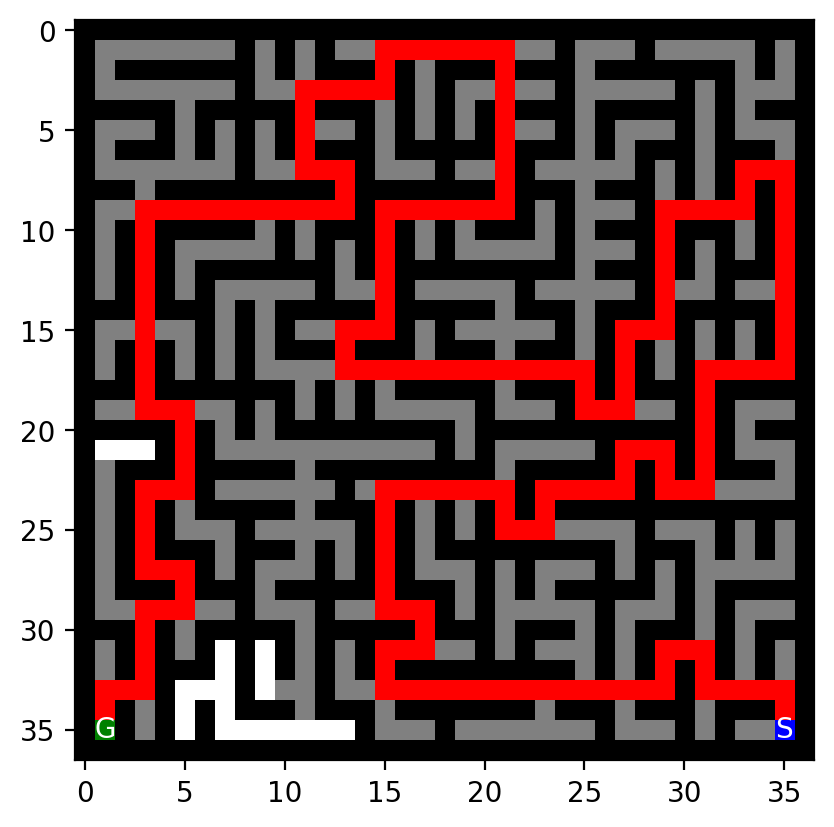

Path cost: 210
Number of nodes expanded: 626
Maximum size of the frontier: 9
Maximum Tree Depth: 211
Maximum Number of Node in Memory: 837
this is File large_maze.txt
 
Algorithm Name: DFS
Type of Maze: medium_maze.txt


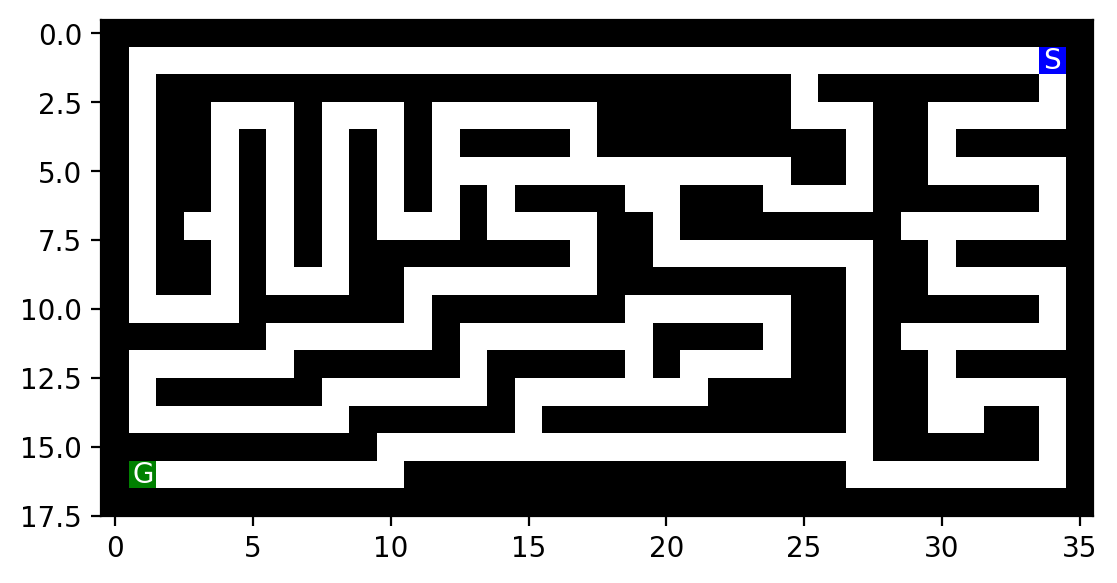

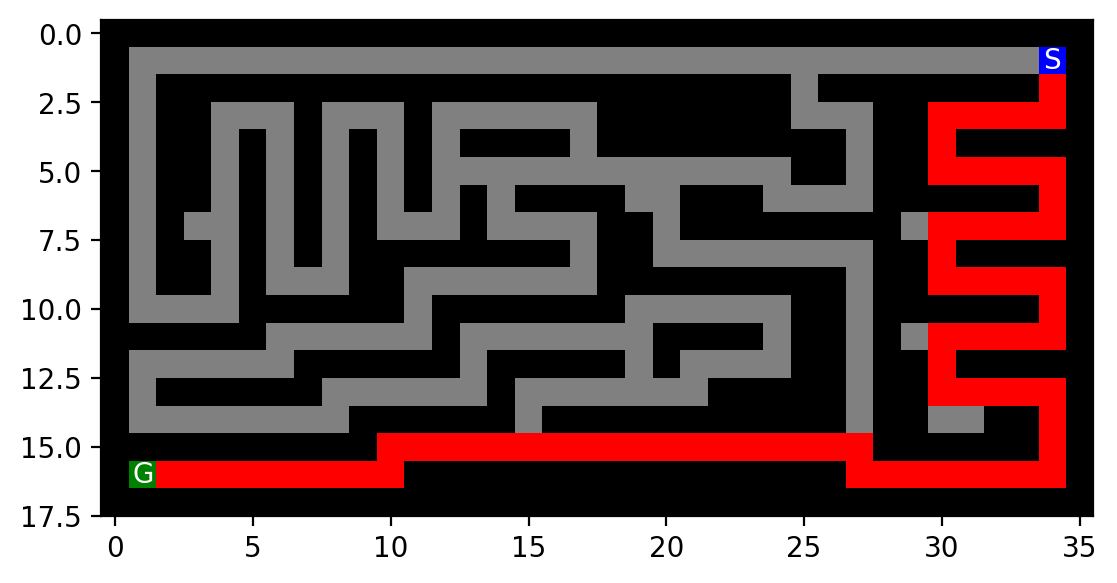

Path cost: 74
Number of nodes expanded: 274
Maximum size of the frontier: 11
Maximum Tree Depth: 214
Maximum Number of Node in Memory: 349
this is File medium_maze.txt
 
Algorithm Name: DFS
Type of Maze: small_maze.txt


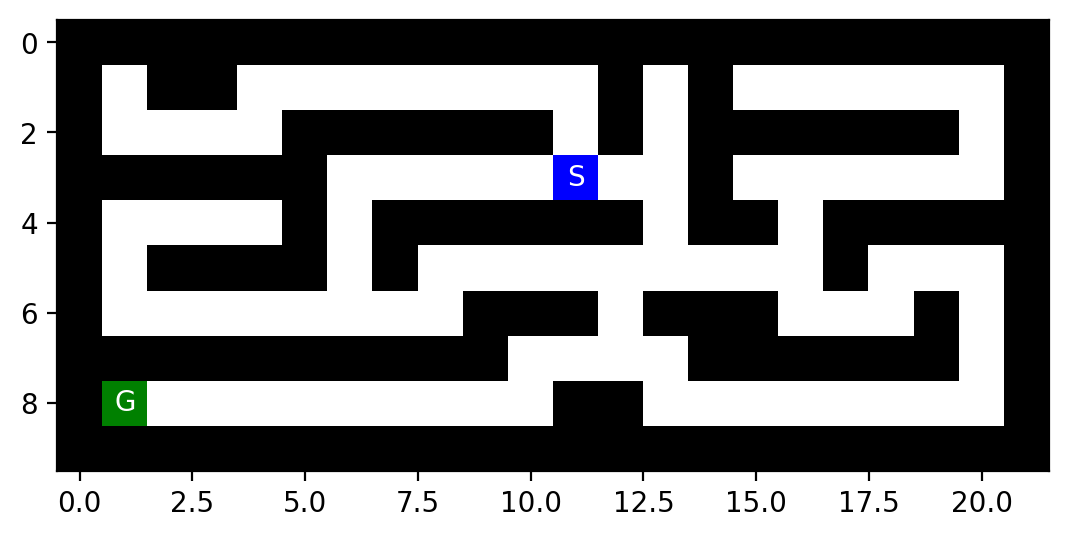

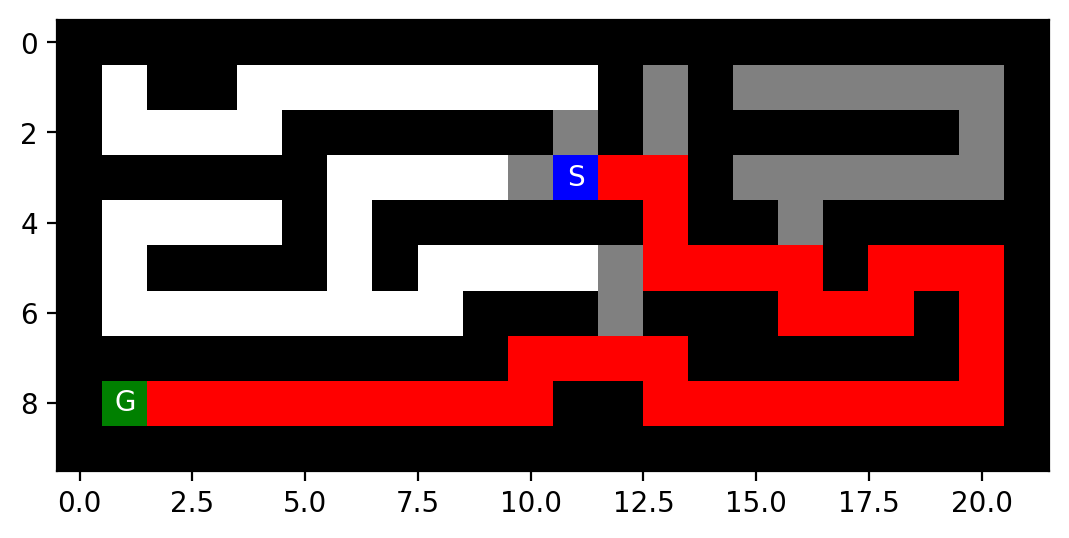

Path cost: 37
Number of nodes expanded: 58
Maximum size of the frontier: 6
Maximum Tree Depth: 37
Maximum Number of Node in Memory: 96
this is File small_maze.txt
 
Algorithm Name: DFS
Type of Maze: empty_maze.txt


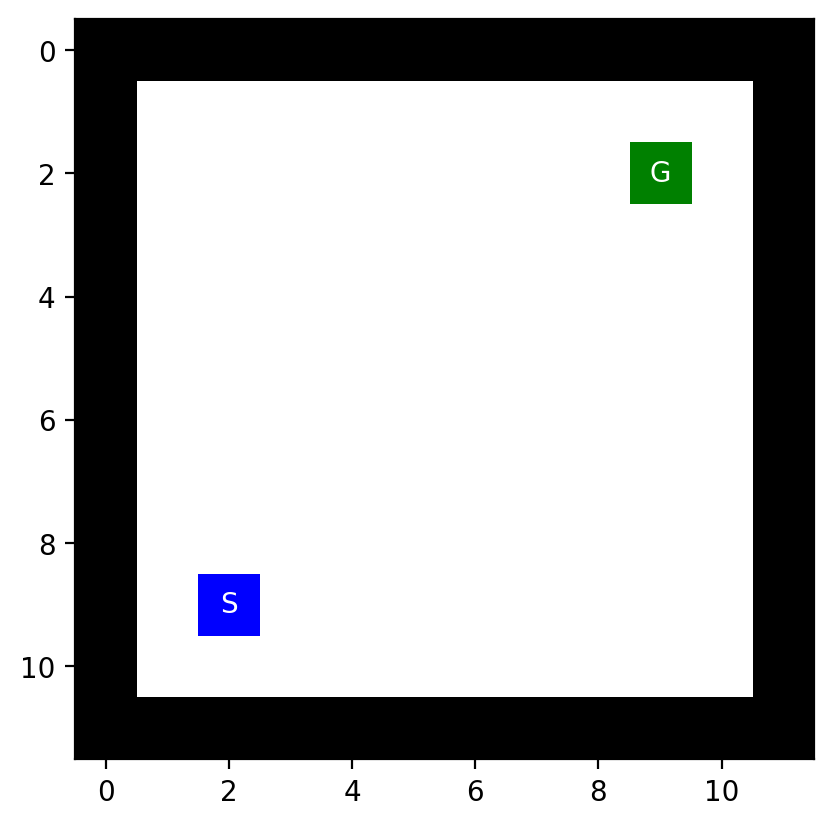

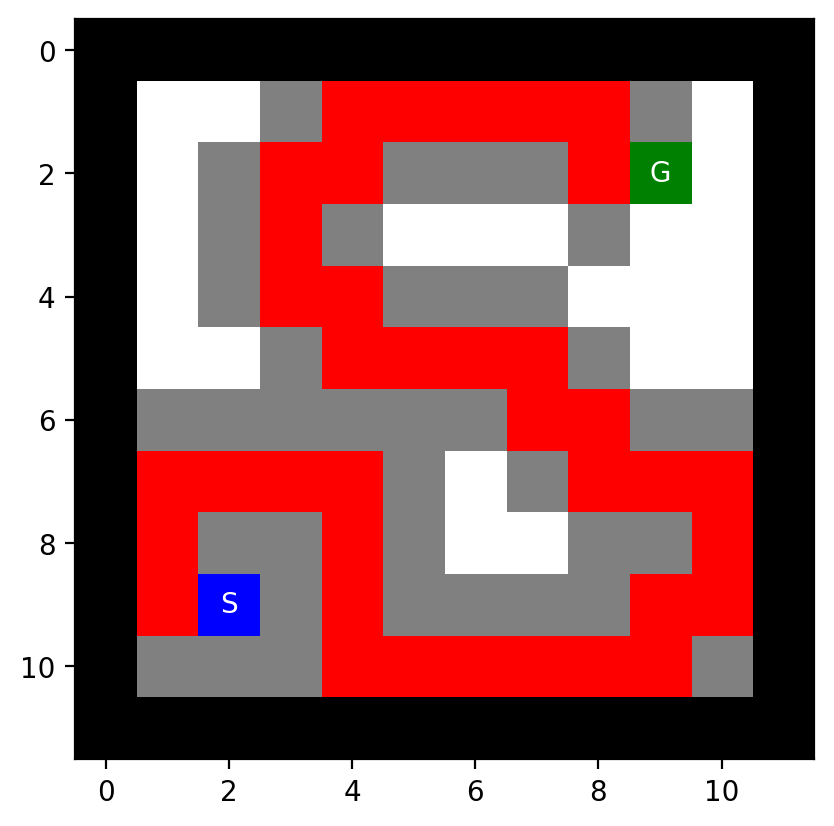

Path cost: 38
Number of nodes expanded: 78
Maximum size of the frontier: 38
Maximum Tree Depth: 38
Maximum Number of Node in Memory: 117
this is File empty_maze.txt
 
Algorithm Name: DFS
Type of Maze: empty_2_maze.txt


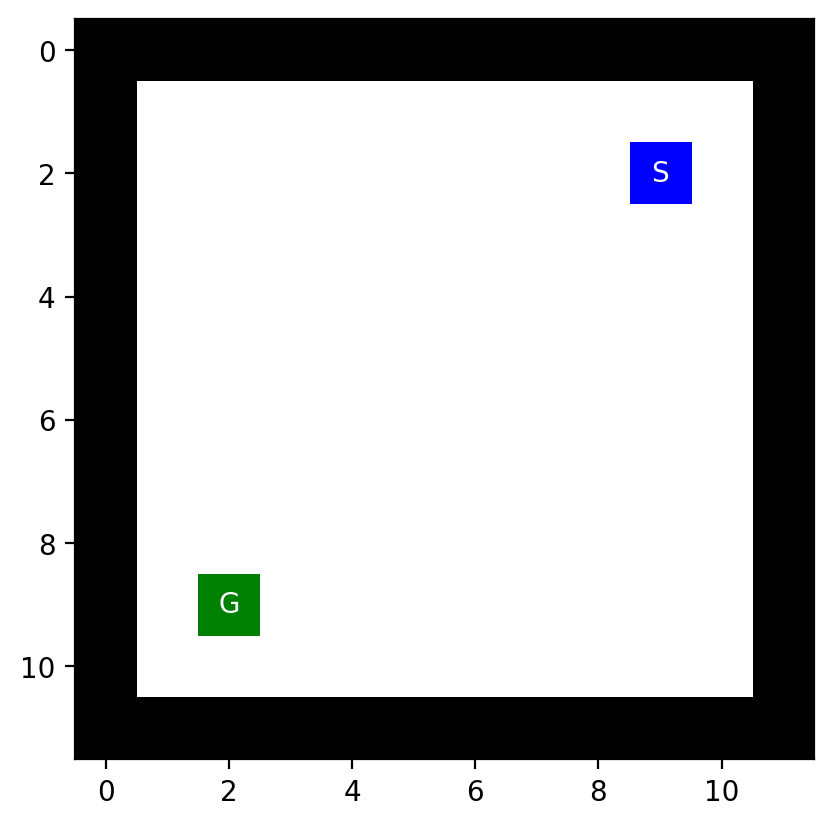

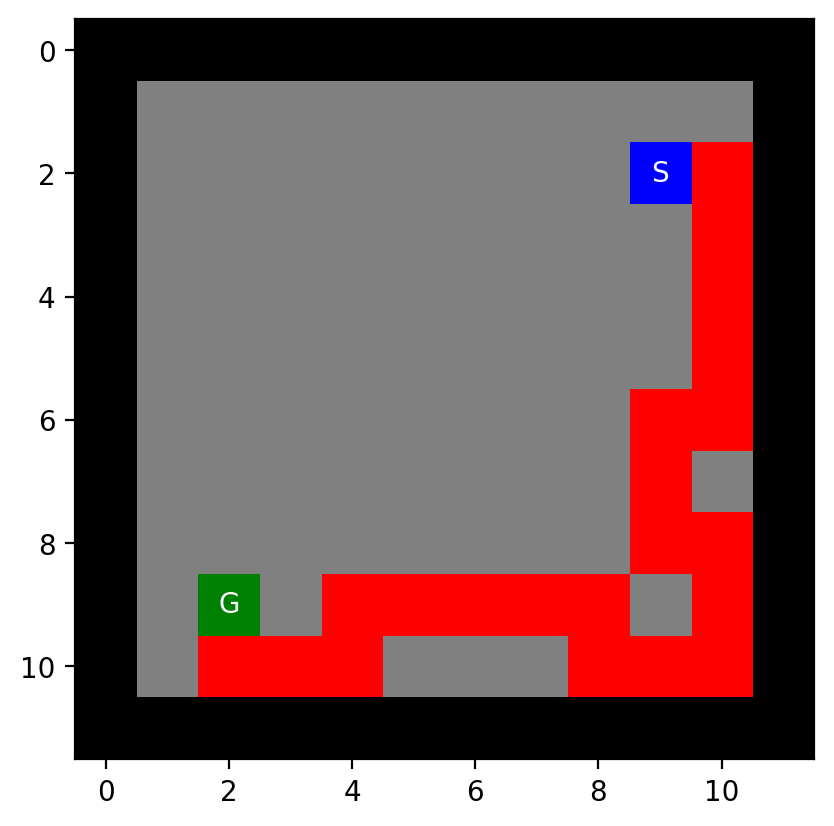

Path cost: 22
Number of nodes expanded: 100
Maximum size of the frontier: 39
Maximum Tree Depth: 49
Maximum Number of Node in Memory: 123
this is File empty_2_maze.txt
 
Algorithm Name: DFS
Type of Maze: wall_maze.txt


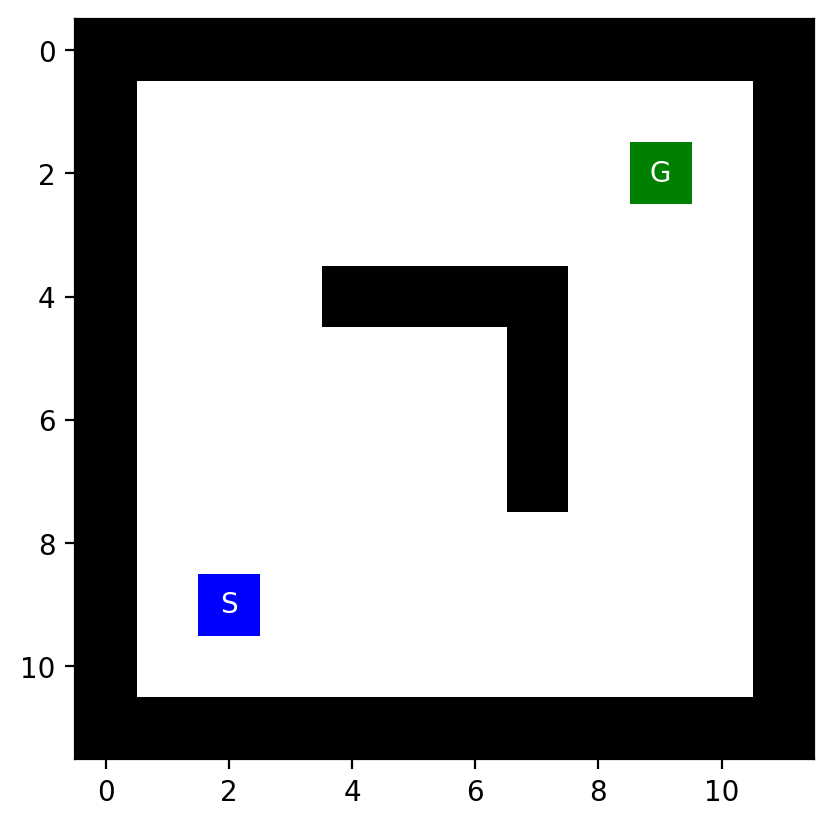

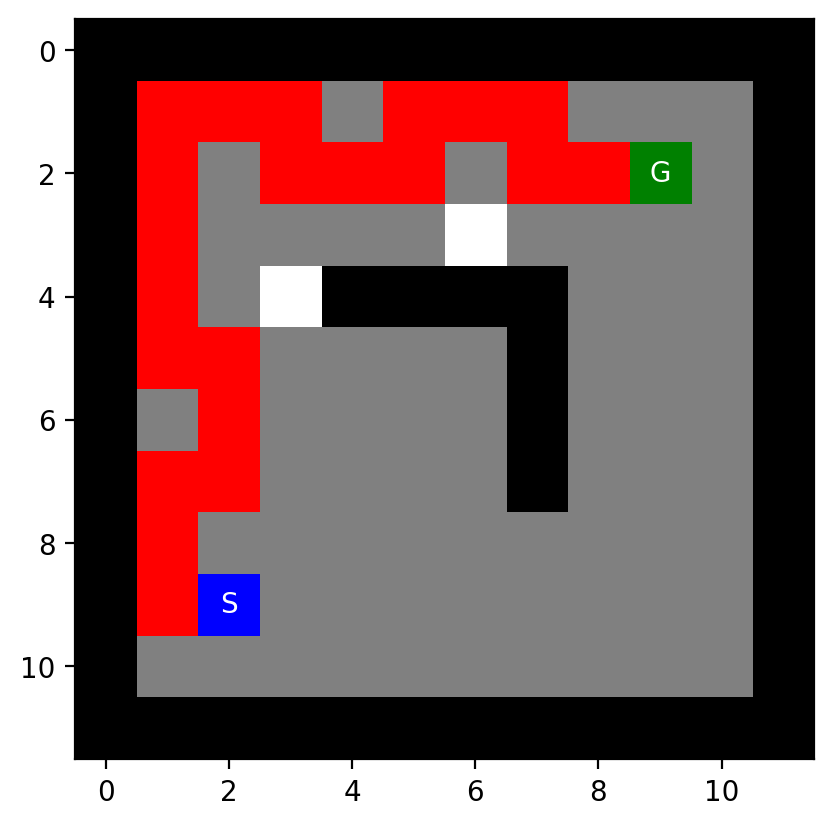

Path cost: 22
Number of nodes expanded: 91
Maximum size of the frontier: 35
Maximum Tree Depth: 43
Maximum Number of Node in Memory: 114
this is File wall_maze.txt
 
Algorithm Name: DFS
Type of Maze: open_maze.txt


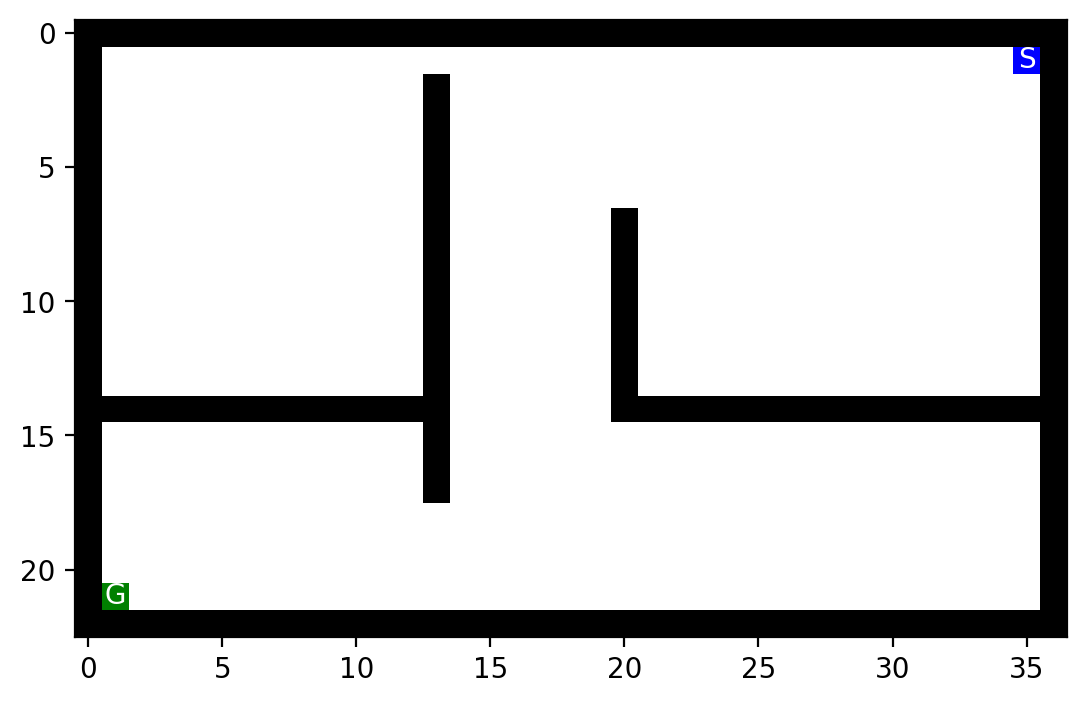

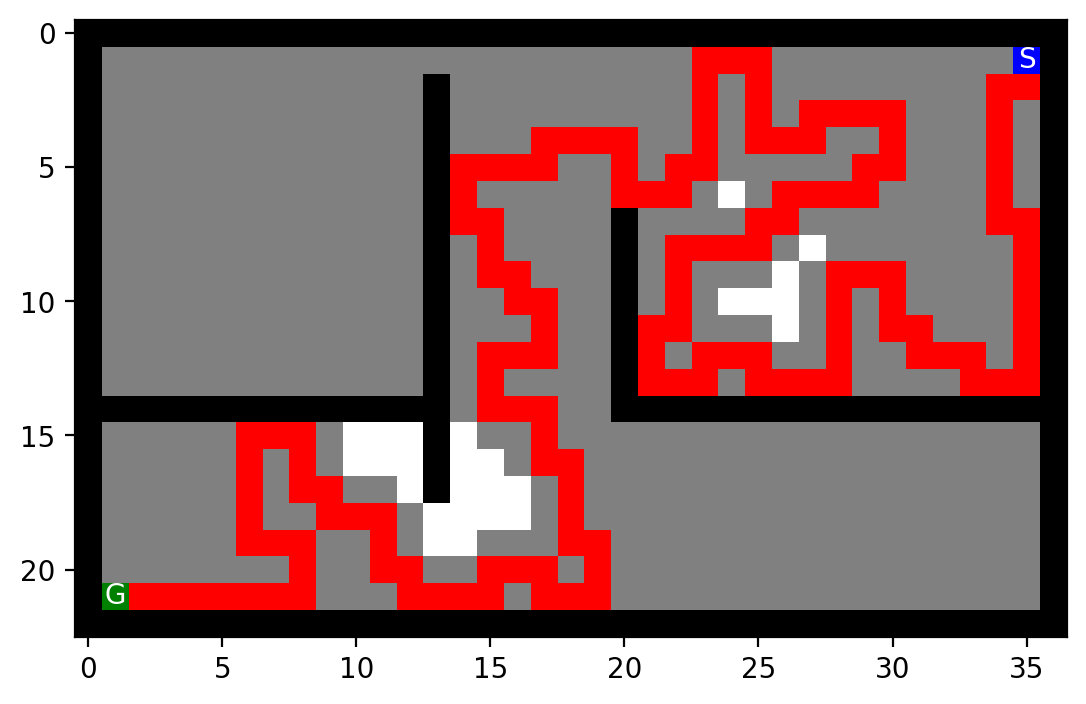

Path cost: 146
Number of nodes expanded: 658
Maximum size of the frontier: 162
Maximum Tree Depth: 159
Maximum Number of Node in Memory: 805
this is File open_maze.txt
 
Algorithm Name: DFS
Type of Maze: loops_maze.txt


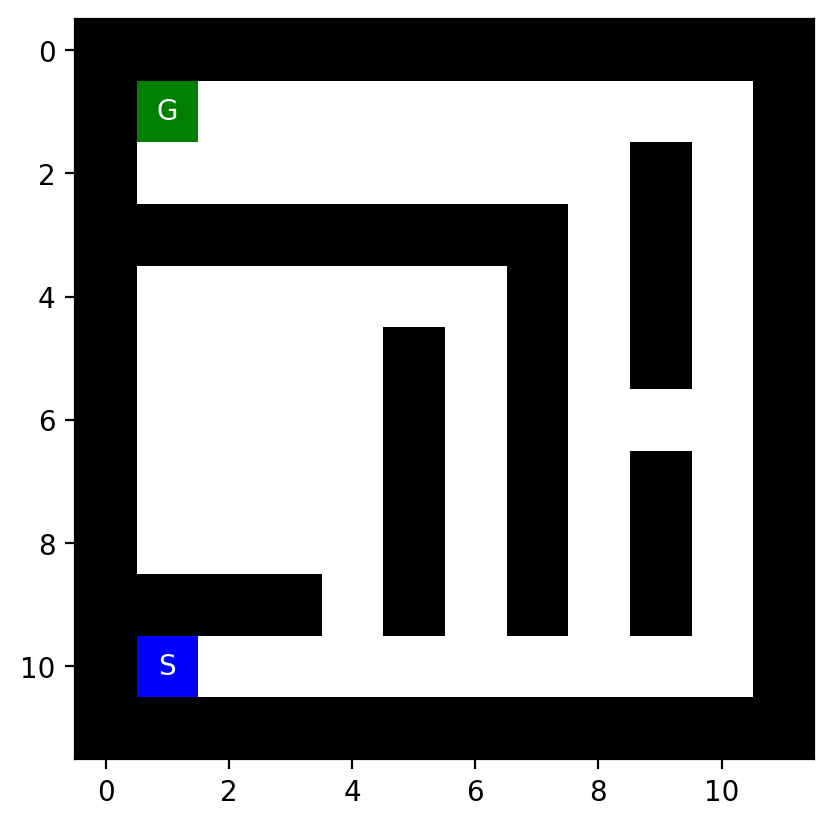

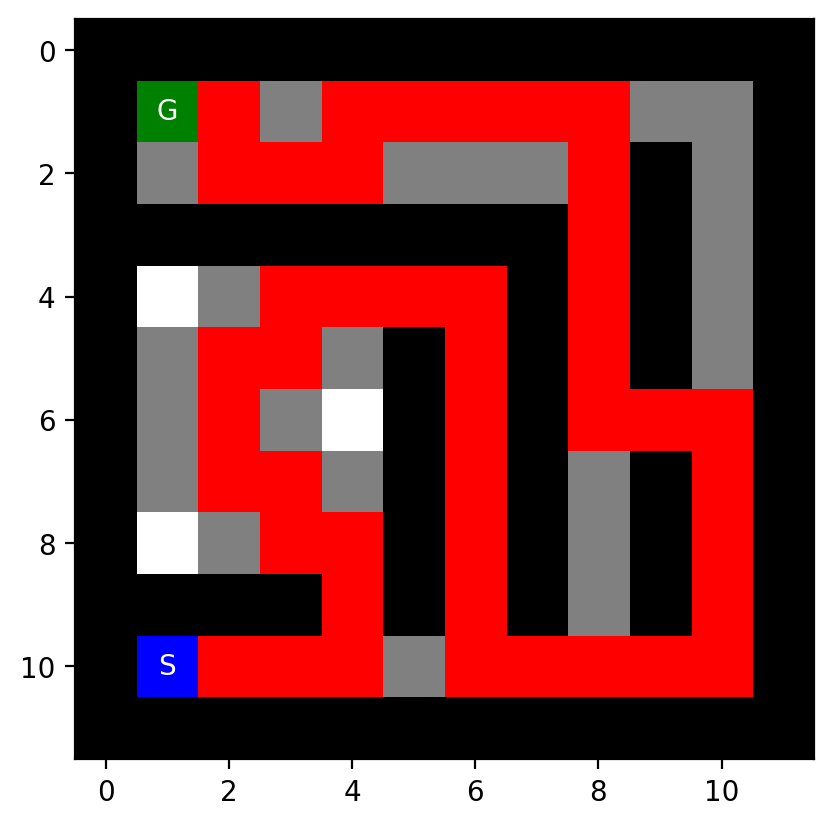

Path cost: 45
Number of nodes expanded: 69
Maximum size of the frontier: 17
Maximum Tree Depth: 45
Maximum Number of Node in Memory: 115
this is File loops_maze.txt
 
Algorithm Name: DFS
Type of Maze: large_maze.txt


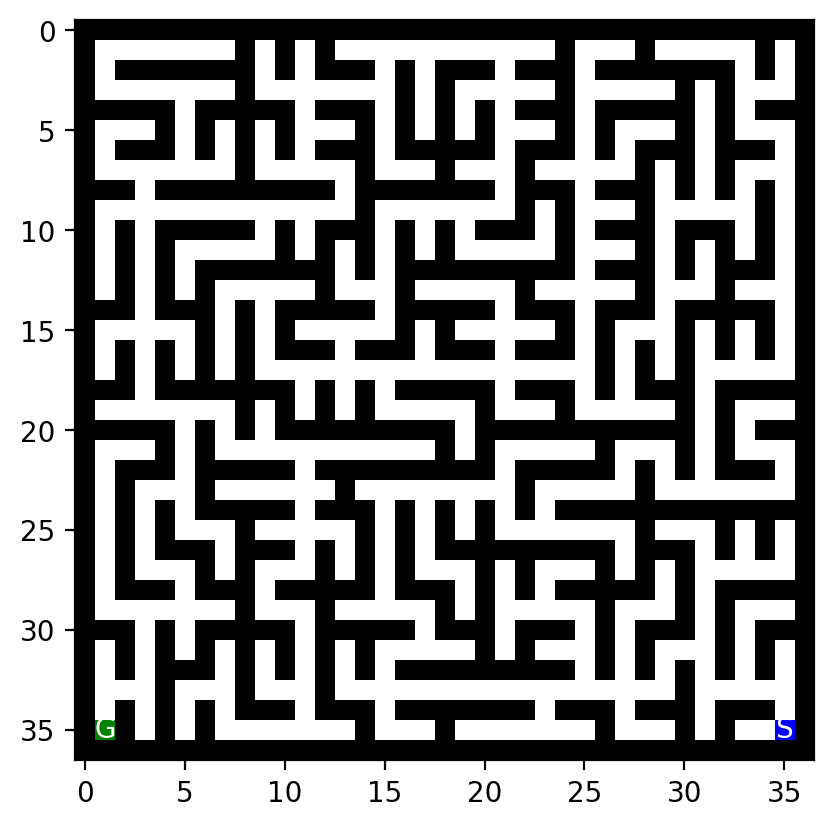

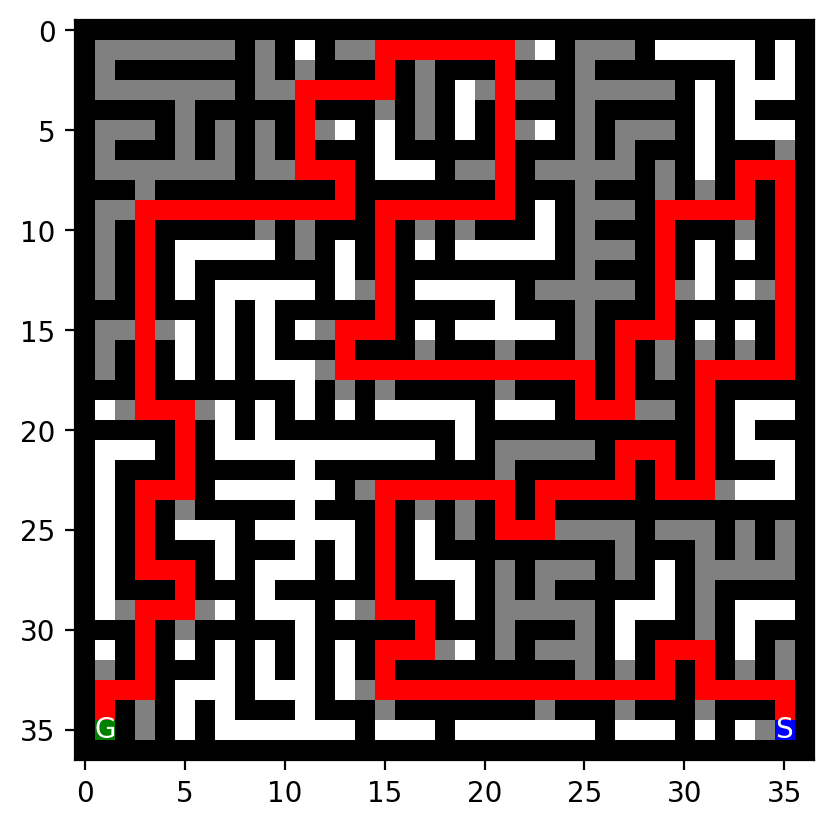

Path cost: 210
Number of nodes expanded: 414
Maximum size of the frontier: 46
Maximum Tree Depth: 210
Maximum Number of Node in Memory: 625
this is File large_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: medium_maze.txt


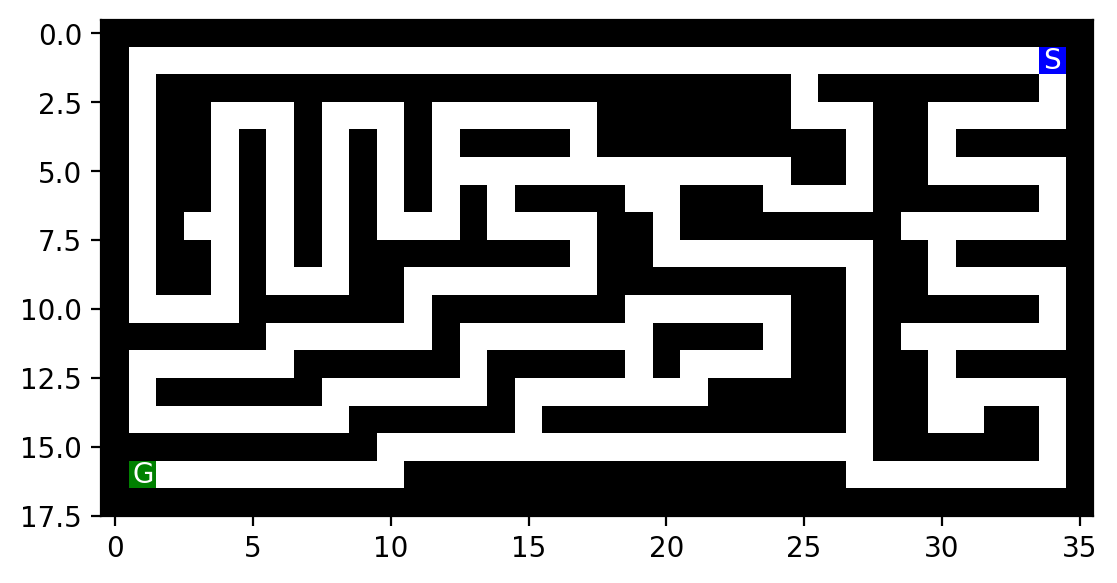

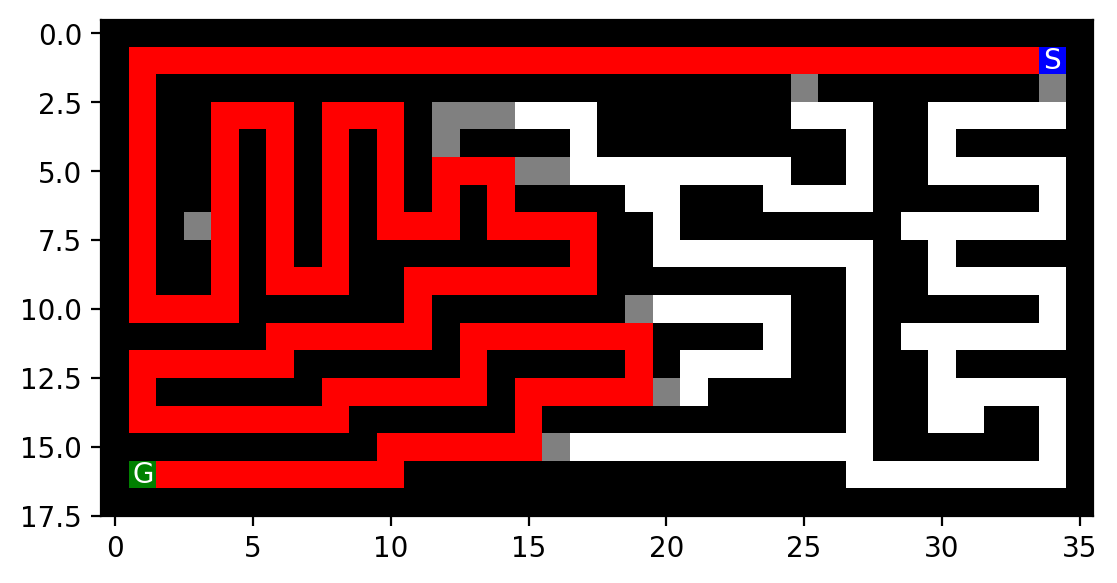

Path cost: 152
Number of nodes expanded: 165
Maximum size of the frontier: 8
Maximum Tree Depth: 152
Maximum Number of Node in Memory: 318
this is File medium_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: small_maze.txt


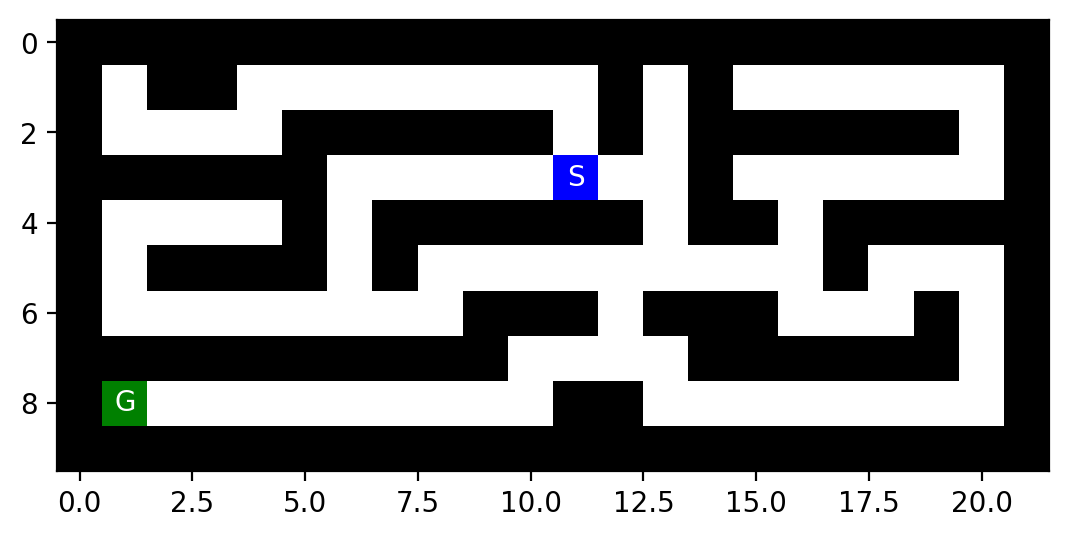

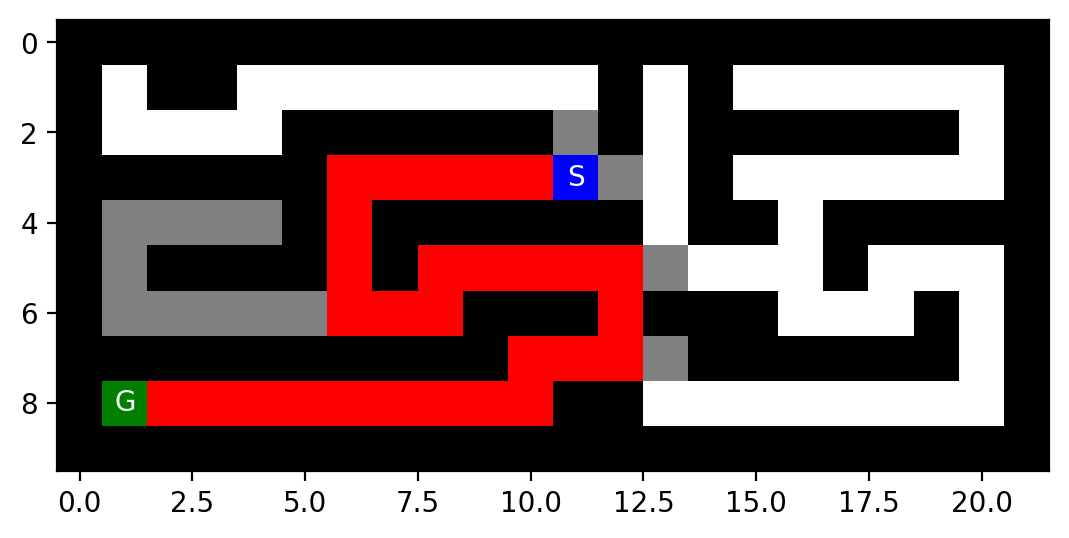

Path cost: 29
Number of nodes expanded: 44
Maximum size of the frontier: 5
Maximum Tree Depth: 29
Maximum Number of Node in Memory: 74
this is File small_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: empty_maze.txt


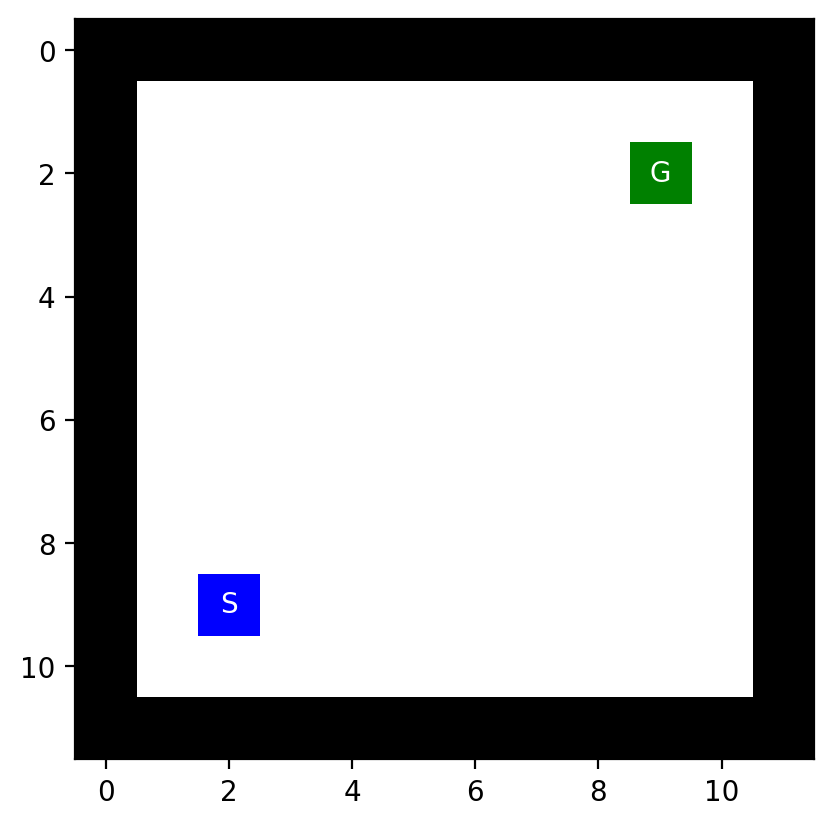

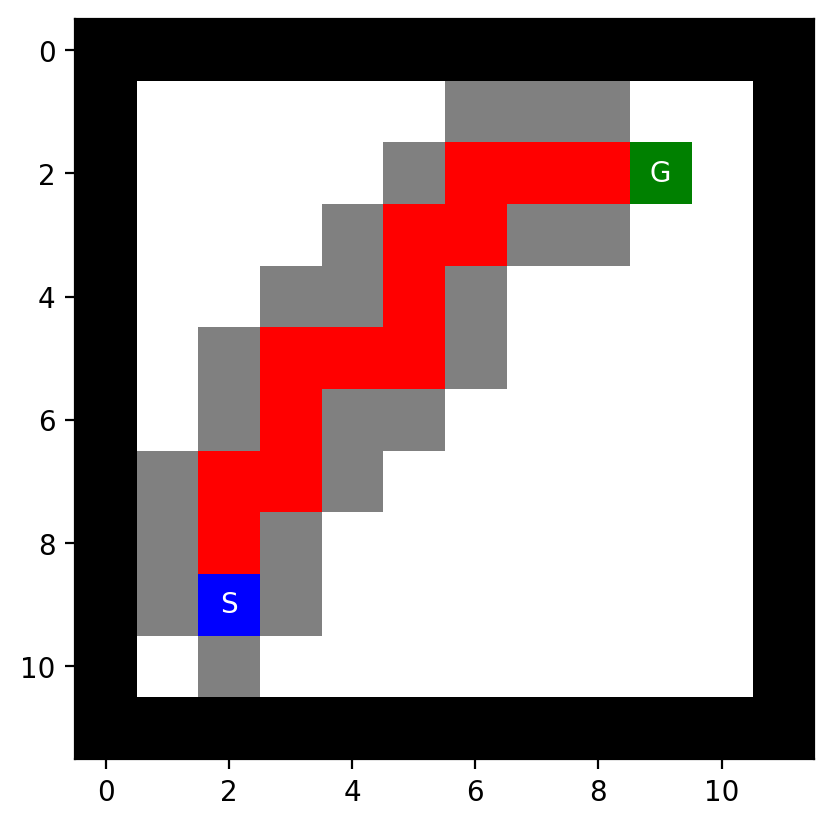

Path cost: 14
Number of nodes expanded: 37
Maximum size of the frontier: 23
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 52
this is File empty_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: empty_2_maze.txt


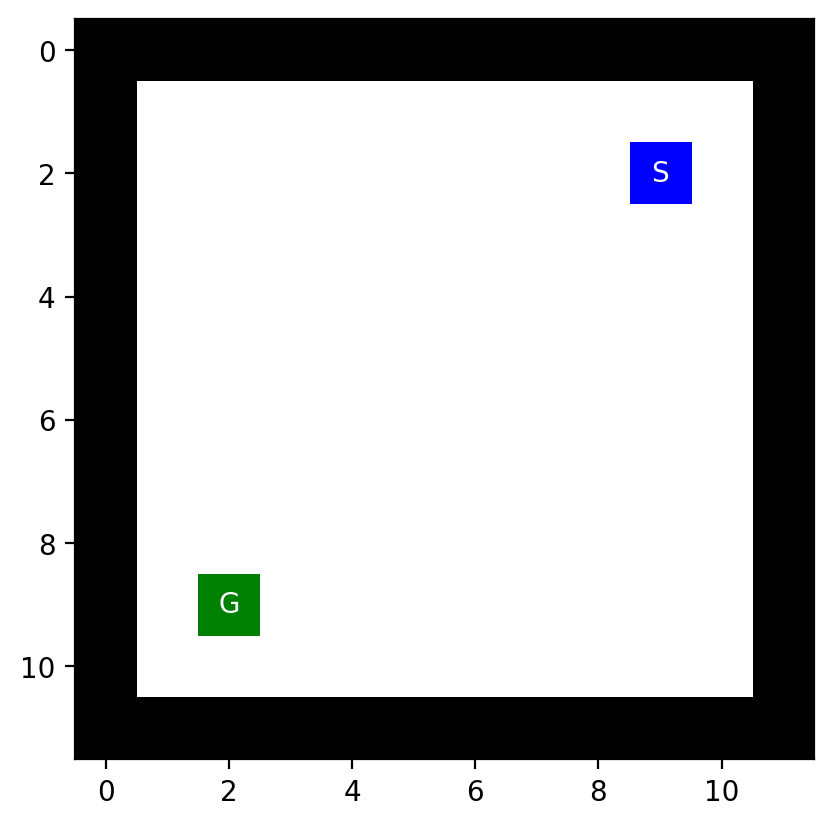

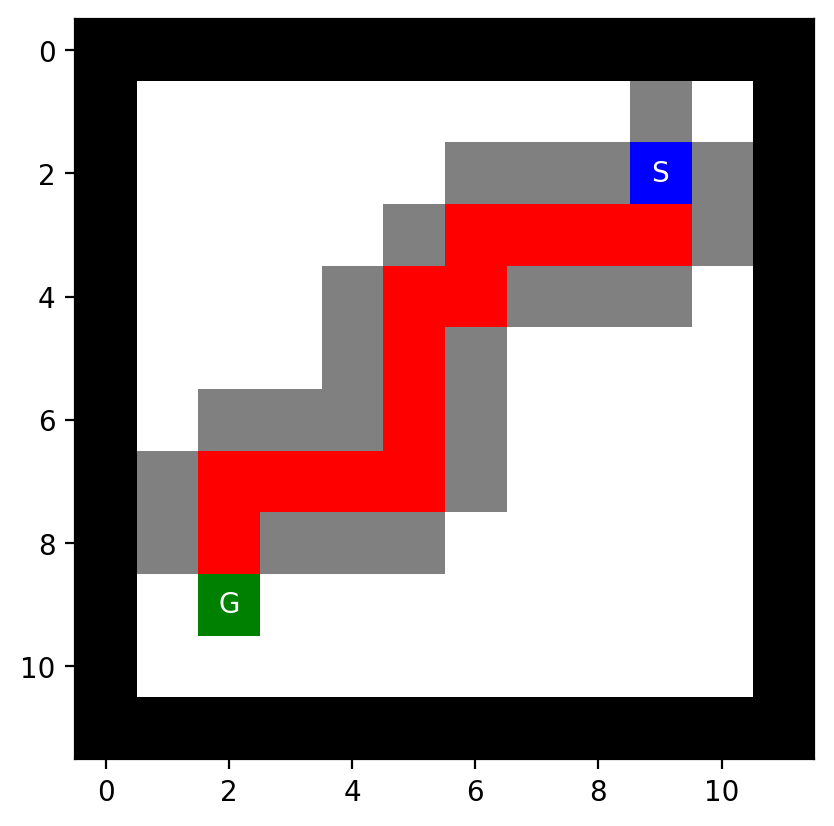

Path cost: 14
Number of nodes expanded: 38
Maximum size of the frontier: 24
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 53
this is File empty_2_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: wall_maze.txt


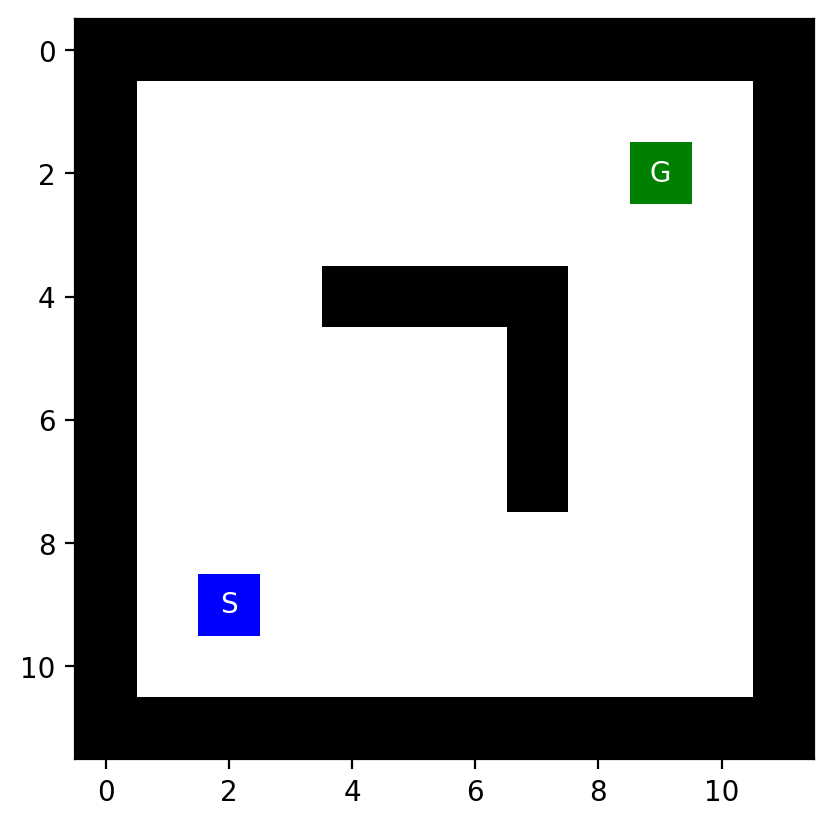

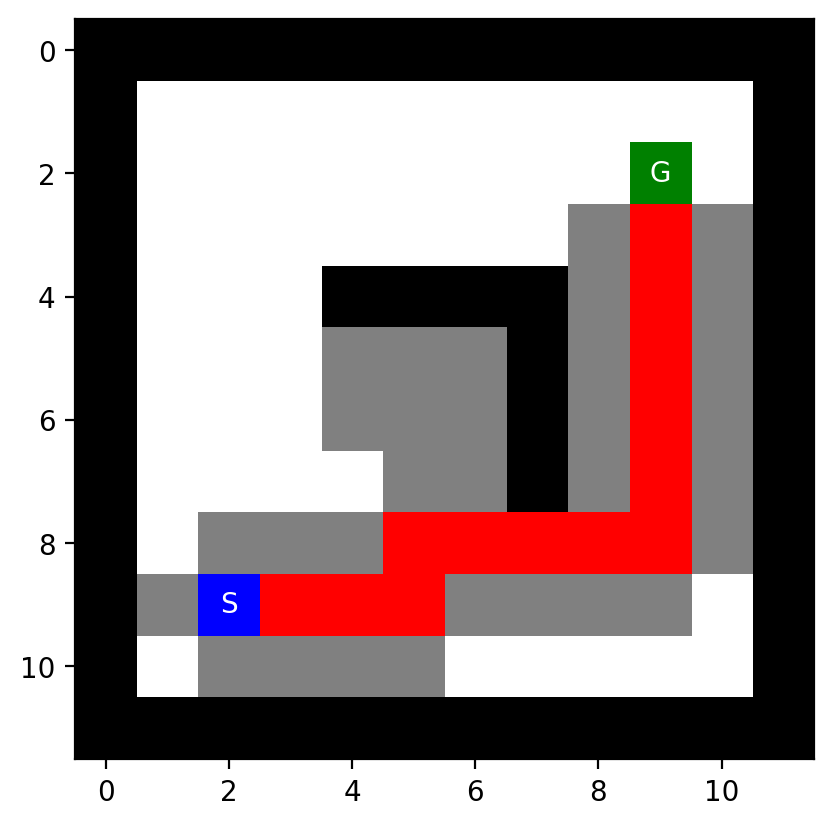

Path cost: 14
Number of nodes expanded: 46
Maximum size of the frontier: 27
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 61
this is File wall_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: open_maze.txt


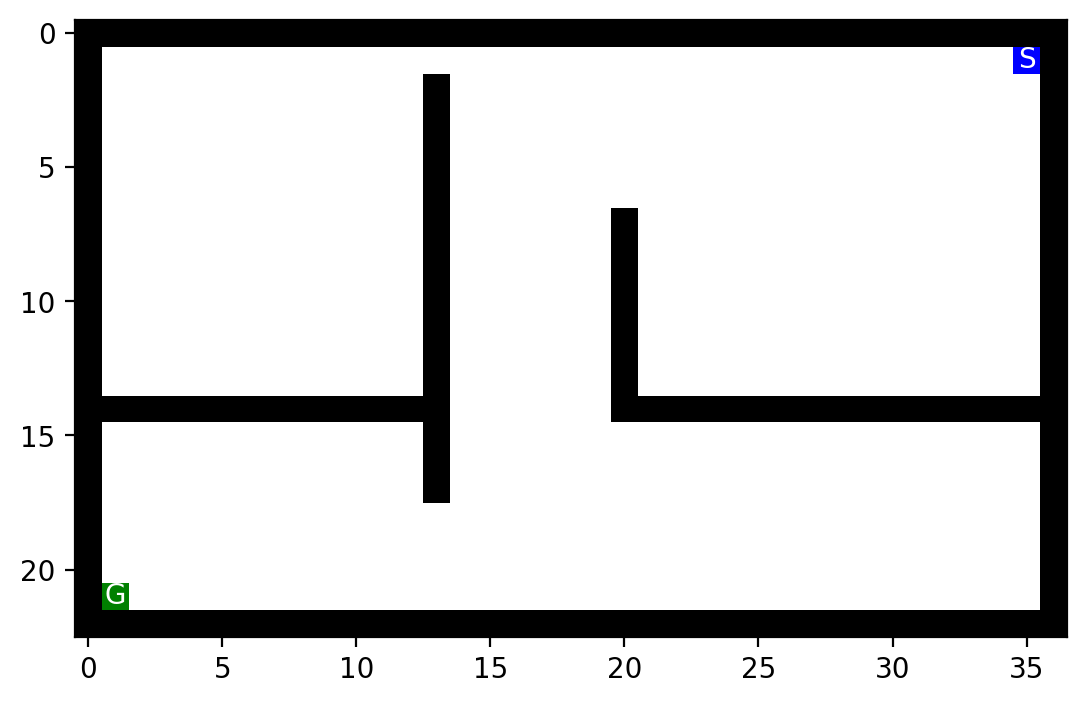

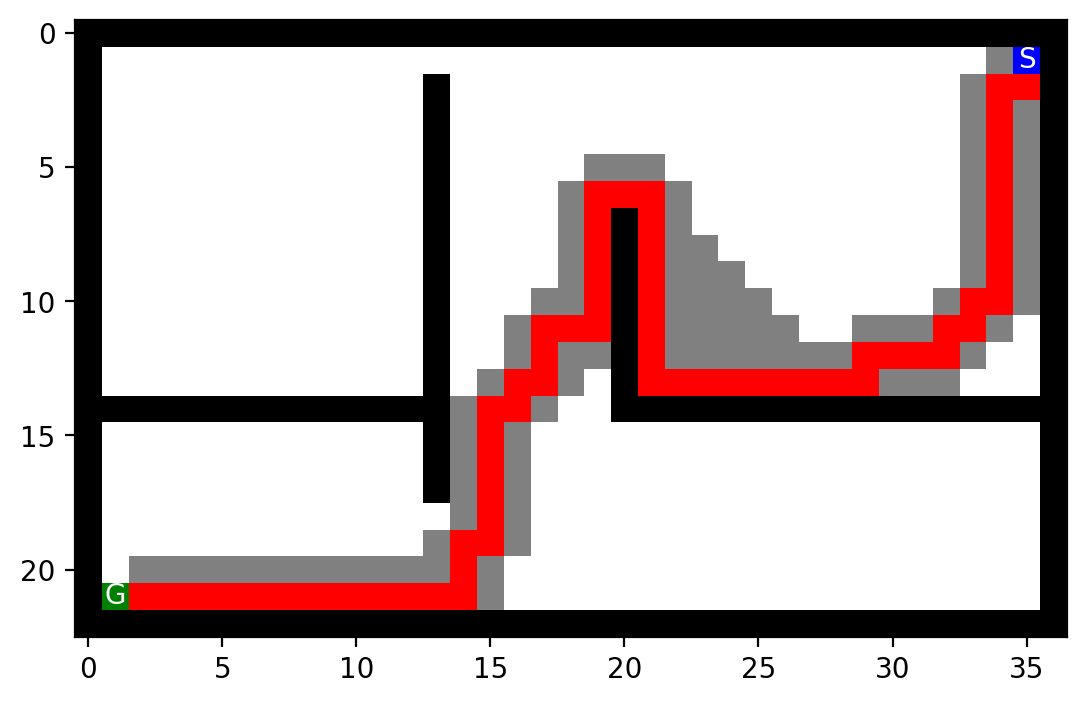

Path cost: 68
Number of nodes expanded: 159
Maximum size of the frontier: 80
Maximum Tree Depth: 68
Maximum Number of Node in Memory: 228
this is File open_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: loops_maze.txt


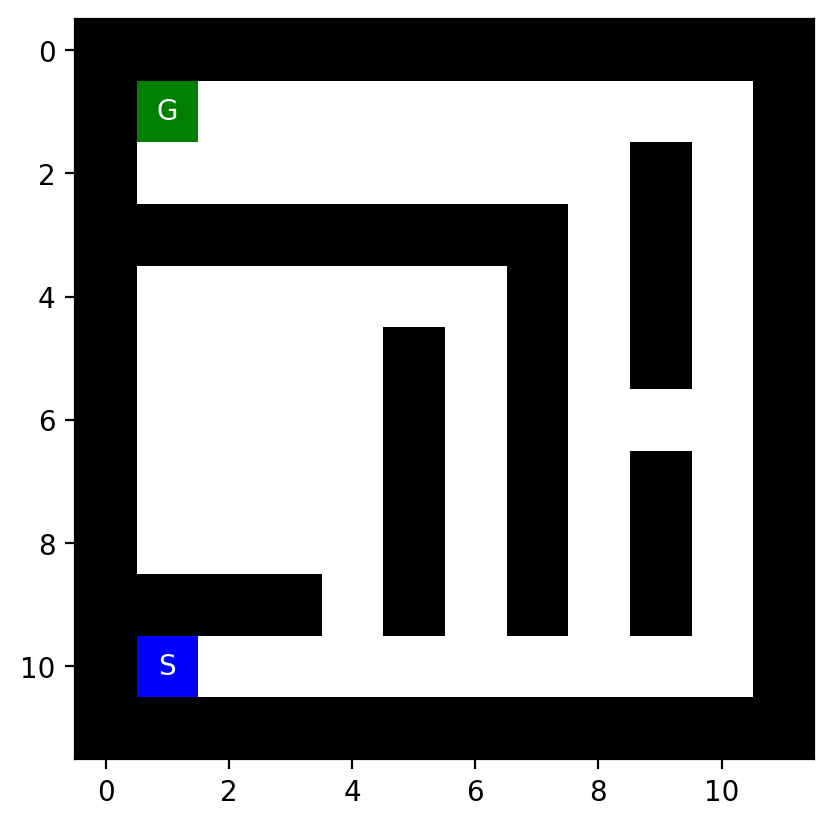

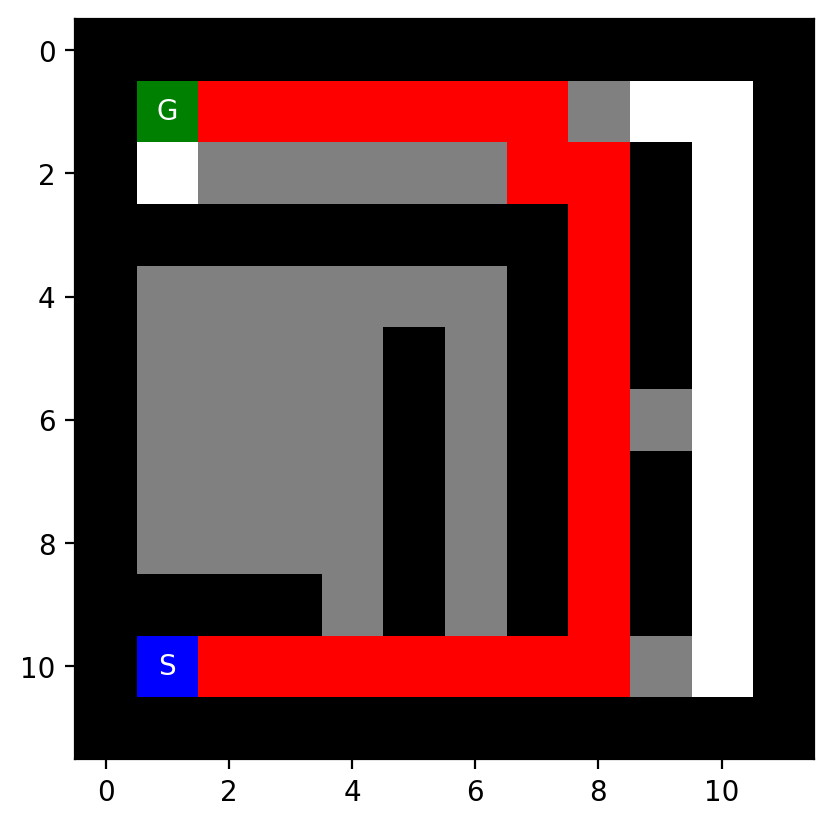

Path cost: 23
Number of nodes expanded: 60
Maximum size of the frontier: 10
Maximum Tree Depth: 23
Maximum Number of Node in Memory: 84
this is File loops_maze.txt
 
Algorithm Name: GBFS-M
Type of Maze: large_maze.txt


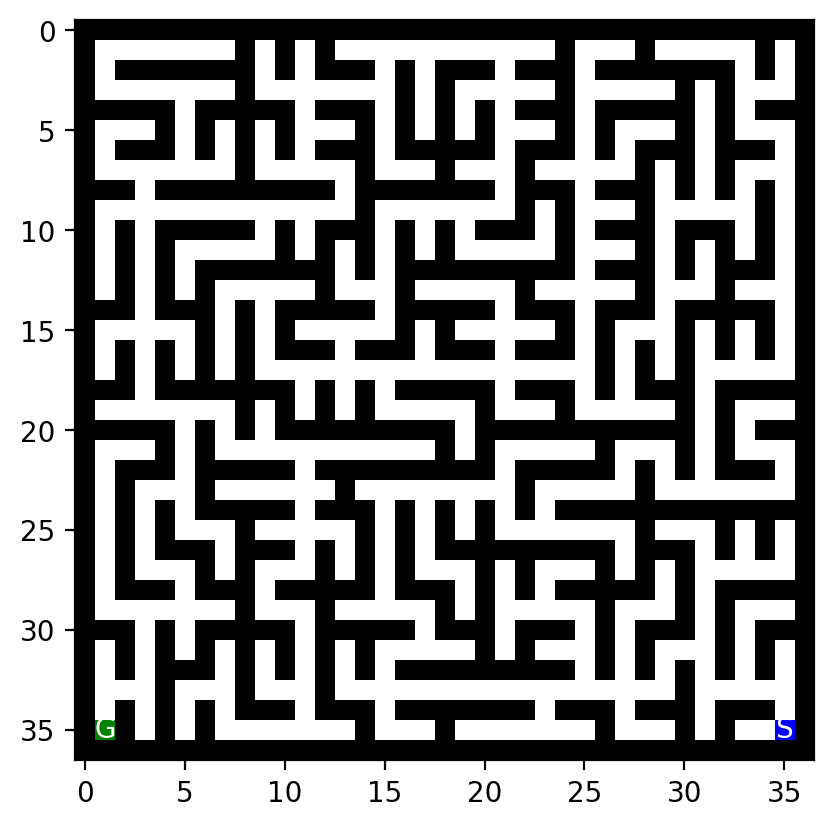

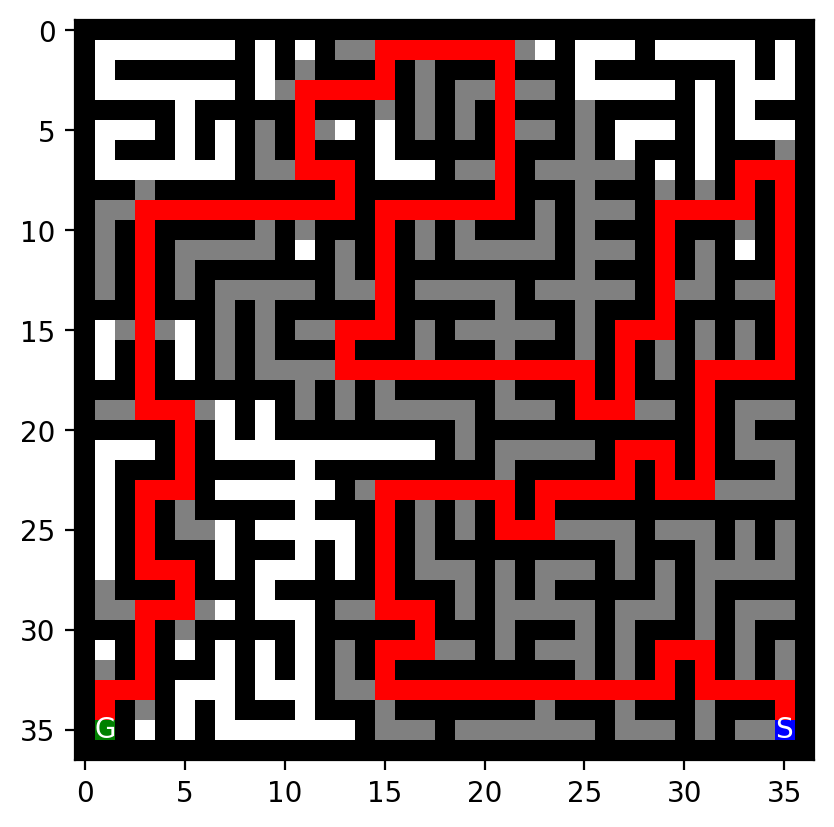

Path cost: 210
Number of nodes expanded: 485
Maximum size of the frontier: 24
Maximum Tree Depth: 210
Maximum Number of Node in Memory: 696
this is File large_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: medium_maze.txt


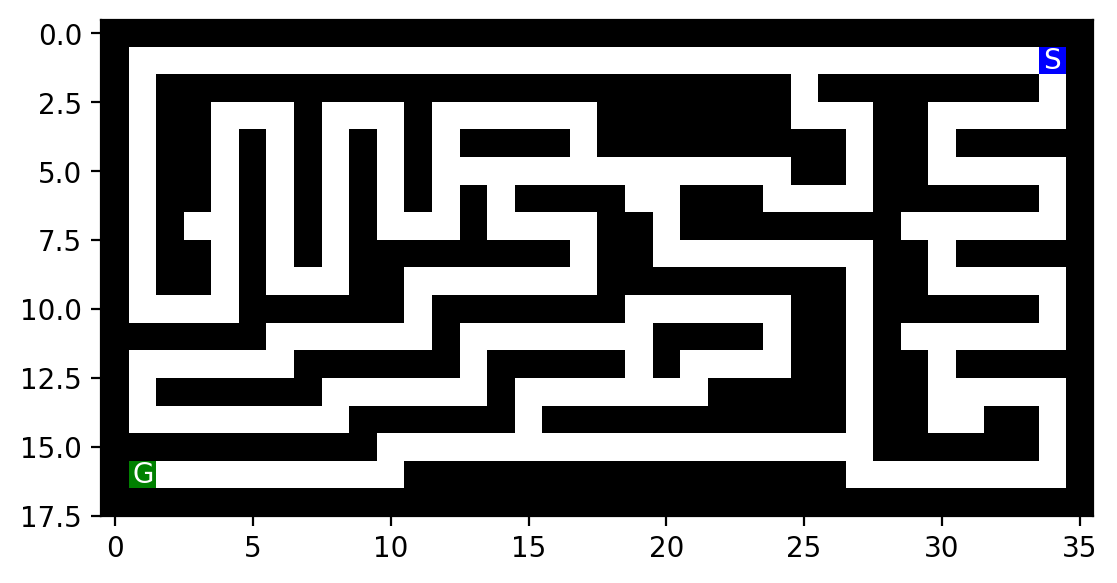

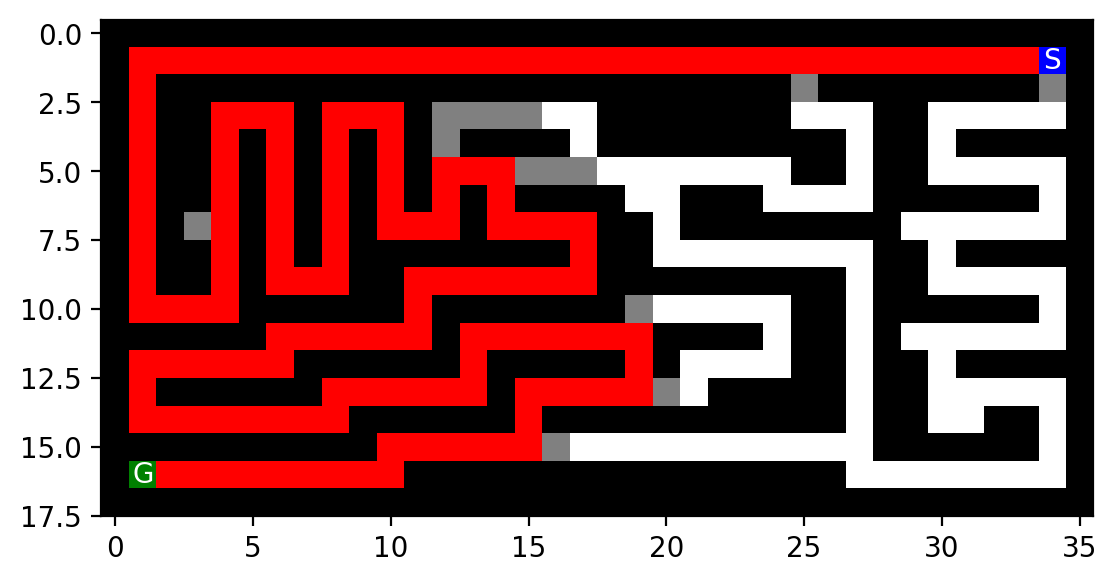

Path cost: 152
Number of nodes expanded: 167
Maximum size of the frontier: 8
Maximum Tree Depth: 152
Maximum Number of Node in Memory: 320
this is File medium_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: small_maze.txt


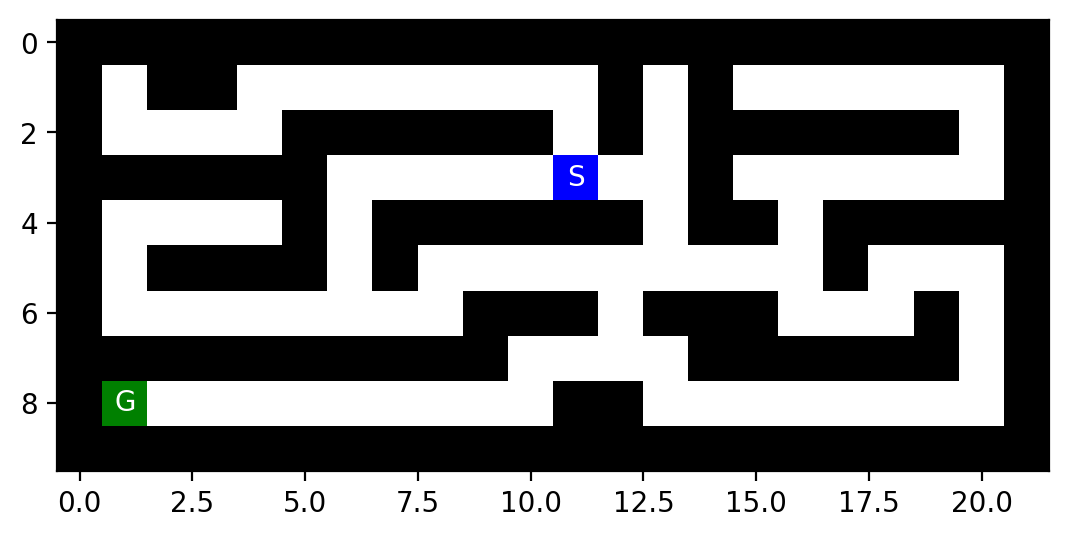

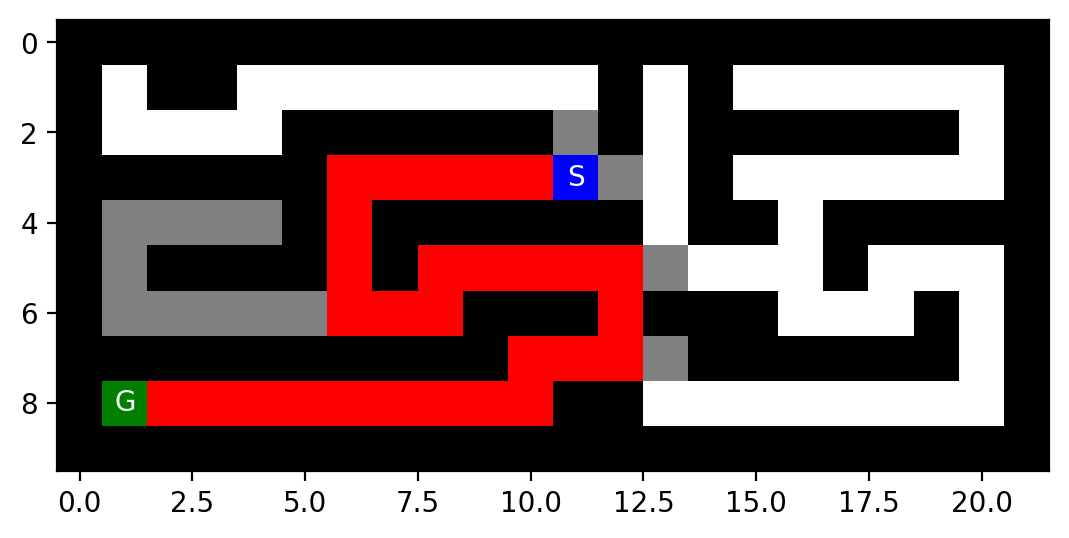

Path cost: 29
Number of nodes expanded: 44
Maximum size of the frontier: 5
Maximum Tree Depth: 29
Maximum Number of Node in Memory: 74
this is File small_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: empty_maze.txt


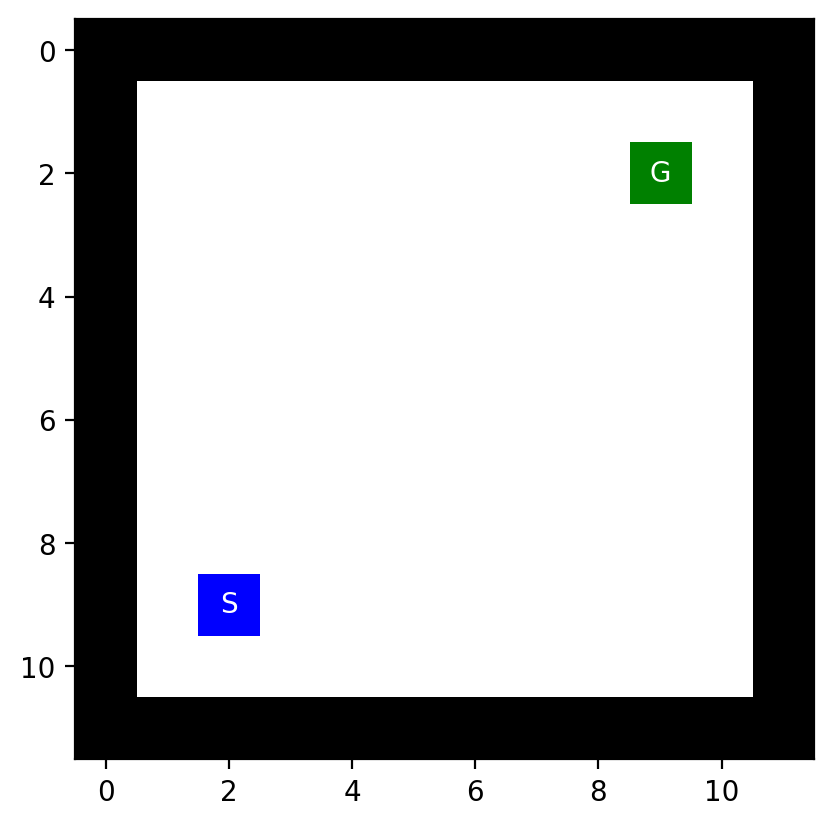

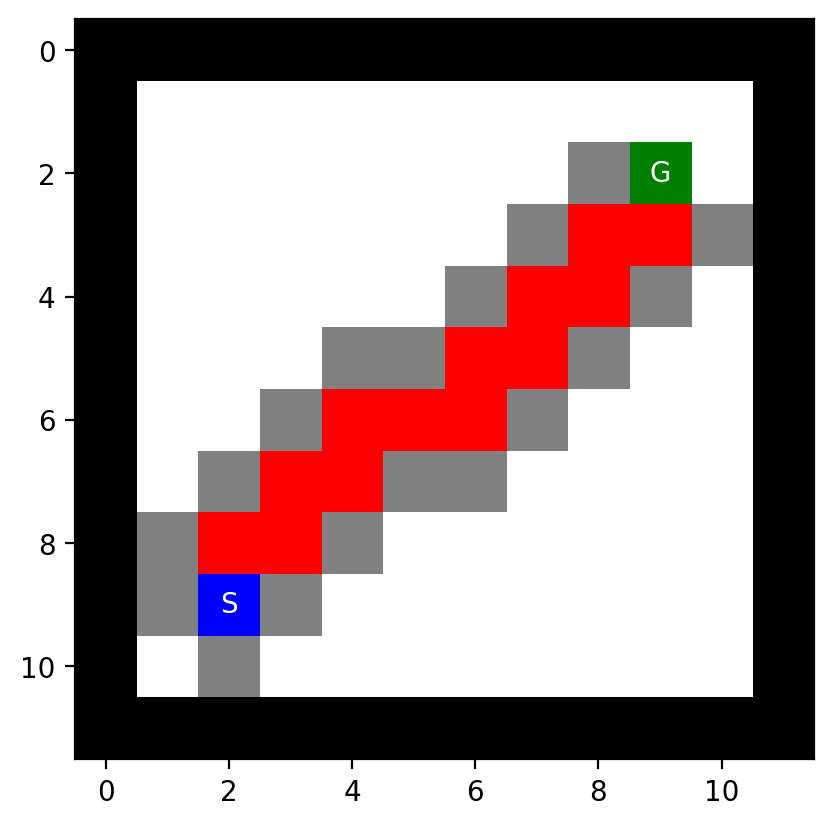

Path cost: 14
Number of nodes expanded: 33
Maximum size of the frontier: 19
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 48
this is File empty_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: empty_2_maze.txt


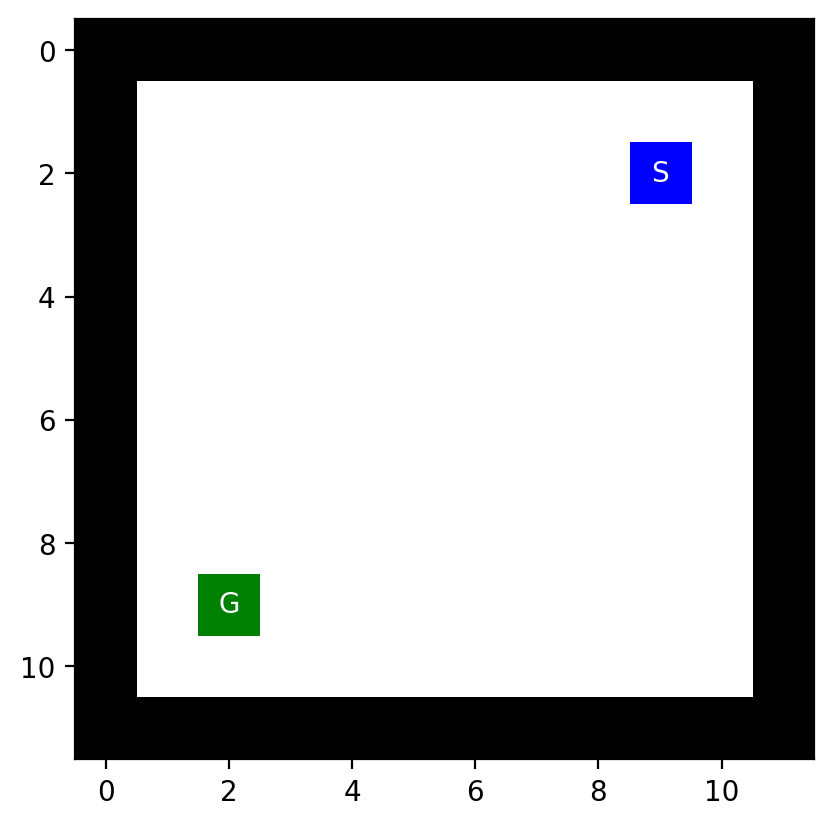

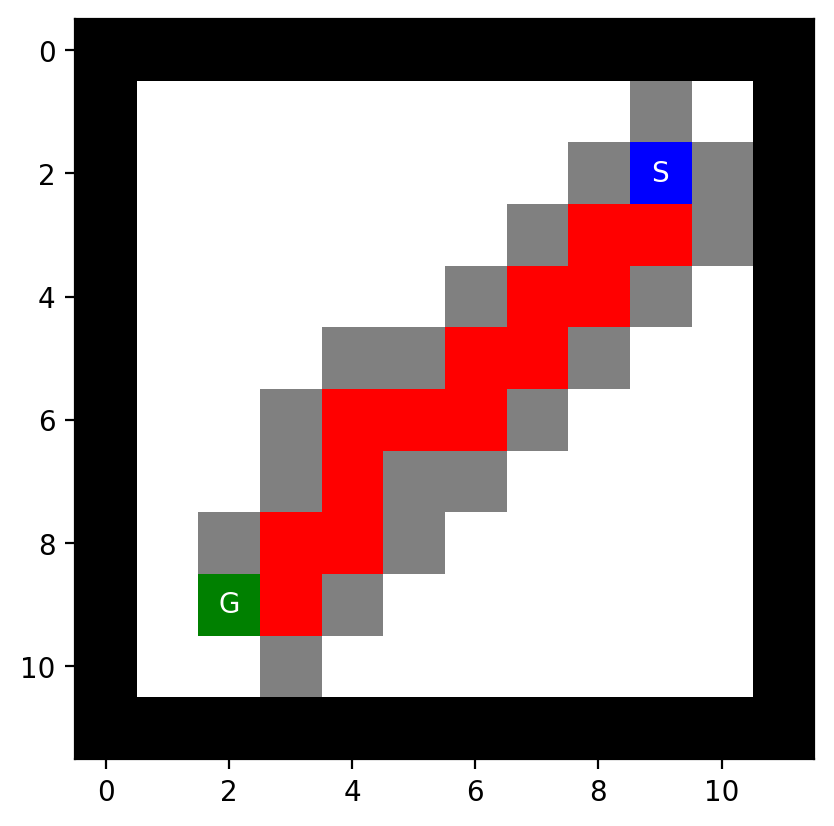

Path cost: 14
Number of nodes expanded: 34
Maximum size of the frontier: 20
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 49
this is File empty_2_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: wall_maze.txt


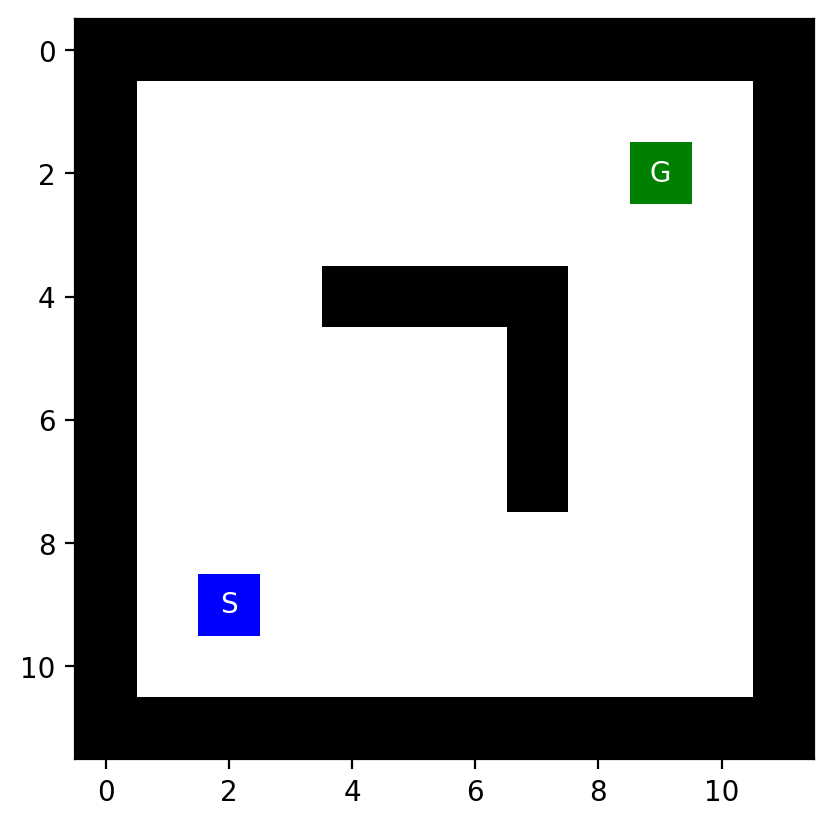

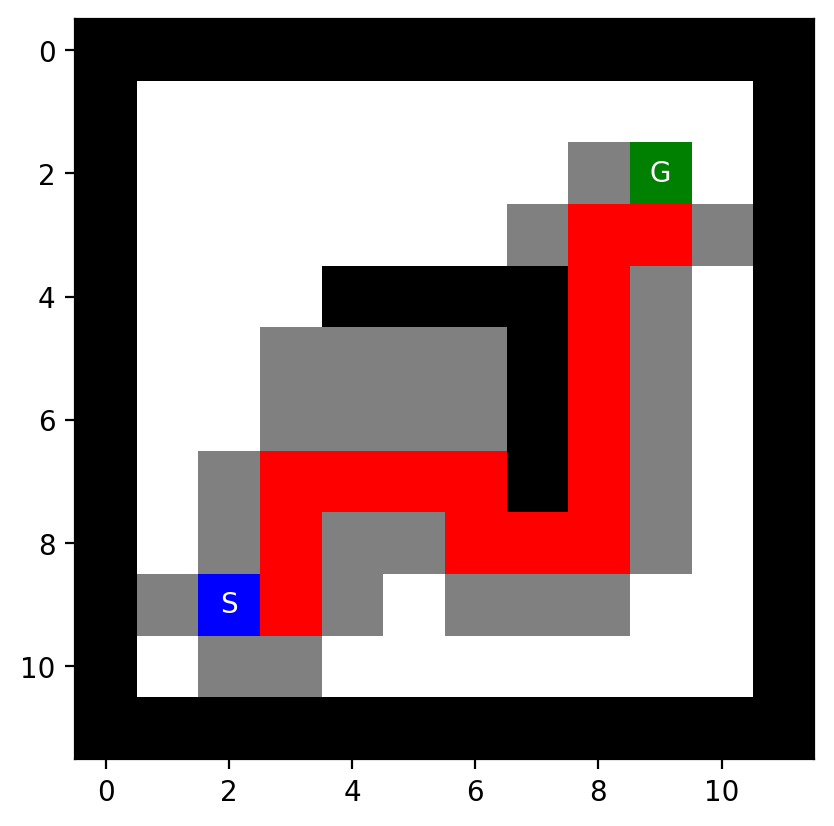

Path cost: 16
Number of nodes expanded: 44
Maximum size of the frontier: 23
Maximum Tree Depth: 16
Maximum Number of Node in Memory: 61
this is File wall_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: open_maze.txt


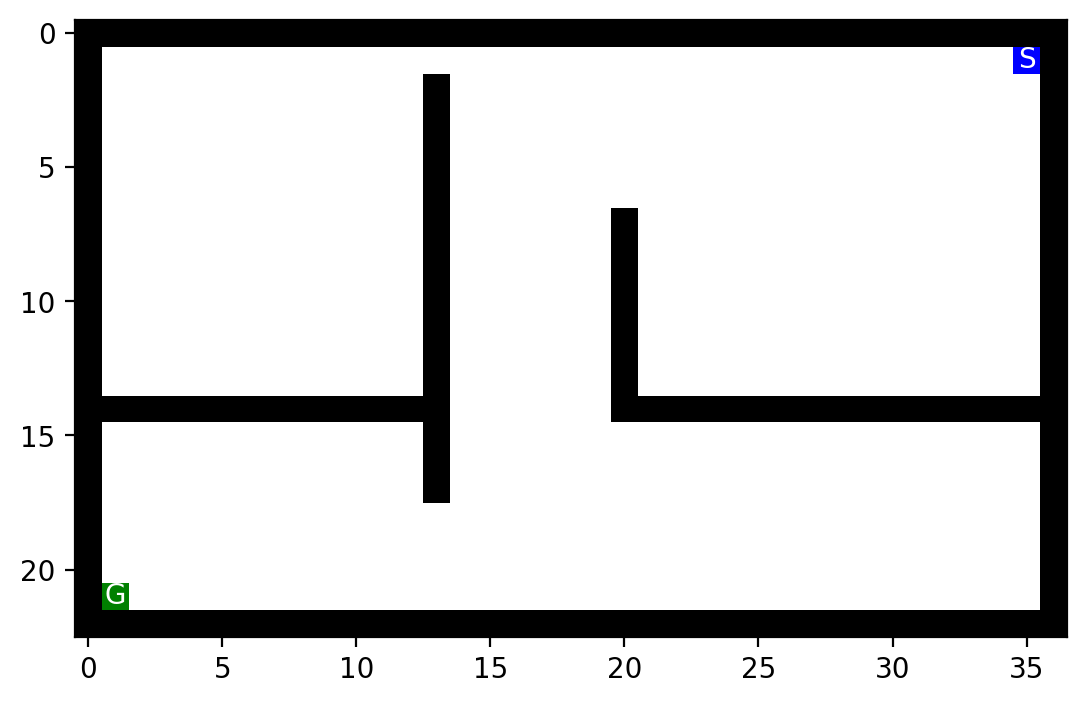

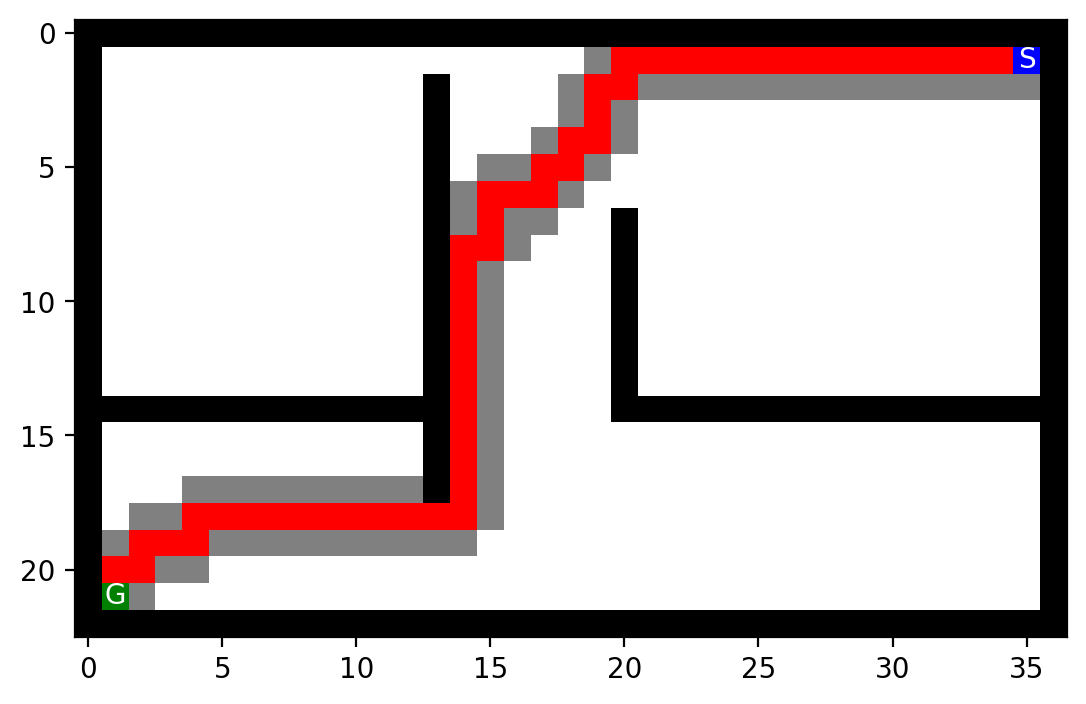

Path cost: 54
Number of nodes expanded: 120
Maximum size of the frontier: 66
Maximum Tree Depth: 54
Maximum Number of Node in Memory: 175
this is File open_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: loops_maze.txt


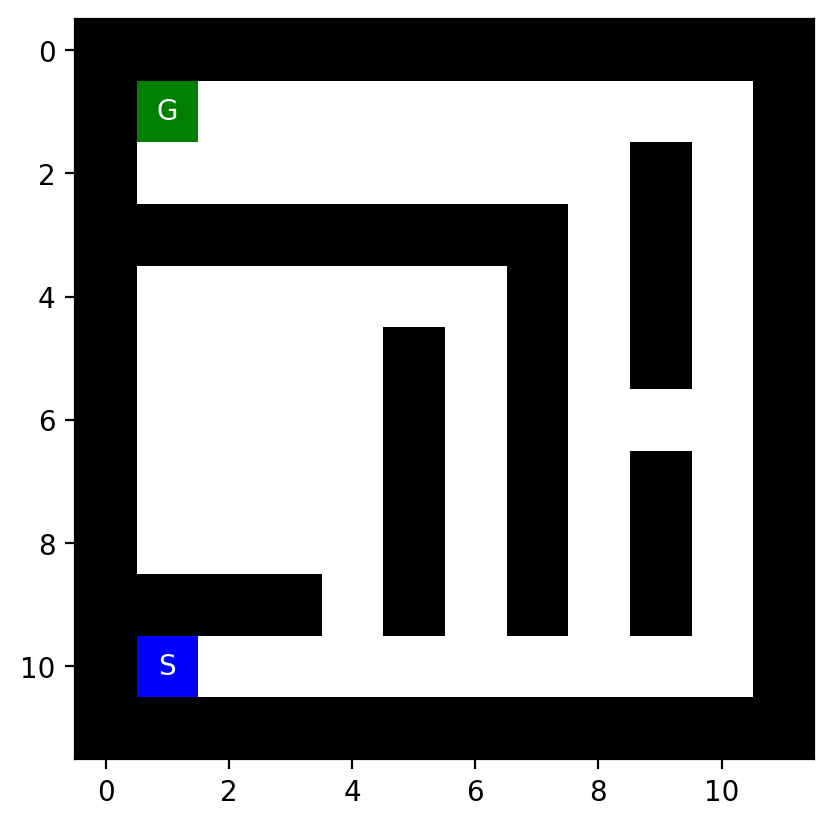

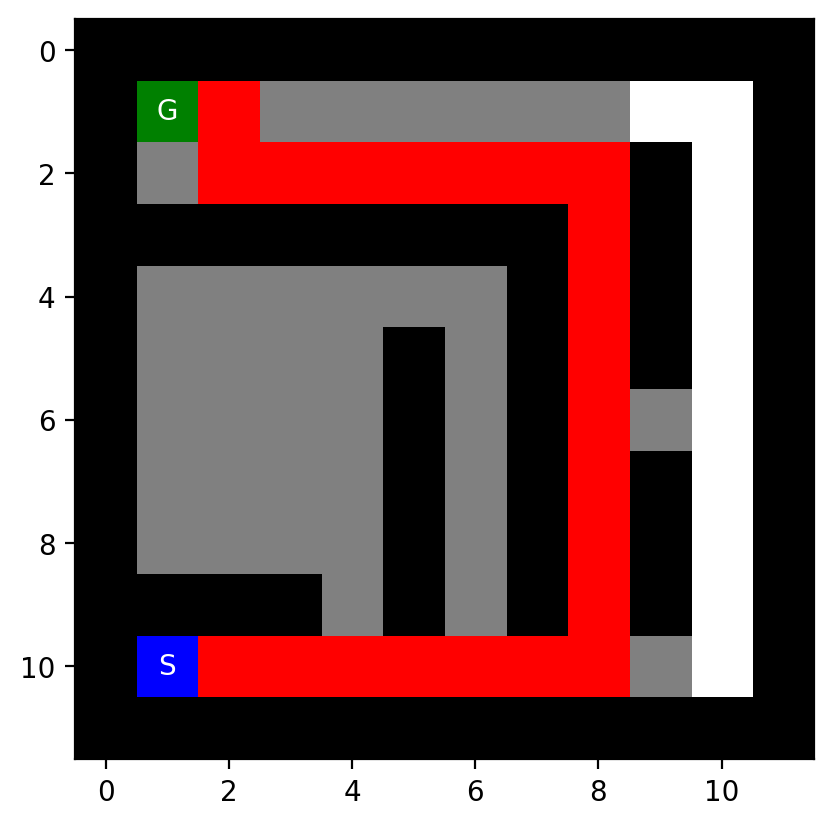

Path cost: 23
Number of nodes expanded: 61
Maximum size of the frontier: 10
Maximum Tree Depth: 23
Maximum Number of Node in Memory: 85
this is File loops_maze.txt
 
Algorithm Name: GBFS-E
Type of Maze: large_maze.txt


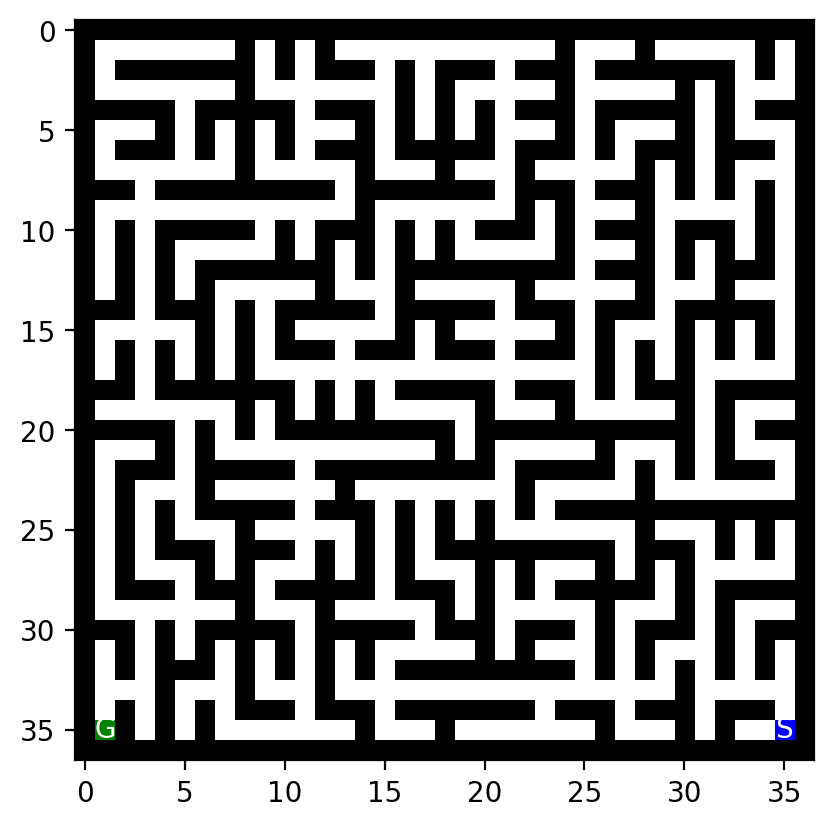

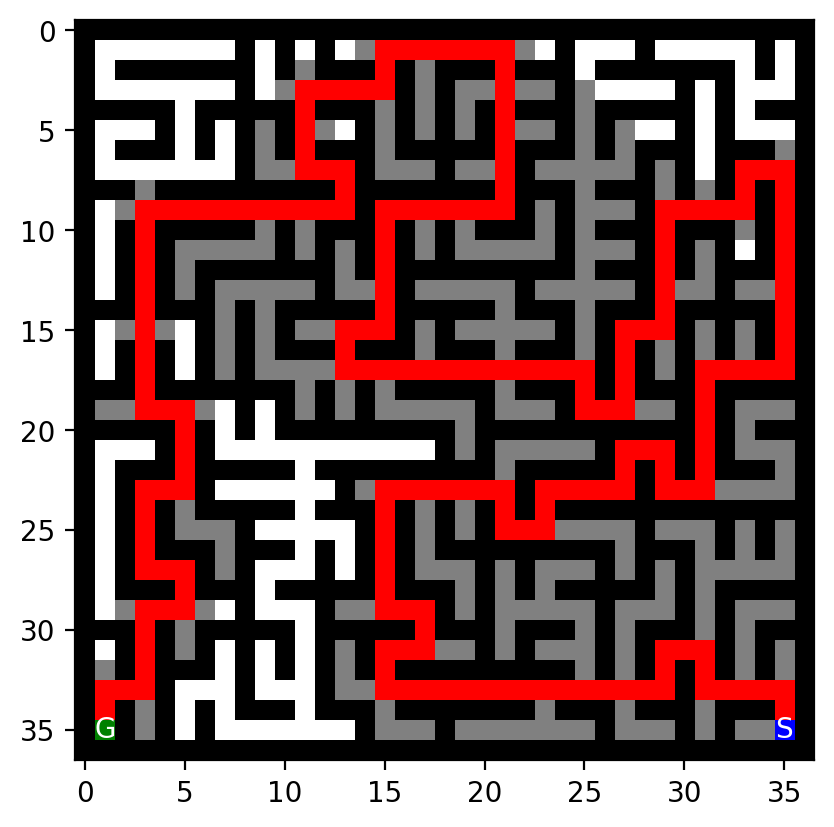

Path cost: 210
Number of nodes expanded: 492
Maximum size of the frontier: 21
Maximum Tree Depth: 210
Maximum Number of Node in Memory: 703
this is File large_maze.txt
 
Algorithm Name: A*-M
Type of Maze: medium_maze.txt


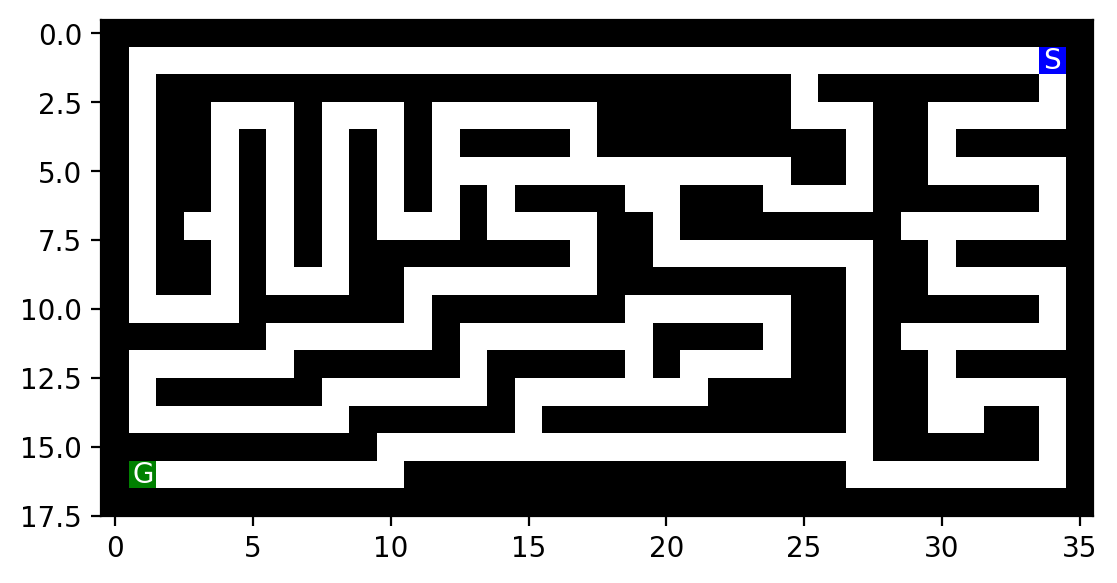

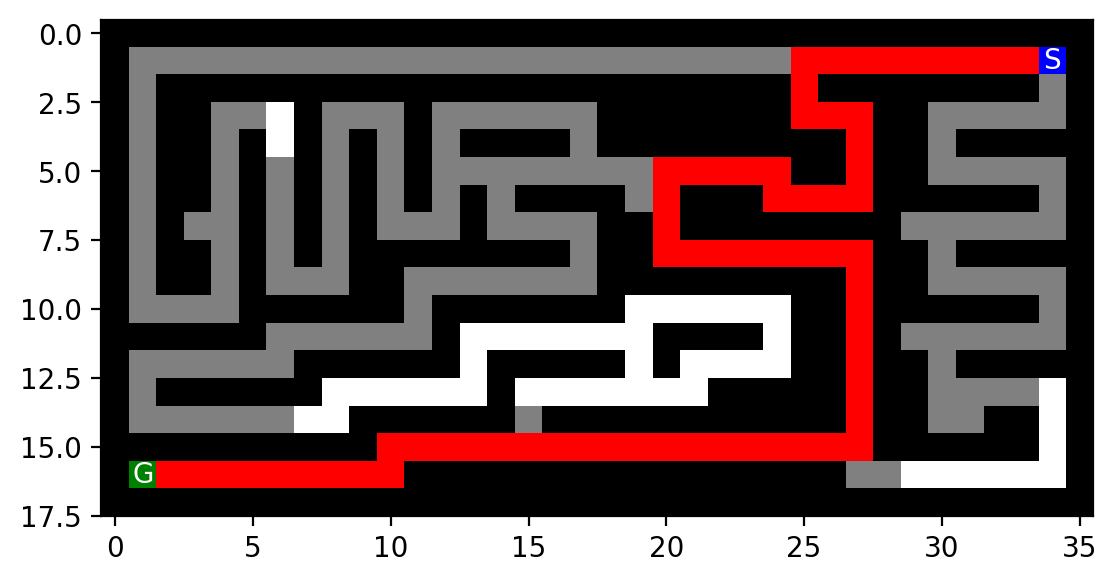

Path cost: 68
Number of nodes expanded: 228
Maximum size of the frontier: 8
Maximum Tree Depth: 68
Maximum Number of Node in Memory: 297
this is File medium_maze.txt
 
Algorithm Name: A*-M
Type of Maze: small_maze.txt


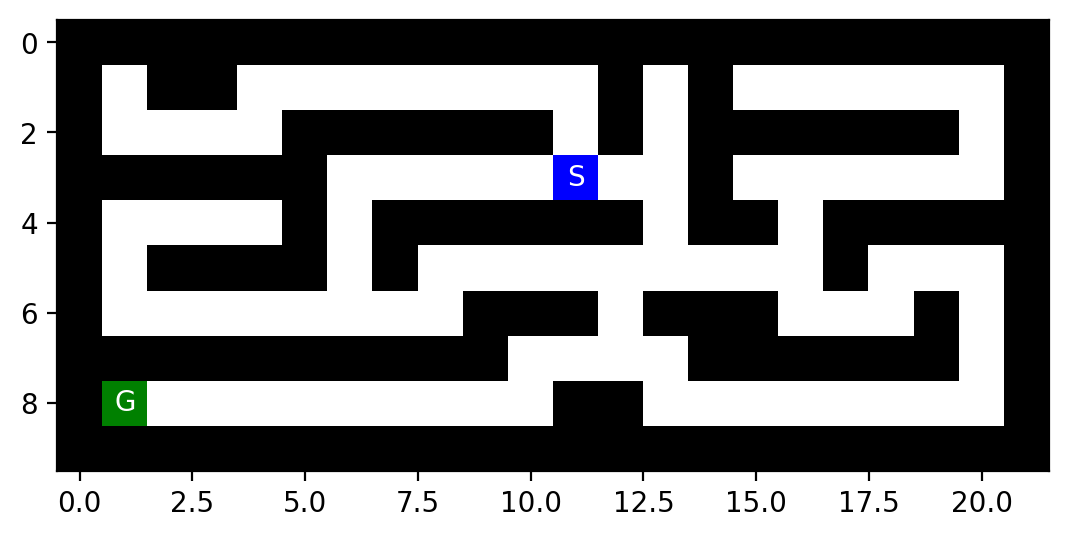

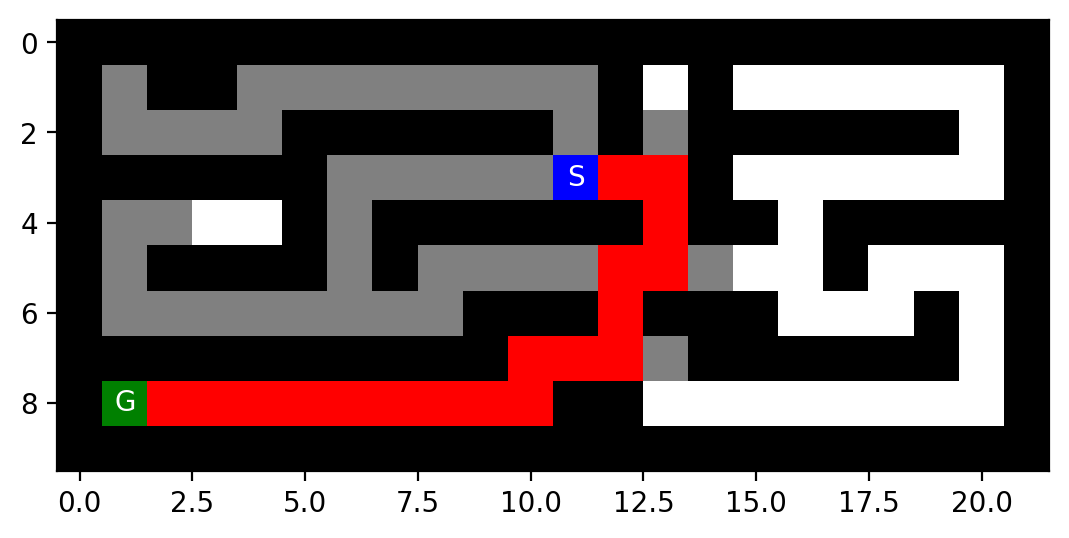

Path cost: 19
Number of nodes expanded: 59
Maximum size of the frontier: 8
Maximum Tree Depth: 19
Maximum Number of Node in Memory: 79
this is File small_maze.txt
 
Algorithm Name: A*-M
Type of Maze: empty_maze.txt


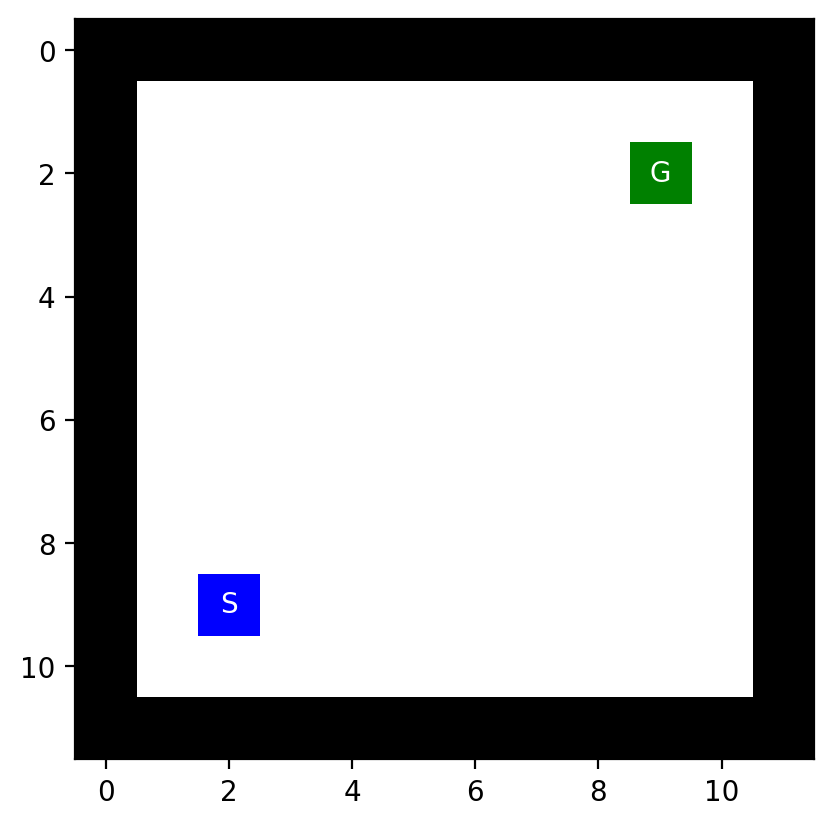

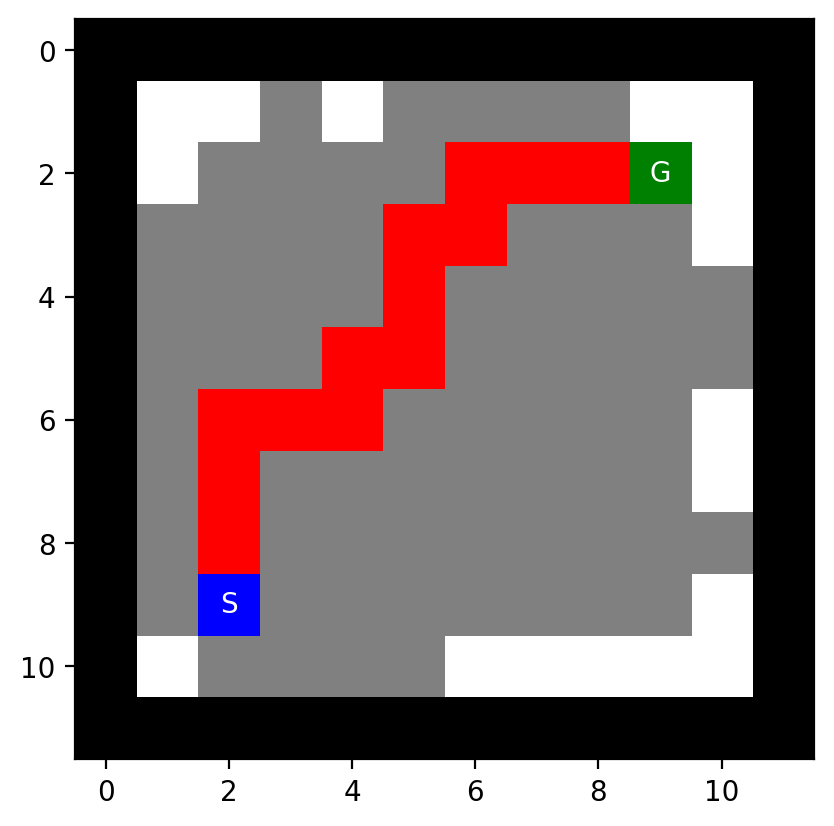

Path cost: 14
Number of nodes expanded: 83
Maximum size of the frontier: 34
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 98
this is File empty_maze.txt
 
Algorithm Name: A*-M
Type of Maze: empty_2_maze.txt


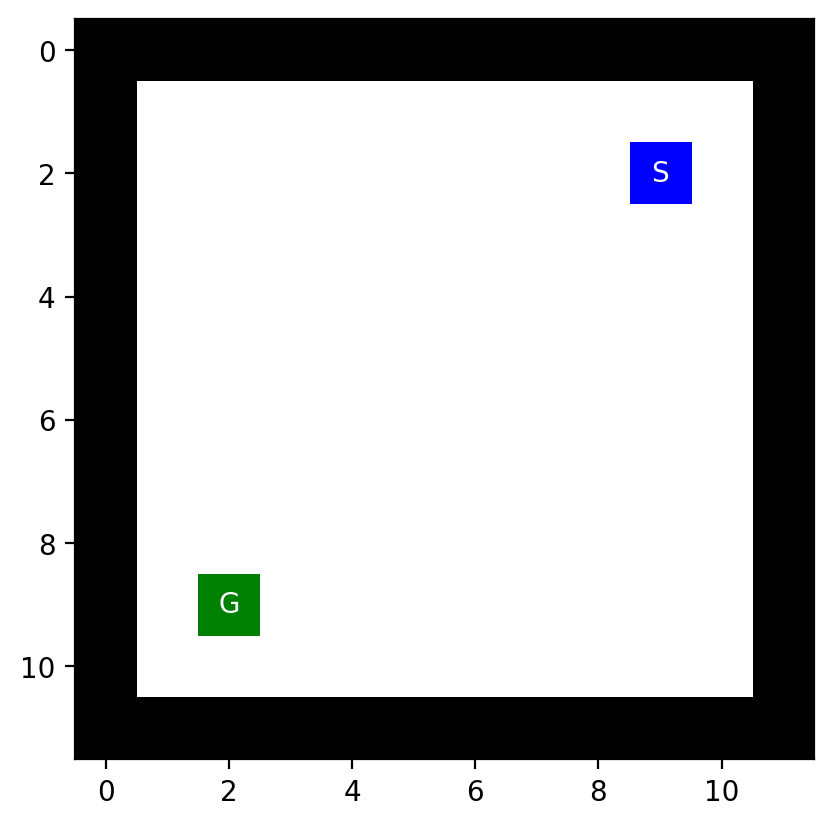

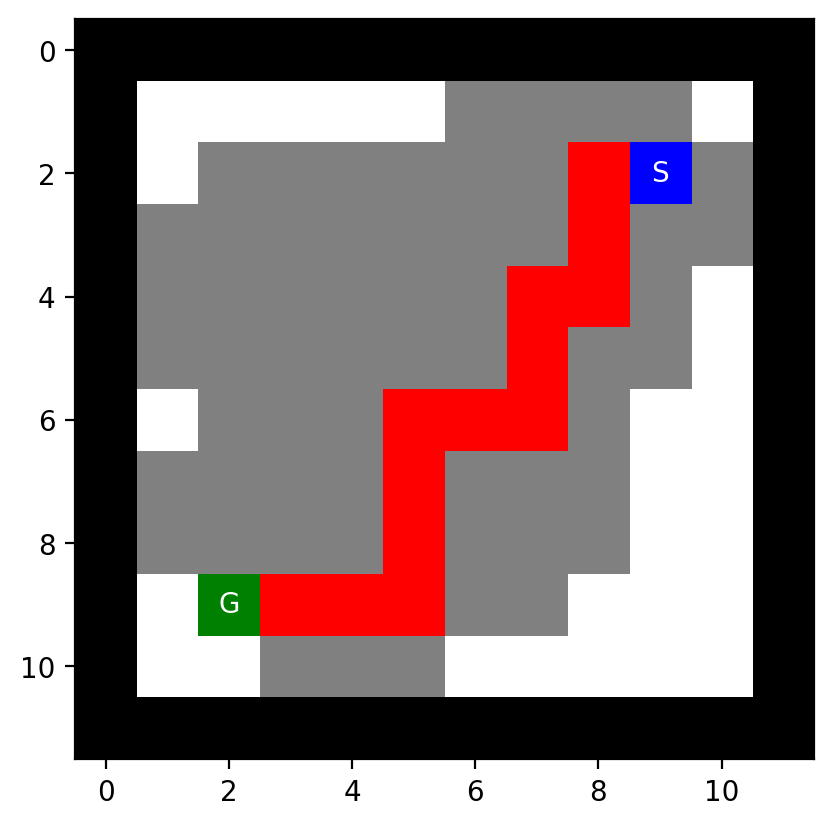

Path cost: 14
Number of nodes expanded: 73
Maximum size of the frontier: 34
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 88
this is File empty_2_maze.txt
 
Algorithm Name: A*-M
Type of Maze: wall_maze.txt


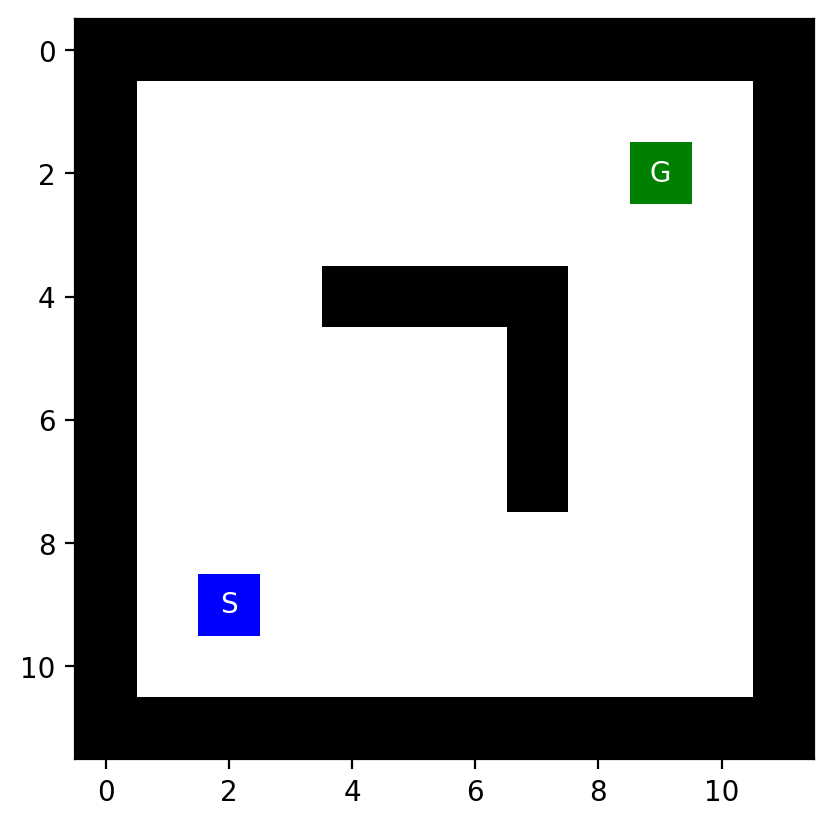

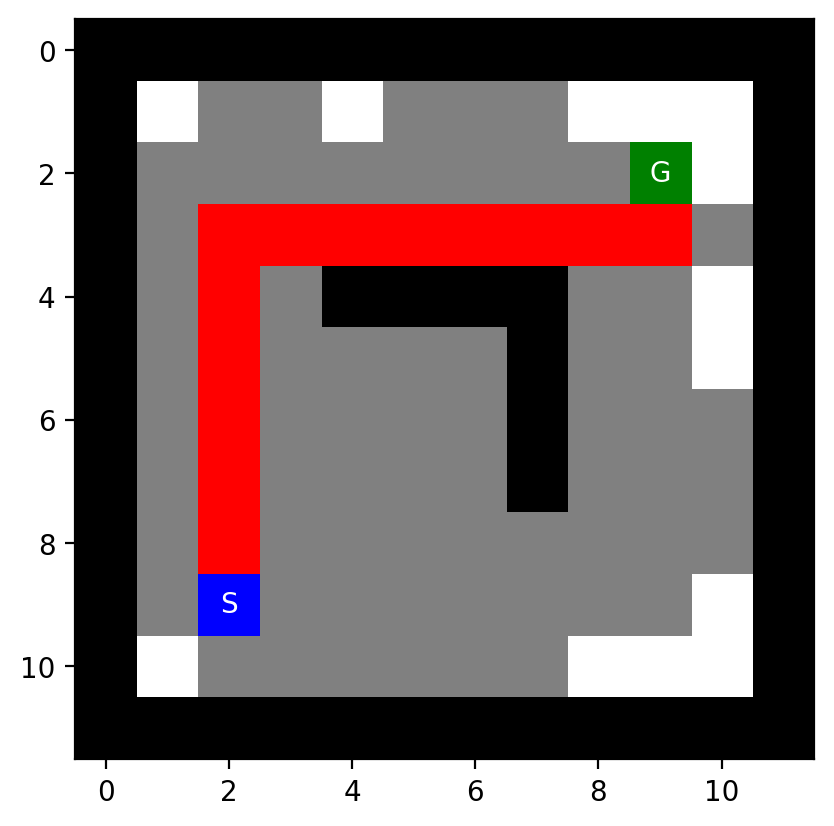

Path cost: 14
Number of nodes expanded: 80
Maximum size of the frontier: 34
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 95
this is File wall_maze.txt
 
Algorithm Name: A*-M
Type of Maze: open_maze.txt


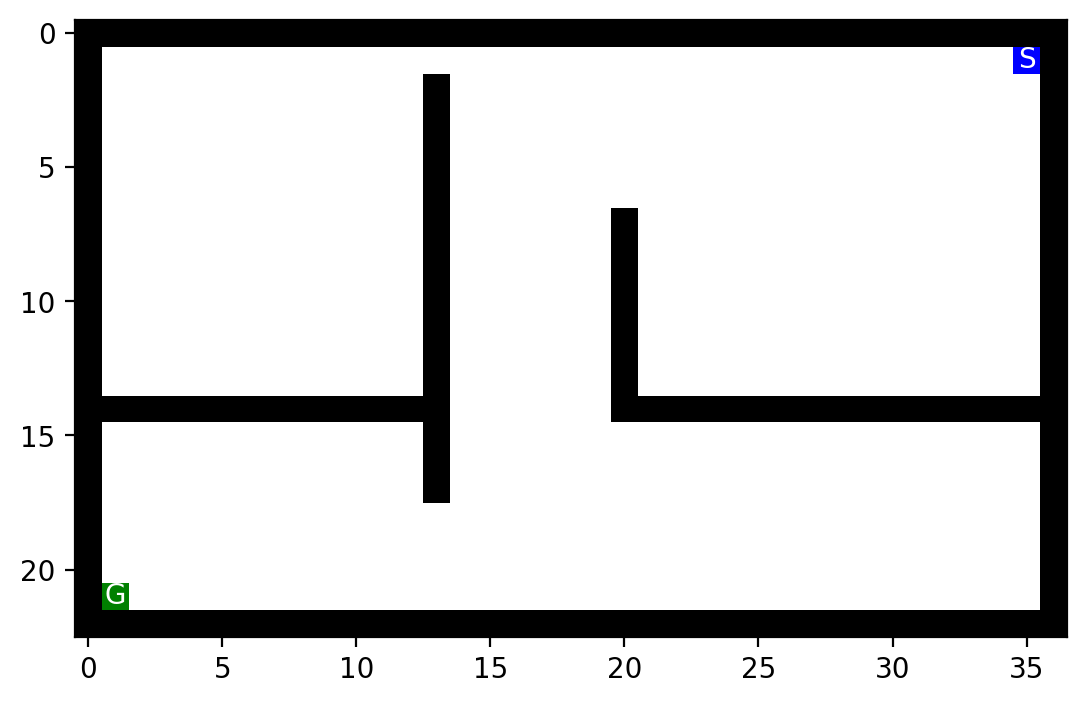

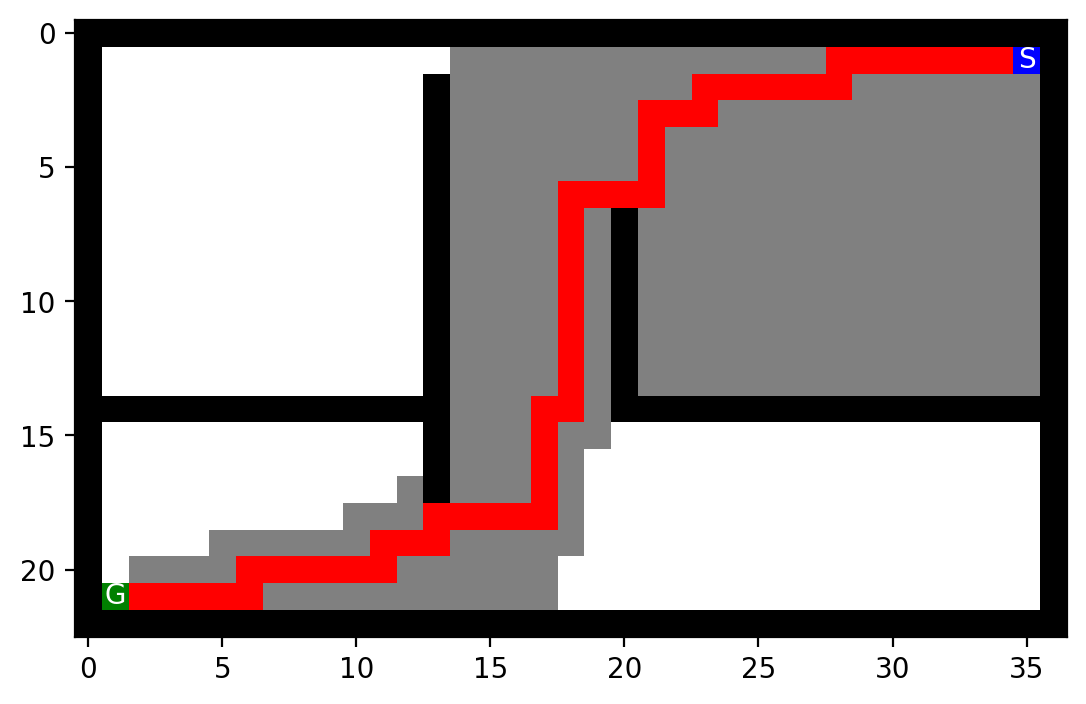

Path cost: 54
Number of nodes expanded: 358
Maximum size of the frontier: 63
Maximum Tree Depth: 54
Maximum Number of Node in Memory: 413
this is File open_maze.txt
 
Algorithm Name: A*-M
Type of Maze: loops_maze.txt


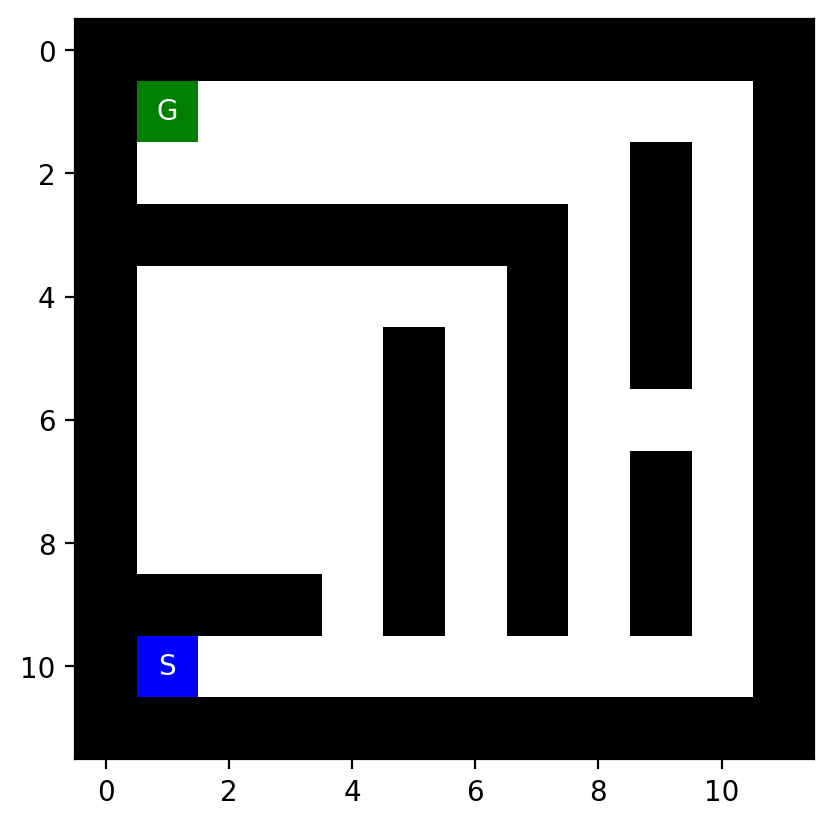

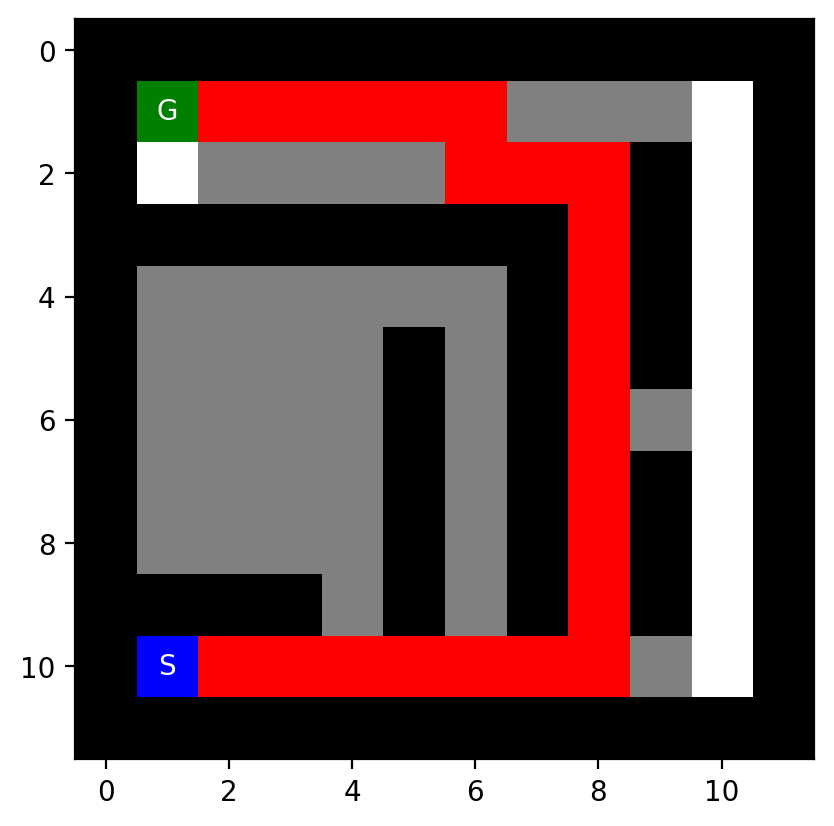

Path cost: 23
Number of nodes expanded: 61
Maximum size of the frontier: 6
Maximum Tree Depth: 23
Maximum Number of Node in Memory: 85
this is File loops_maze.txt
 
Algorithm Name: A*-M
Type of Maze: large_maze.txt


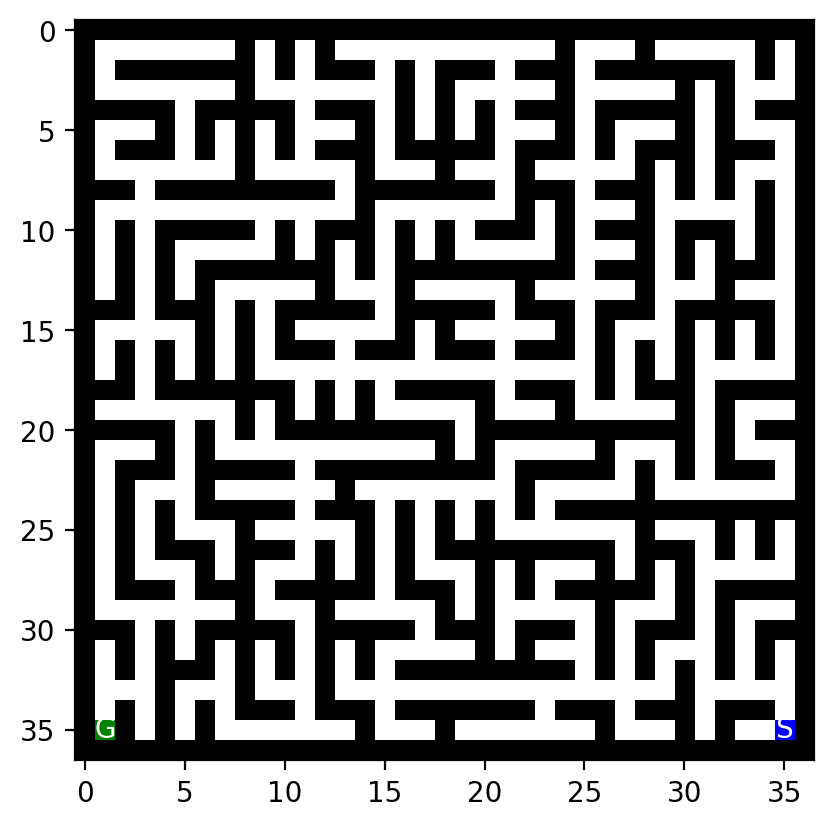

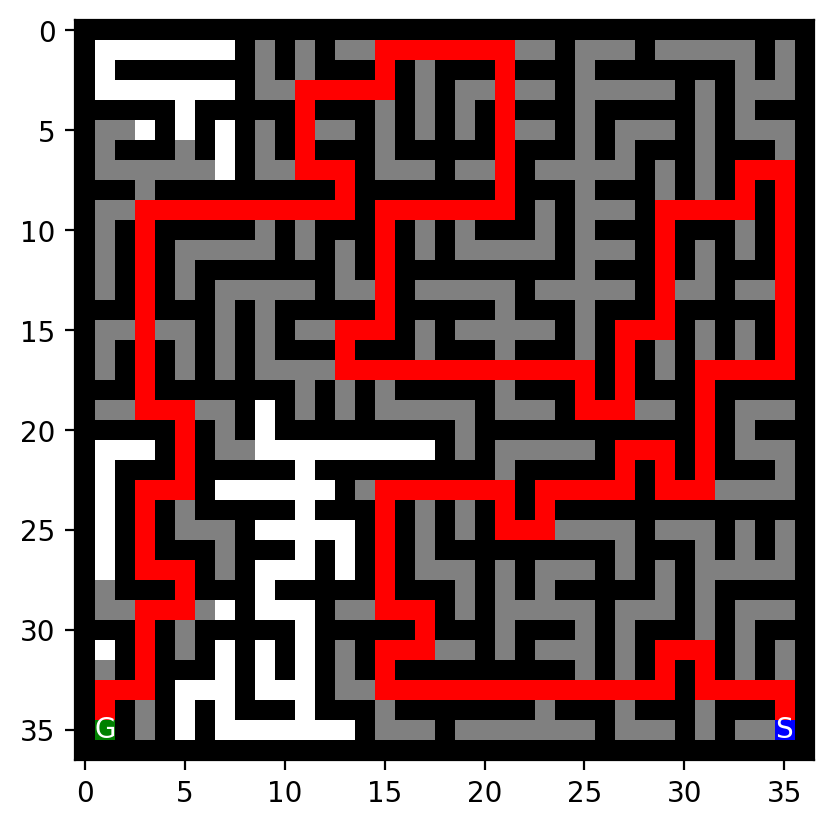

Path cost: 210
Number of nodes expanded: 557
Maximum size of the frontier: 12
Maximum Tree Depth: 210
Maximum Number of Node in Memory: 768
this is File large_maze.txt
 
Algorithm Name: A*-E
Type of Maze: medium_maze.txt


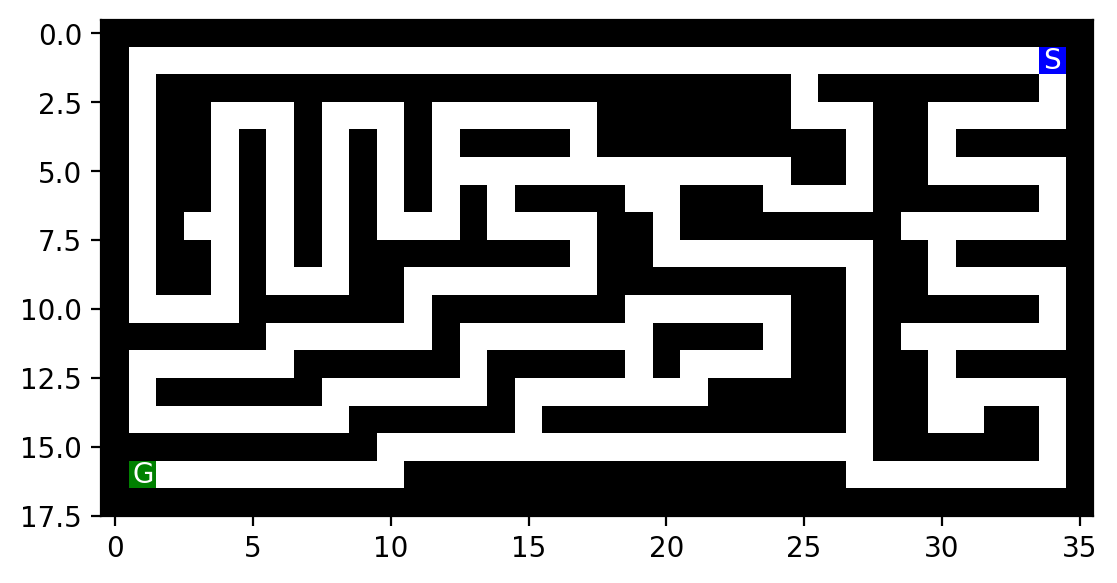

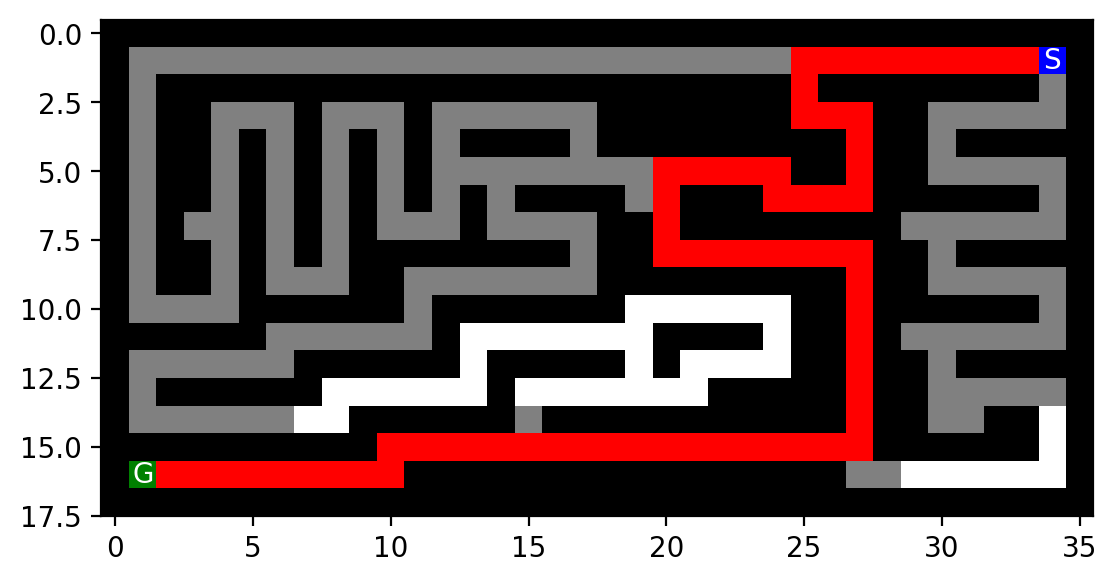

Path cost: 68
Number of nodes expanded: 231
Maximum size of the frontier: 8
Maximum Tree Depth: 68
Maximum Number of Node in Memory: 300
this is File medium_maze.txt
 
Algorithm Name: A*-E
Type of Maze: small_maze.txt


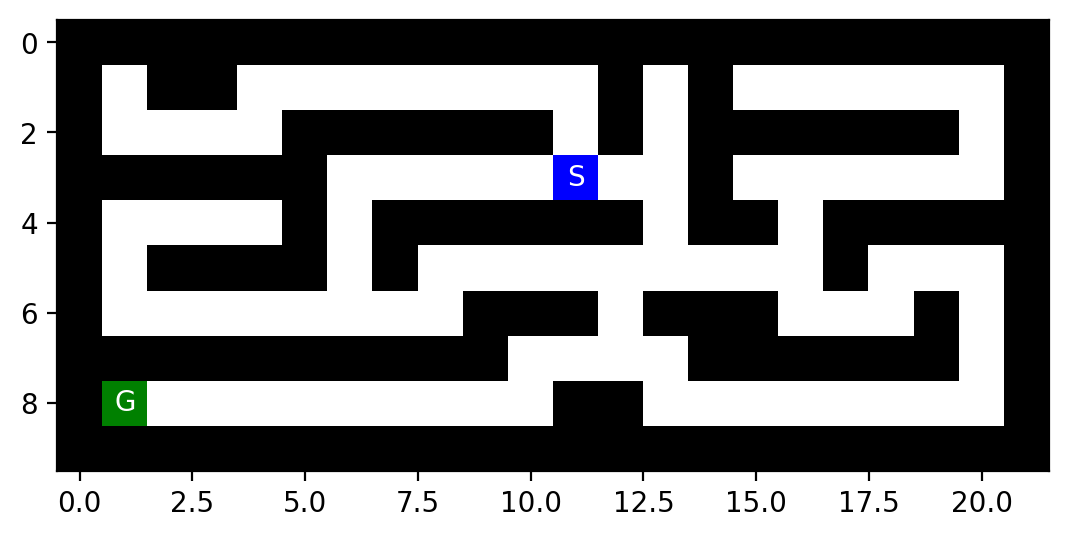

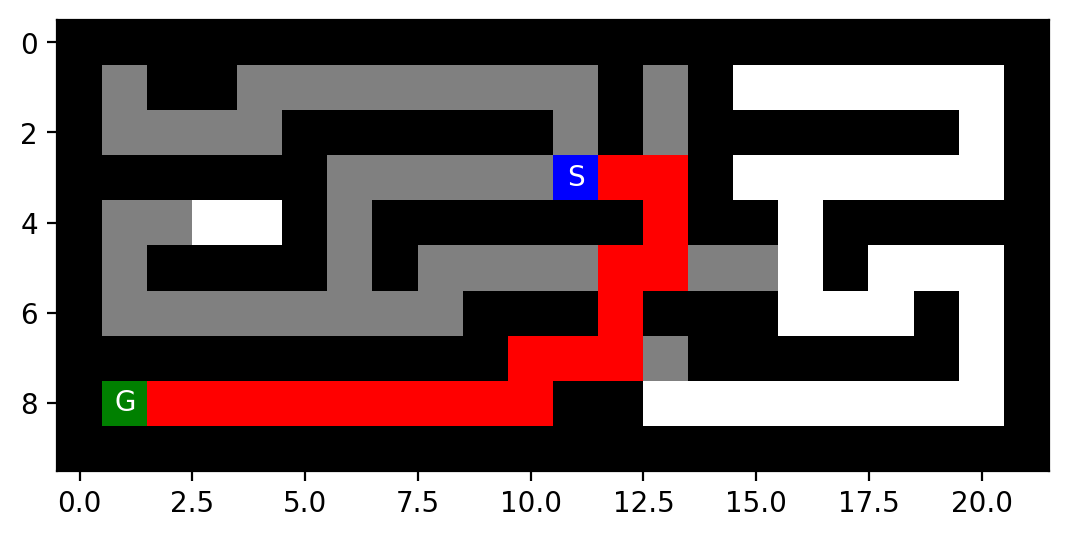

Path cost: 19
Number of nodes expanded: 61
Maximum size of the frontier: 7
Maximum Tree Depth: 19
Maximum Number of Node in Memory: 81
this is File small_maze.txt
 
Algorithm Name: A*-E
Type of Maze: empty_maze.txt


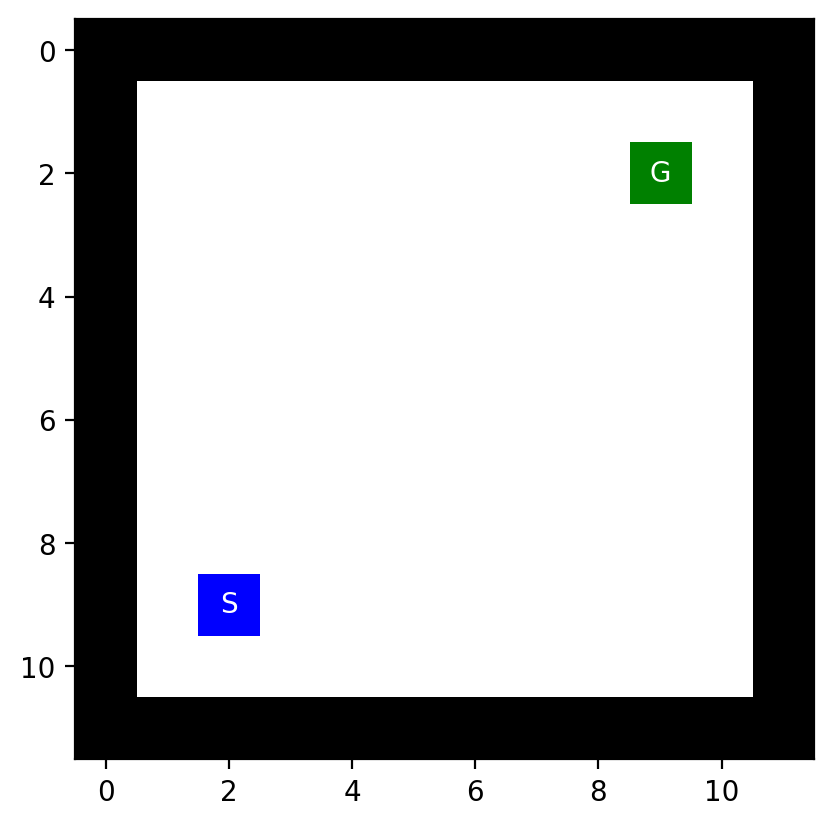

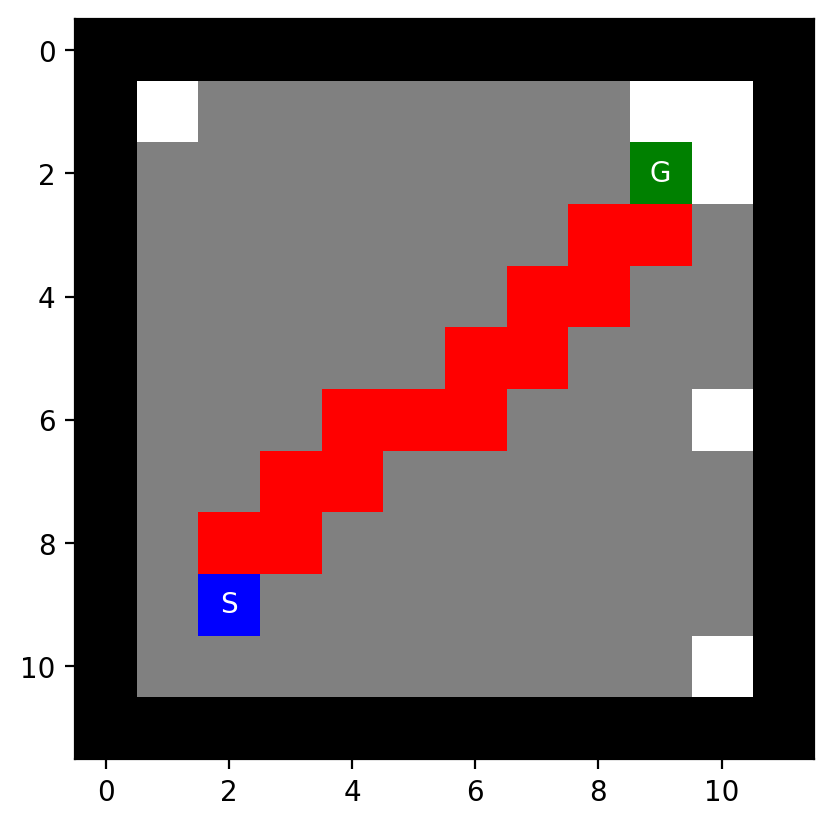

Path cost: 14
Number of nodes expanded: 94
Maximum size of the frontier: 21
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 109
this is File empty_maze.txt
 
Algorithm Name: A*-E
Type of Maze: empty_2_maze.txt


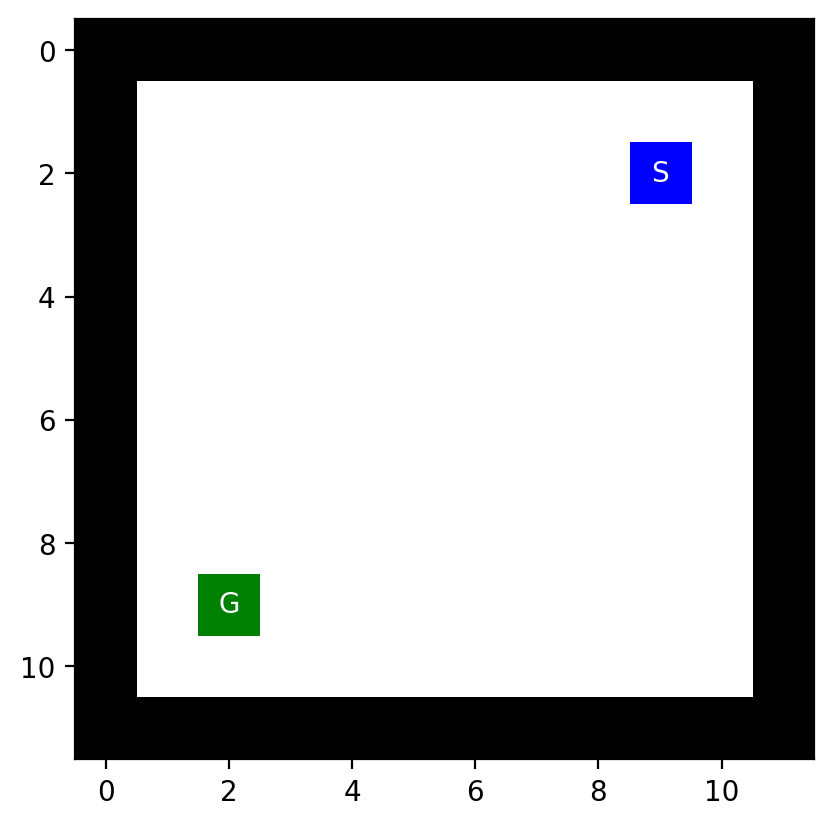

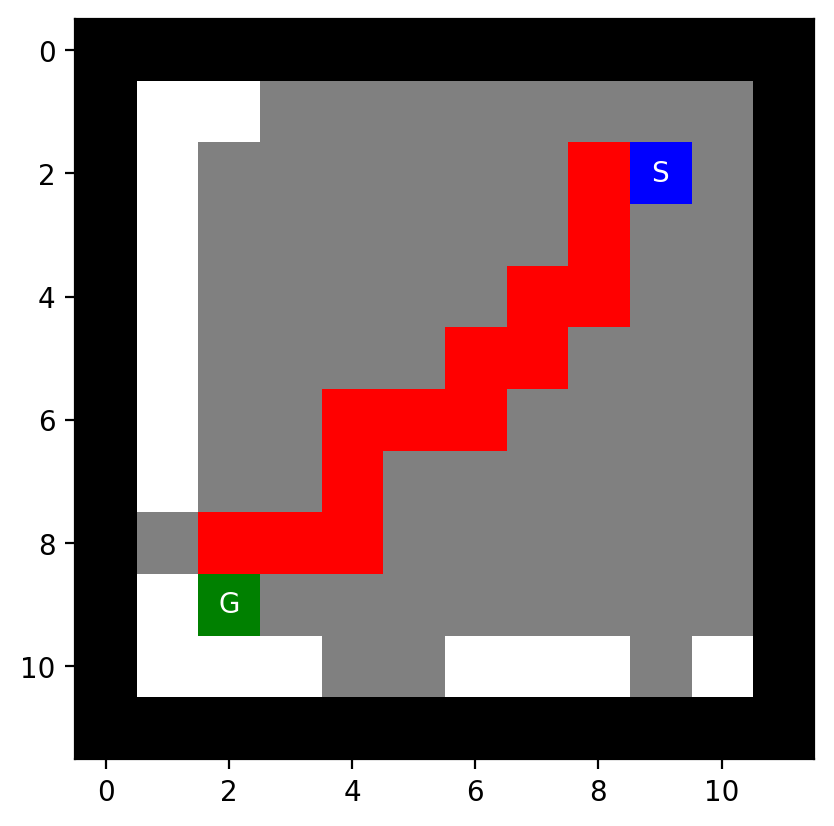

Path cost: 14
Number of nodes expanded: 84
Maximum size of the frontier: 20
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 99
this is File empty_2_maze.txt
 
Algorithm Name: A*-E
Type of Maze: wall_maze.txt


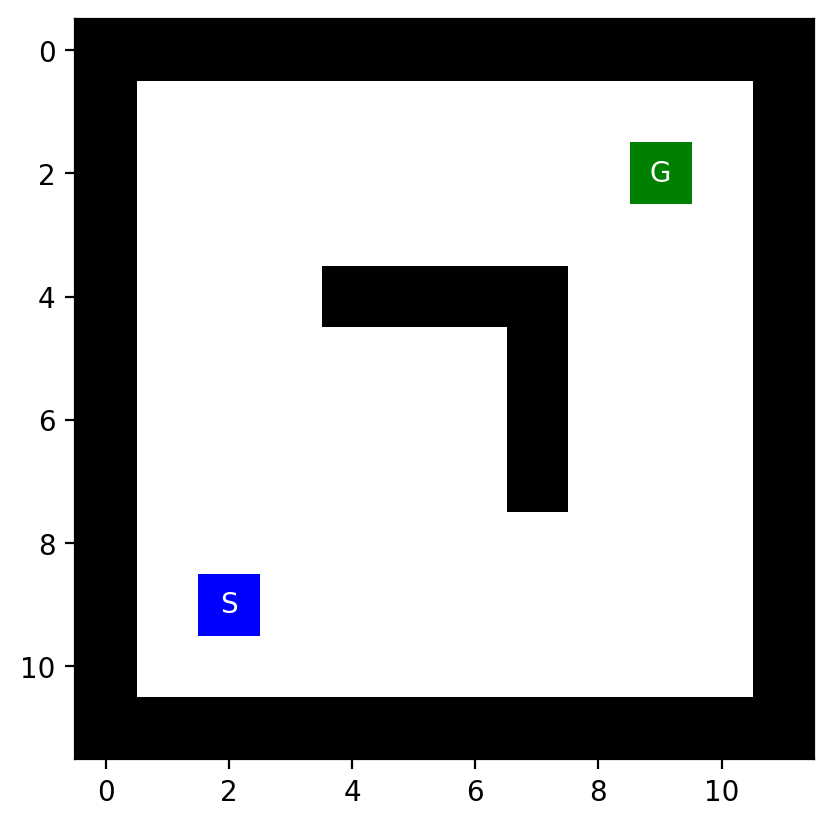

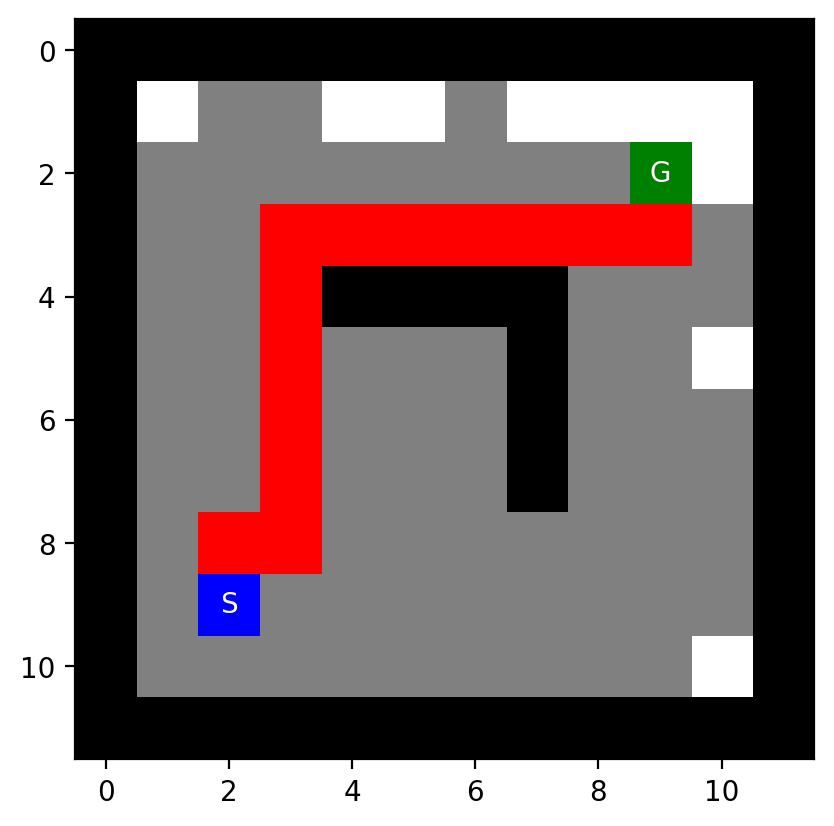

Path cost: 14
Number of nodes expanded: 83
Maximum size of the frontier: 21
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 98
this is File wall_maze.txt
 
Algorithm Name: A*-E
Type of Maze: open_maze.txt


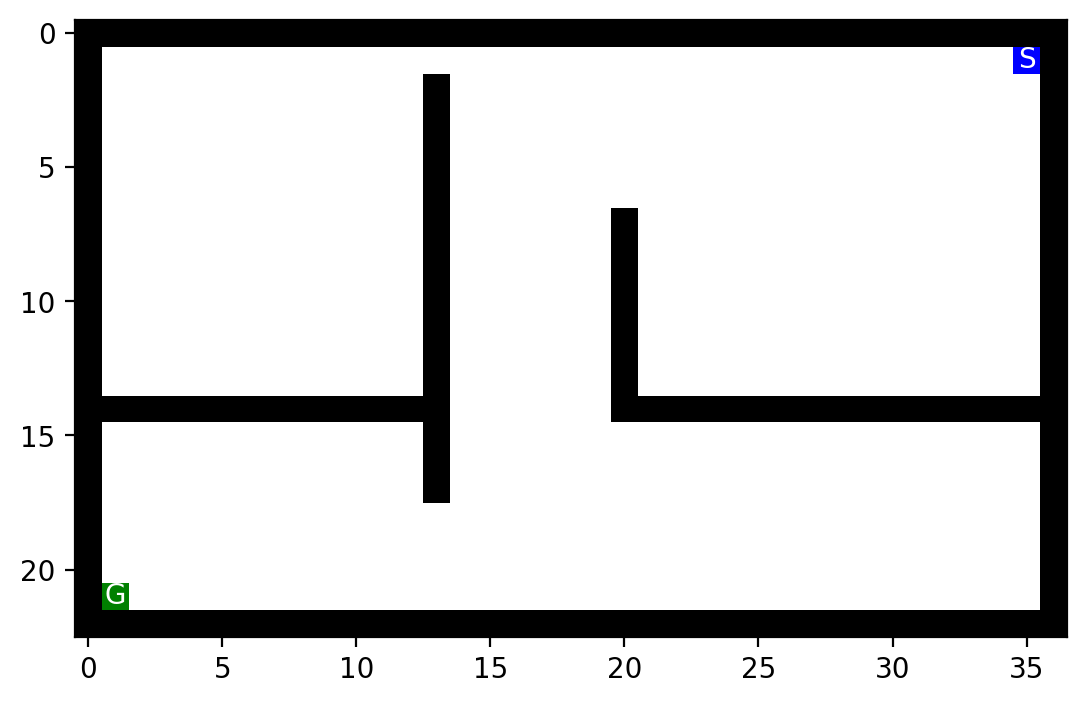

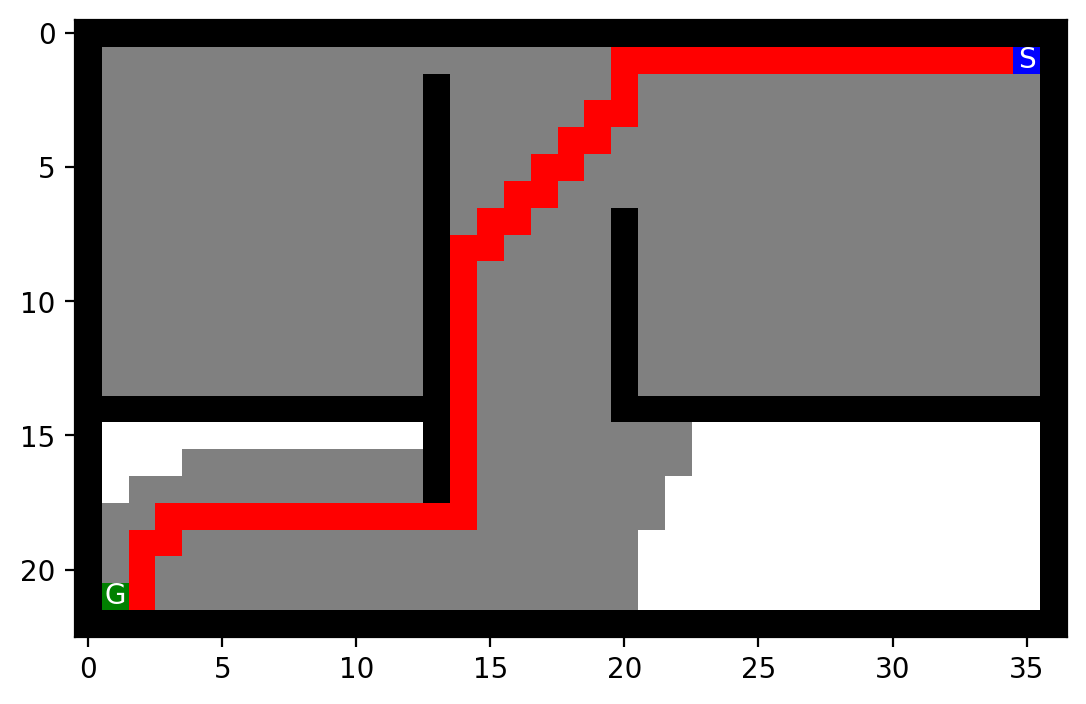

Path cost: 54
Number of nodes expanded: 569
Maximum size of the frontier: 51
Maximum Tree Depth: 54
Maximum Number of Node in Memory: 624
this is File open_maze.txt
 
Algorithm Name: A*-E
Type of Maze: loops_maze.txt


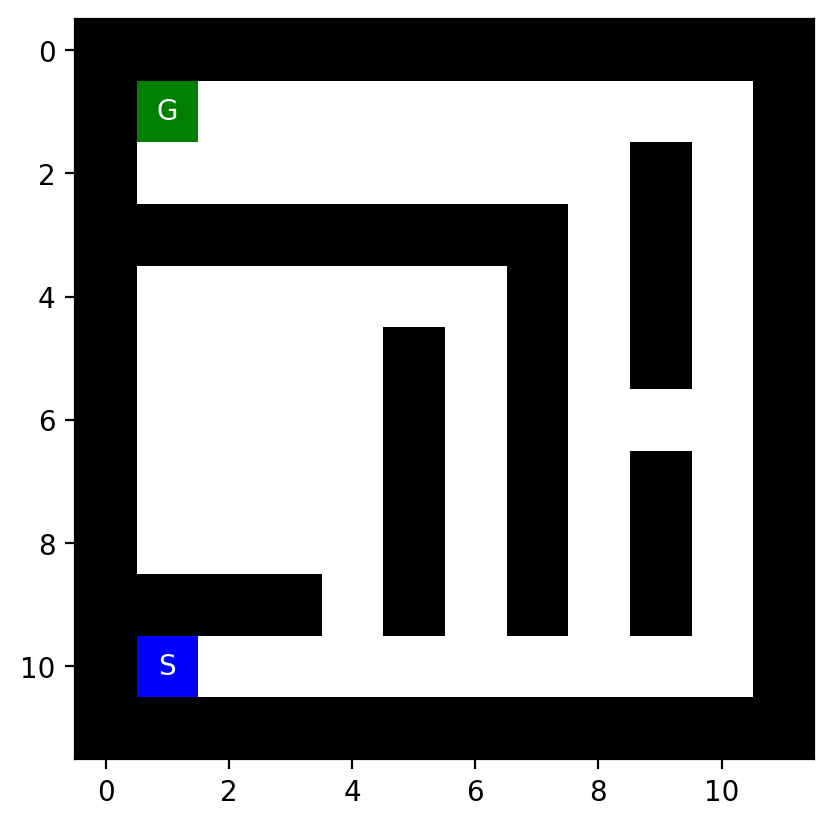

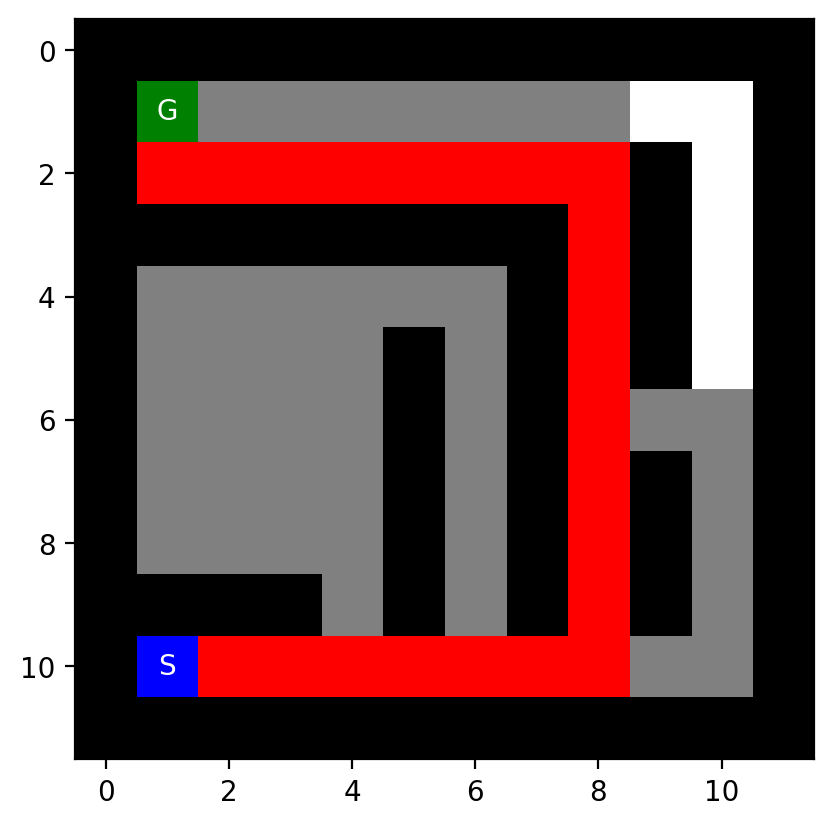

Path cost: 23
Number of nodes expanded: 66
Maximum size of the frontier: 10
Maximum Tree Depth: 23
Maximum Number of Node in Memory: 90
this is File loops_maze.txt
 
Algorithm Name: A*-E
Type of Maze: large_maze.txt


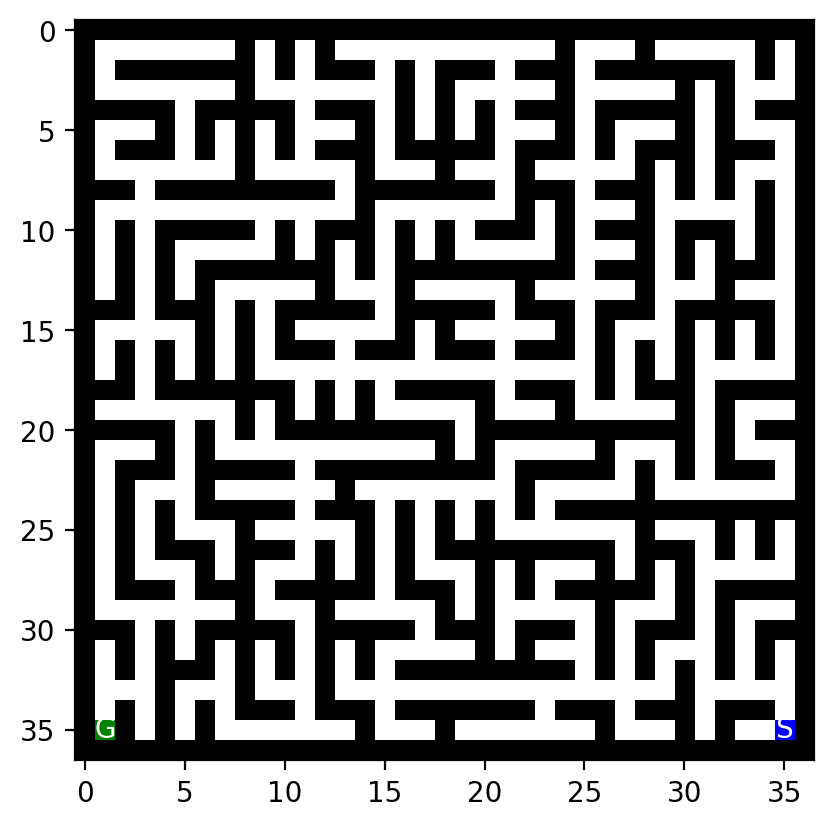

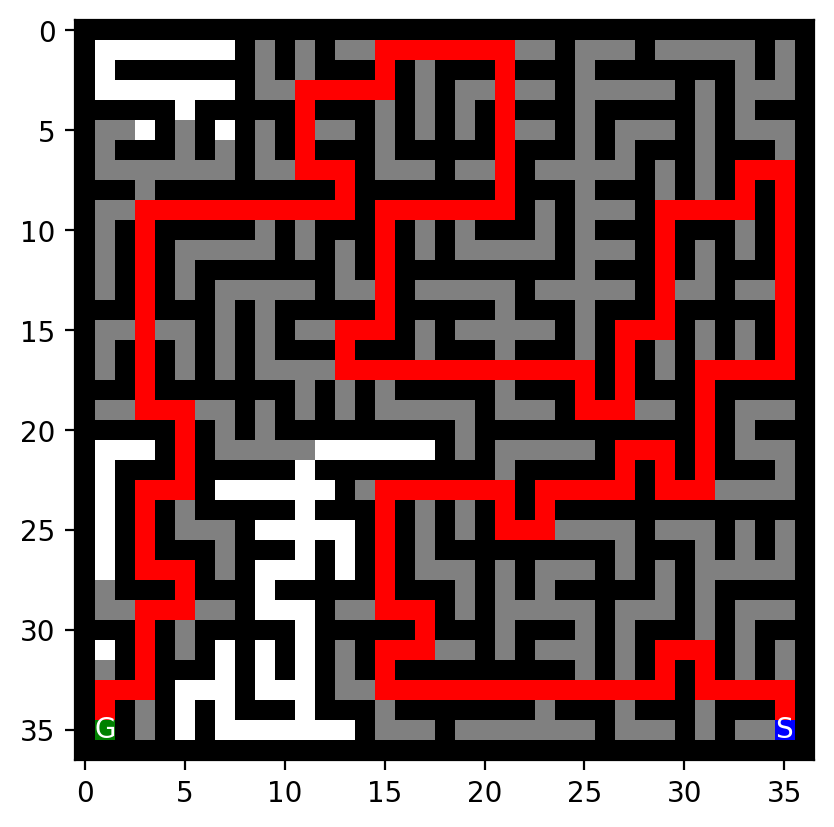

Path cost: 210
Number of nodes expanded: 566
Maximum size of the frontier: 10
Maximum Tree Depth: 210
Maximum Number of Node in Memory: 777
this is File large_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: medium_maze.txt


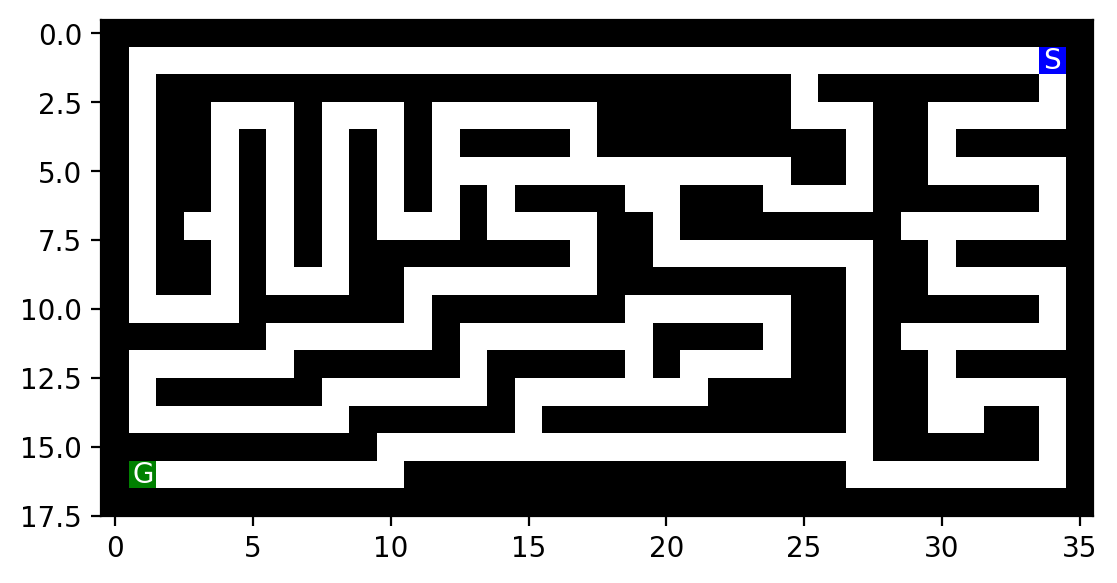

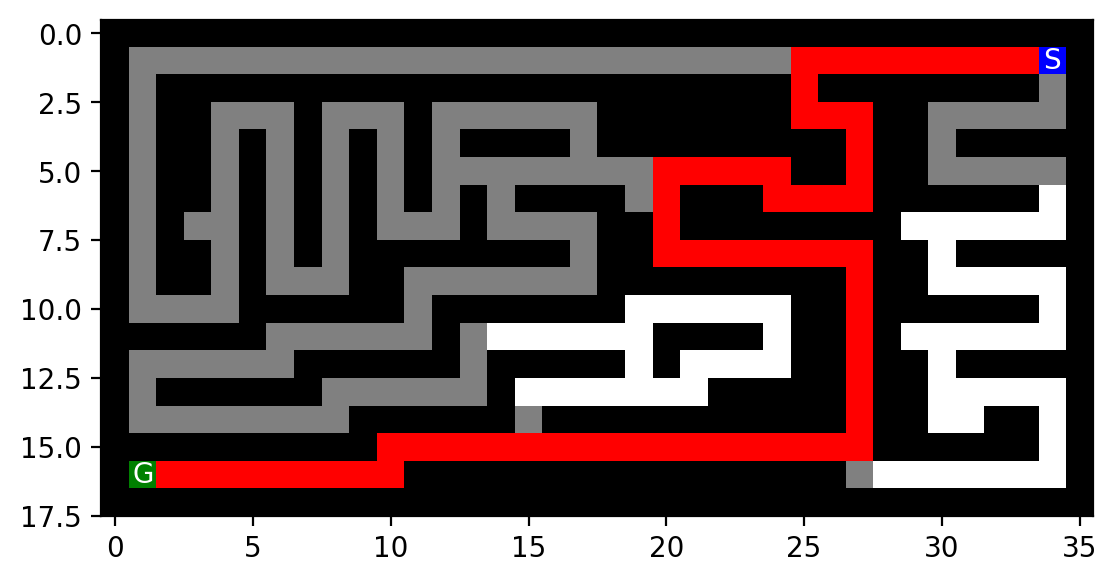

Path cost: 68
Number of nodes expanded: 212
Maximum size of the frontier: 7
Maximum Tree Depth: 73
Maximum Number of Node in Memory: 281
this is File medium_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: small_maze.txt


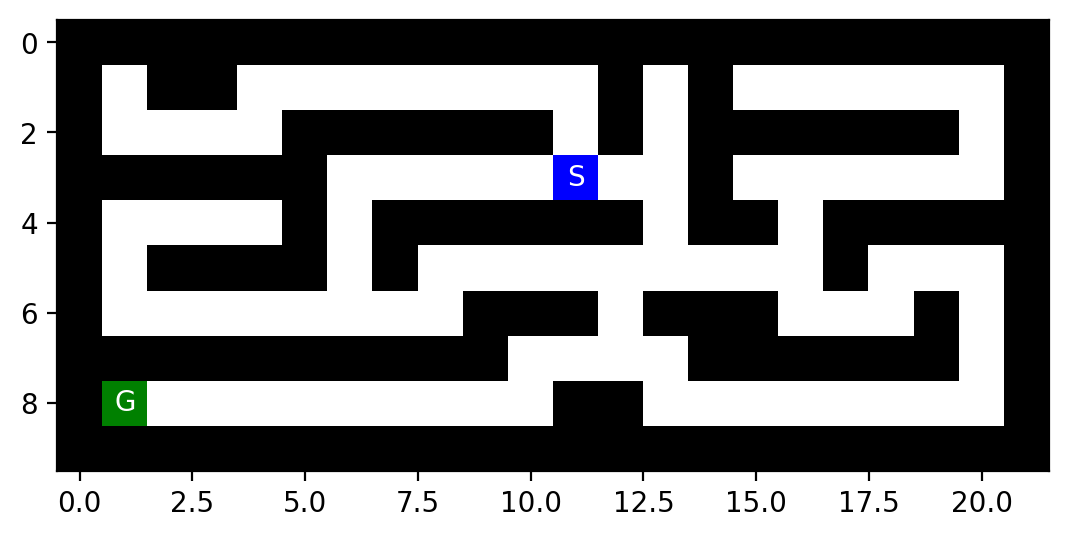

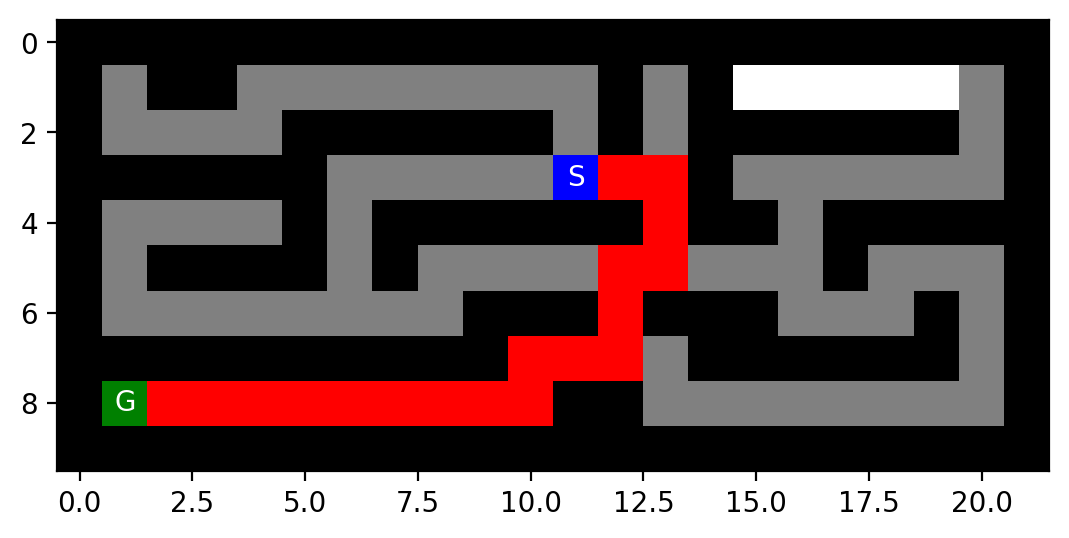

Path cost: 19
Number of nodes expanded: 89
Maximum size of the frontier: 8
Maximum Tree Depth: 19
Maximum Number of Node in Memory: 109
this is File small_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: empty_maze.txt


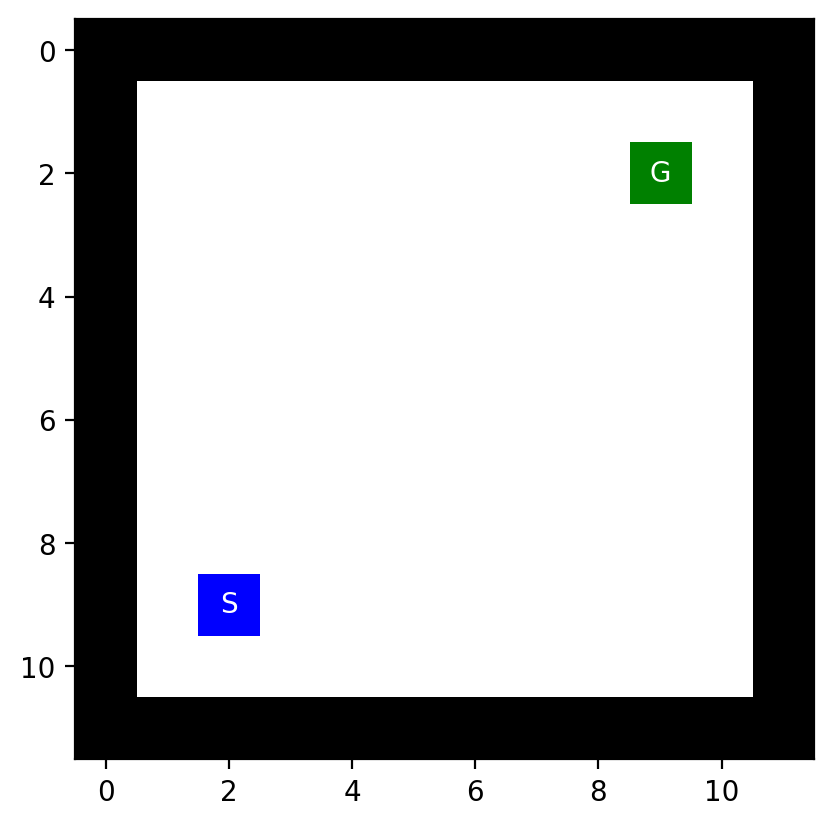

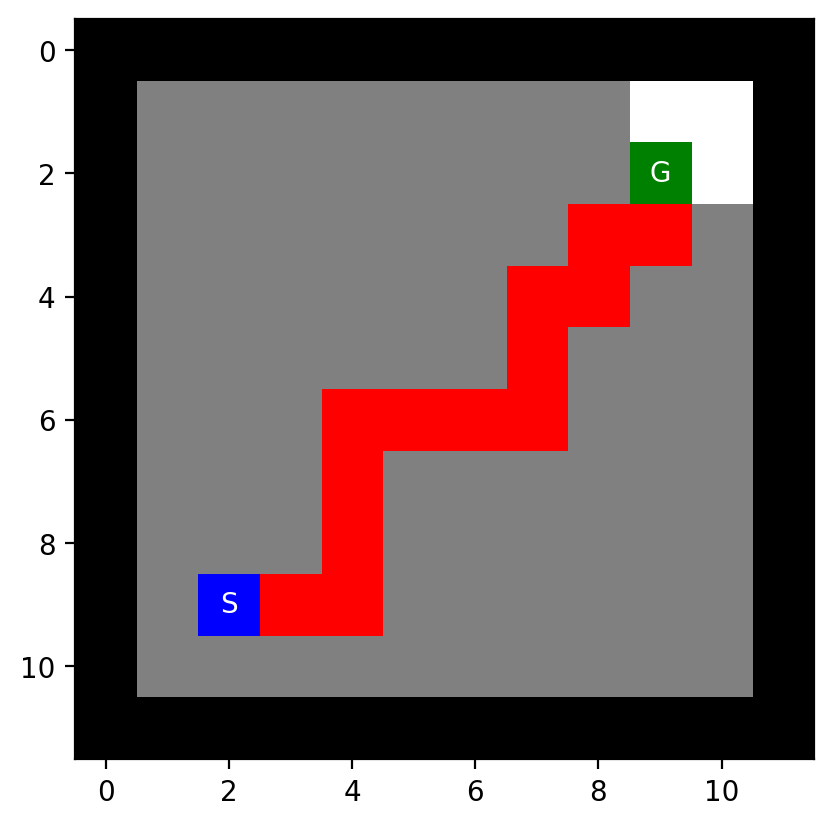

Path cost: 14
Number of nodes expanded: 97
Maximum size of the frontier: 15
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 112
this is File empty_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: empty_2_maze.txt


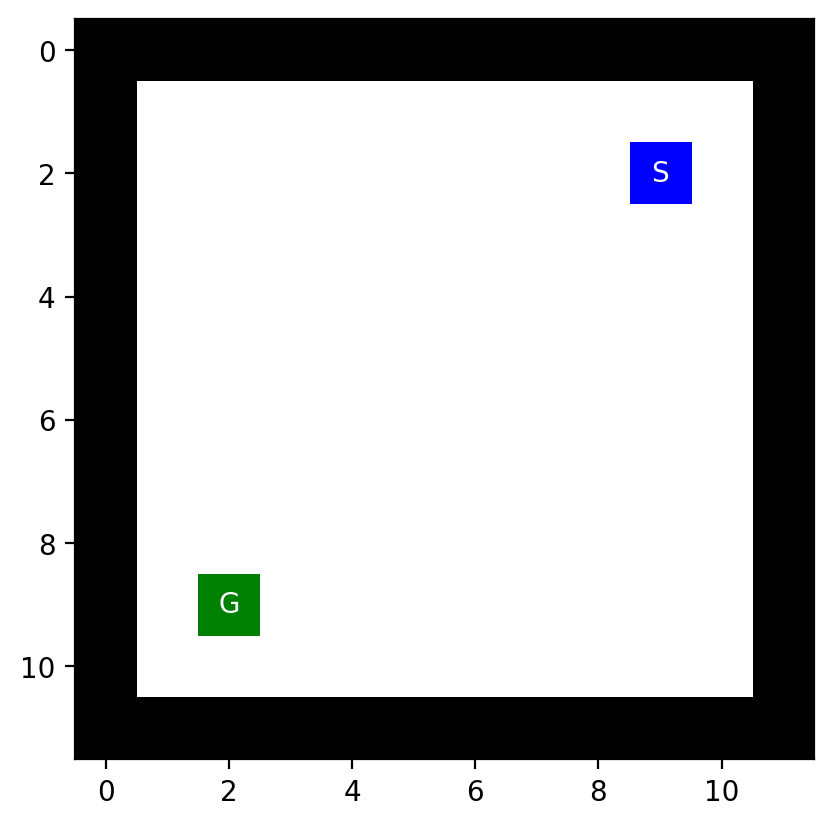

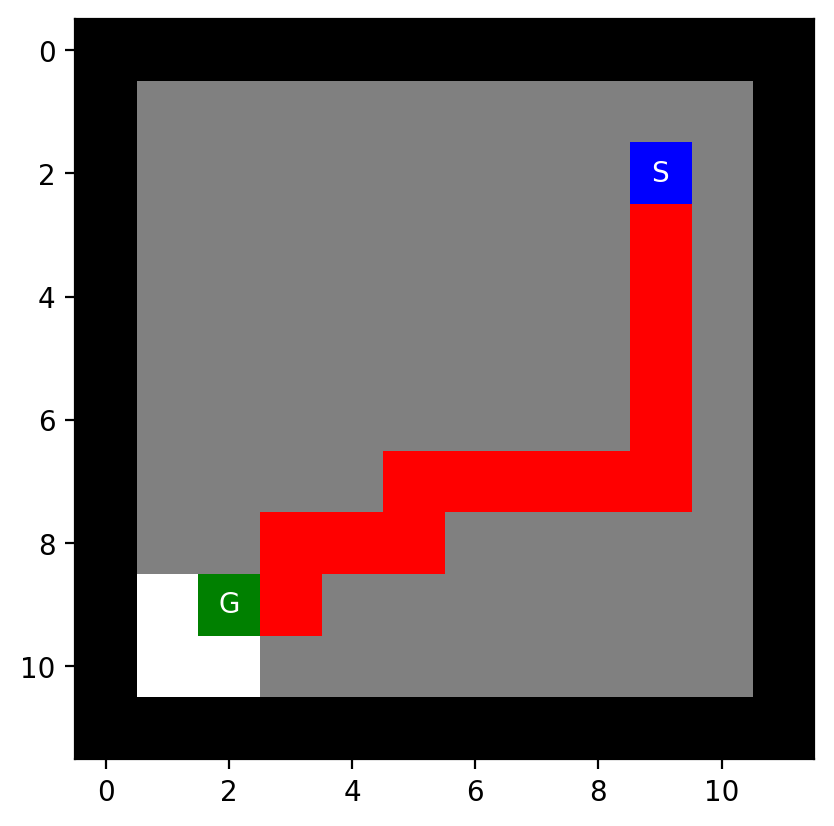

Path cost: 14
Number of nodes expanded: 97
Maximum size of the frontier: 16
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 112
this is File empty_2_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: wall_maze.txt


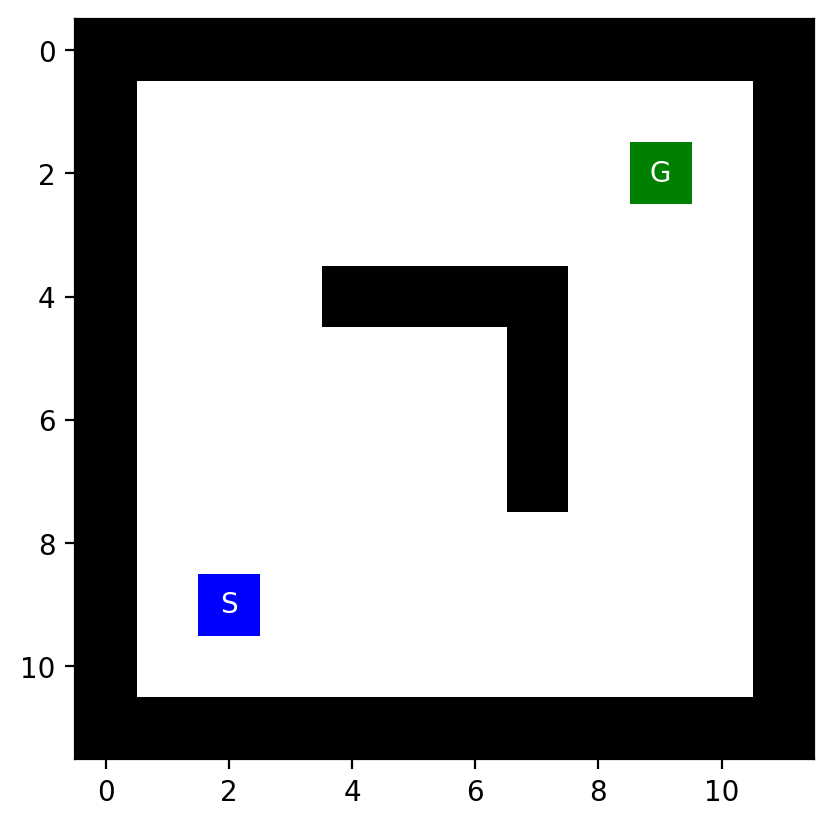

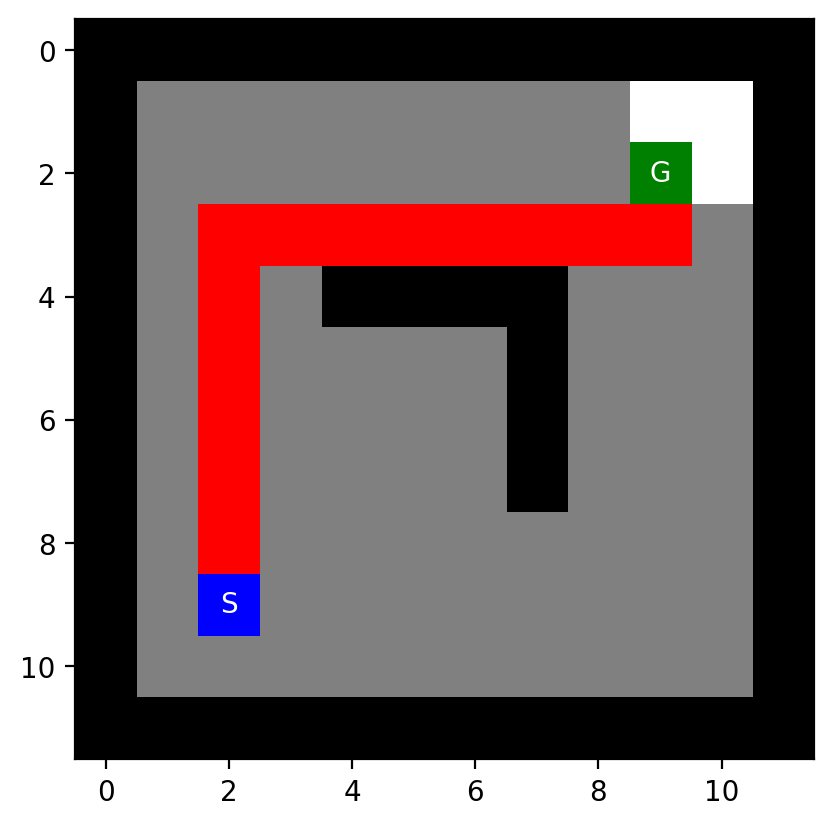

Path cost: 14
Number of nodes expanded: 90
Maximum size of the frontier: 18
Maximum Tree Depth: 14
Maximum Number of Node in Memory: 105
this is File wall_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: open_maze.txt


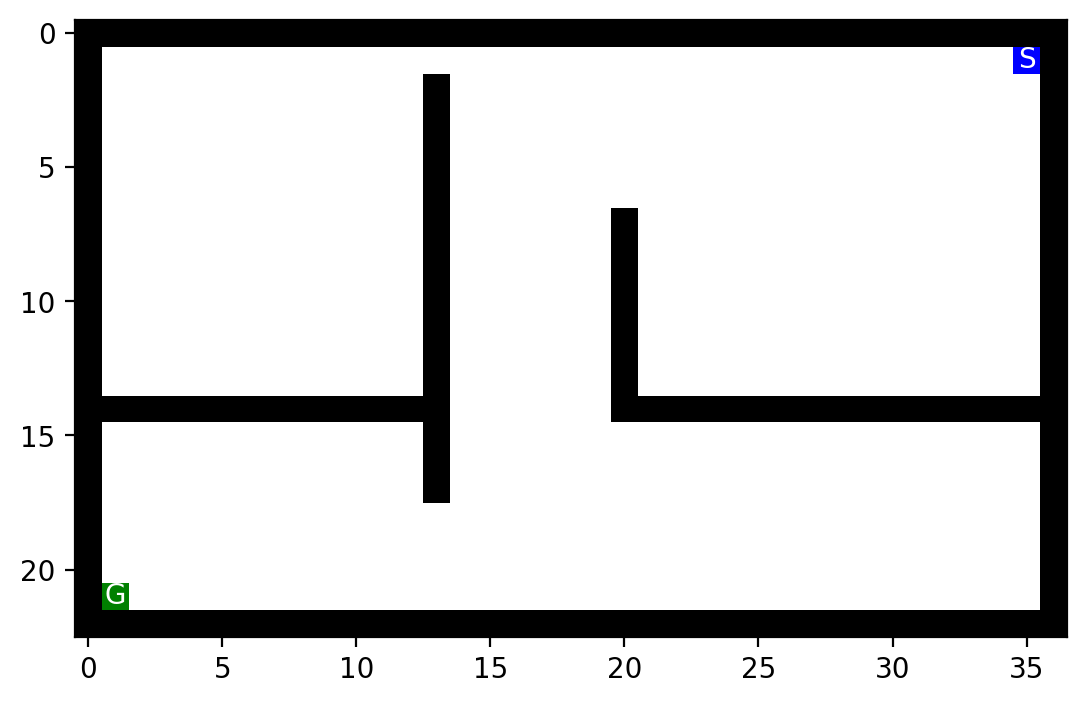

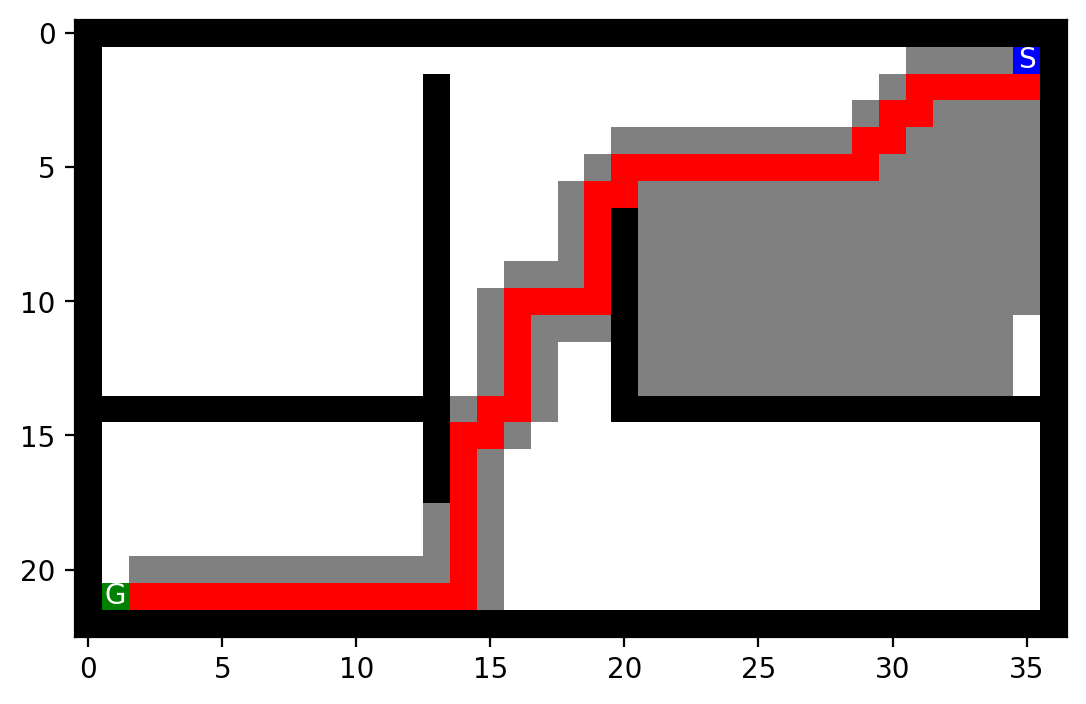

Path cost: 54
Number of nodes expanded: 241
Maximum size of the frontier: 93
Maximum Tree Depth: 54
Maximum Number of Node in Memory: 296
this is File open_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: loops_maze.txt


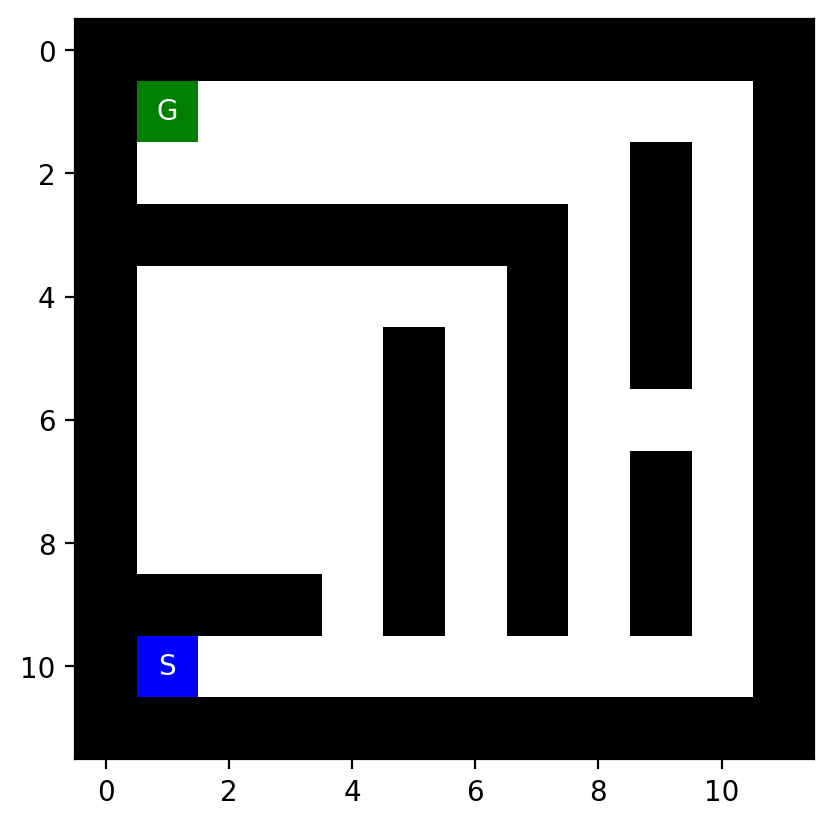

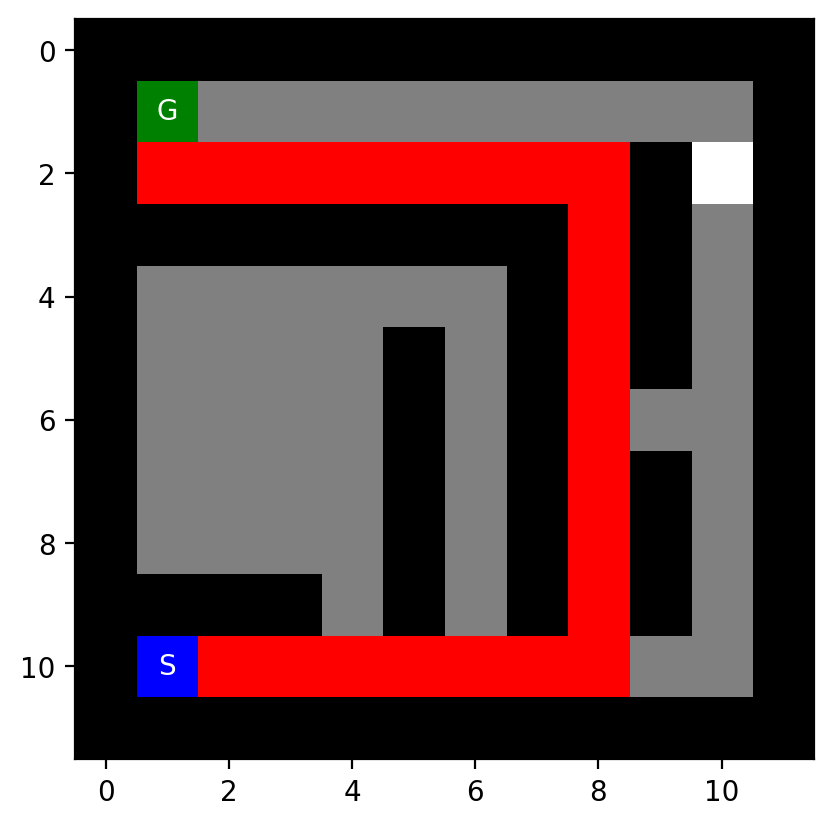

Path cost: 23
Number of nodes expanded: 71
Maximum size of the frontier: 6
Maximum Tree Depth: 23
Maximum Number of Node in Memory: 95
this is File loops_maze.txt
 
Algorithm Name: A*-M-weighted
Type of Maze: large_maze.txt


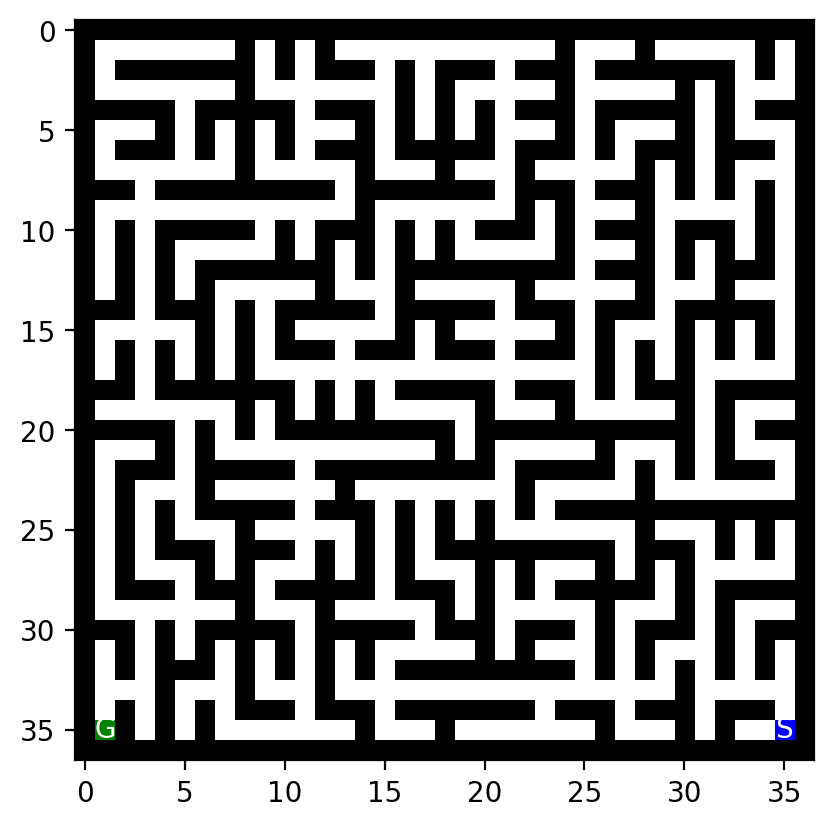

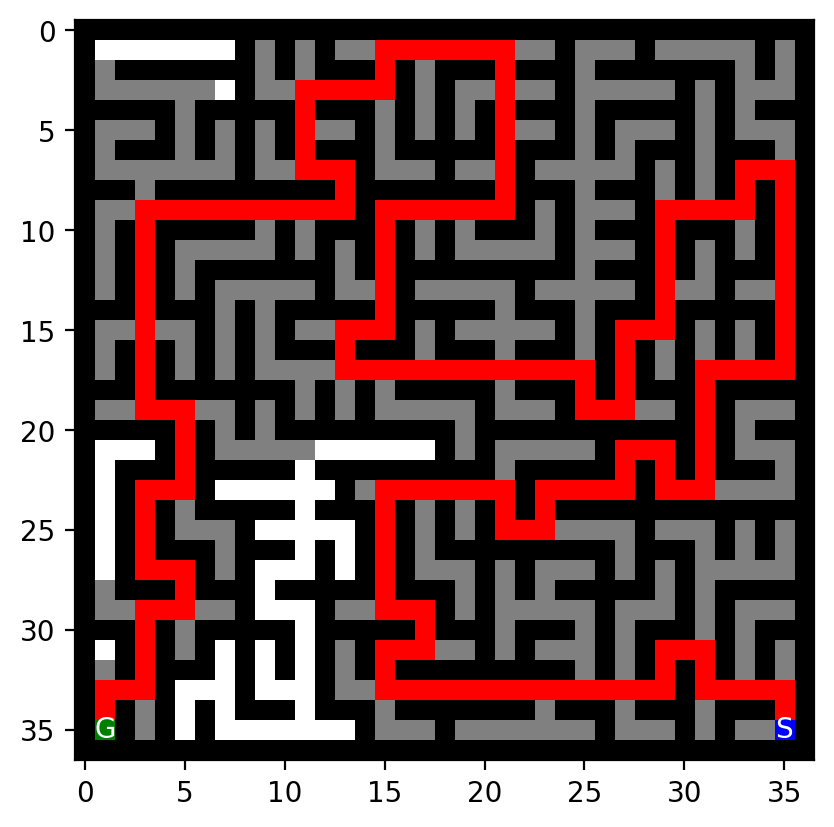

Path cost: 210
Number of nodes expanded: 576
Maximum size of the frontier: 10
Maximum Tree Depth: 210
Maximum Number of Node in Memory: 787
this is File large_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: medium_maze.txt


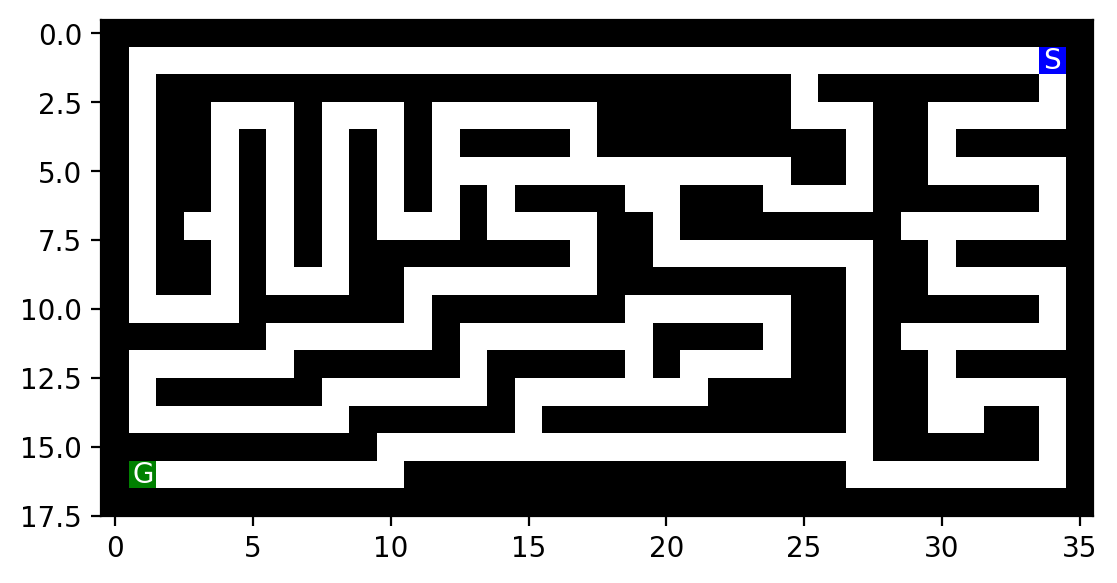

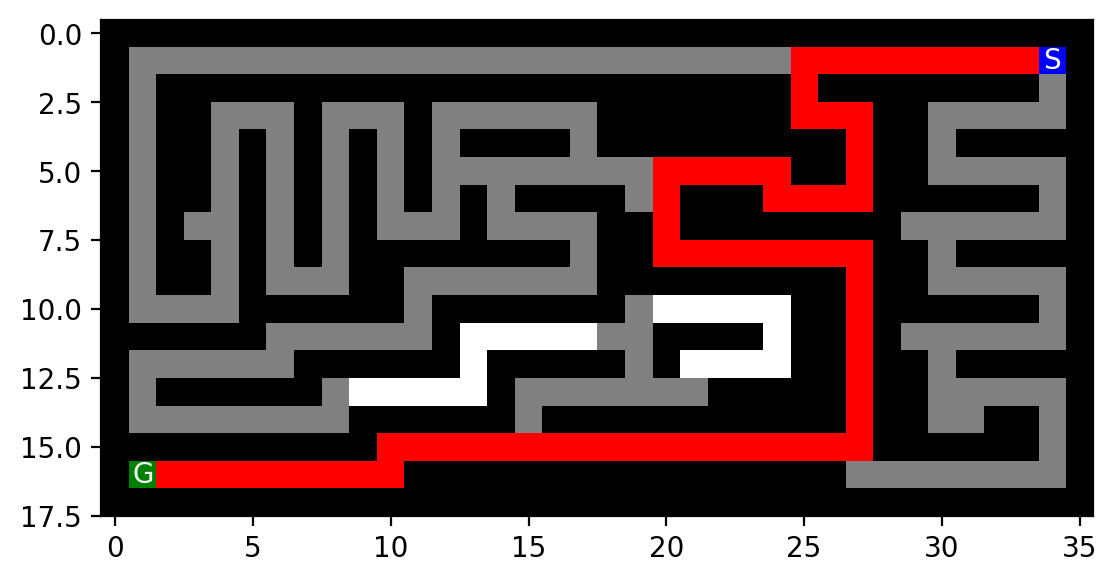

this is File medium_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: small_maze.txt


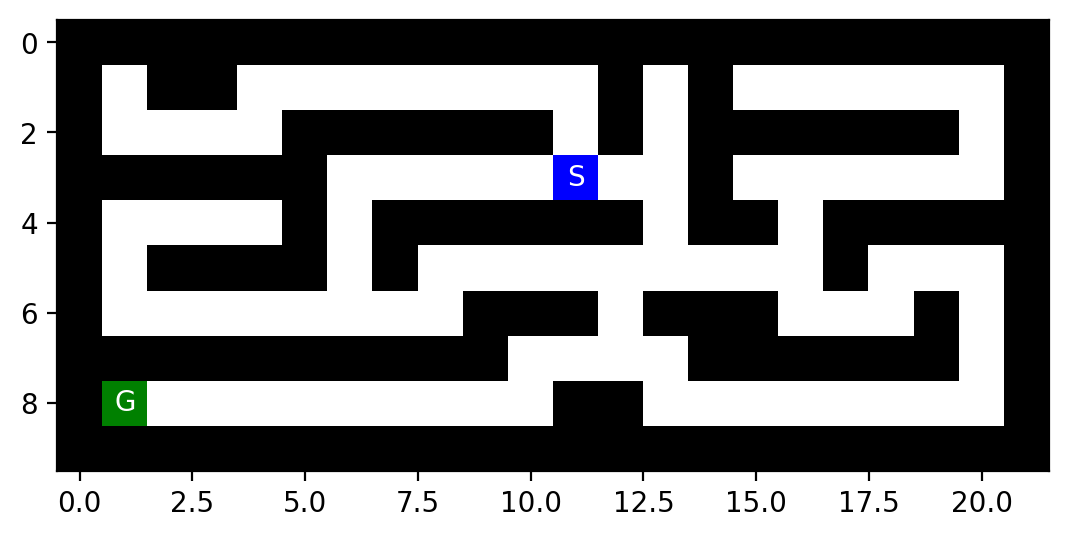

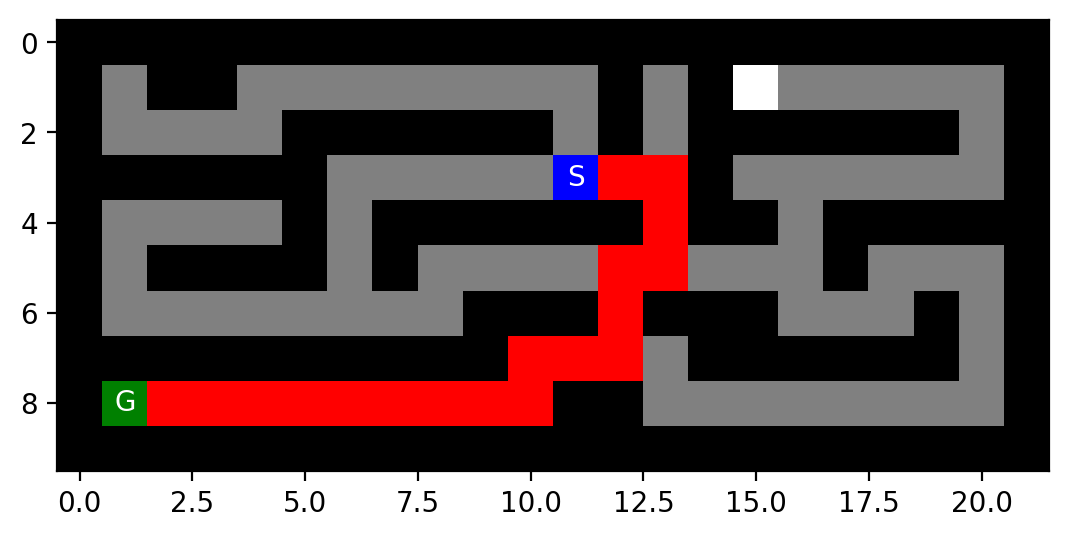

this is File small_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: empty_maze.txt


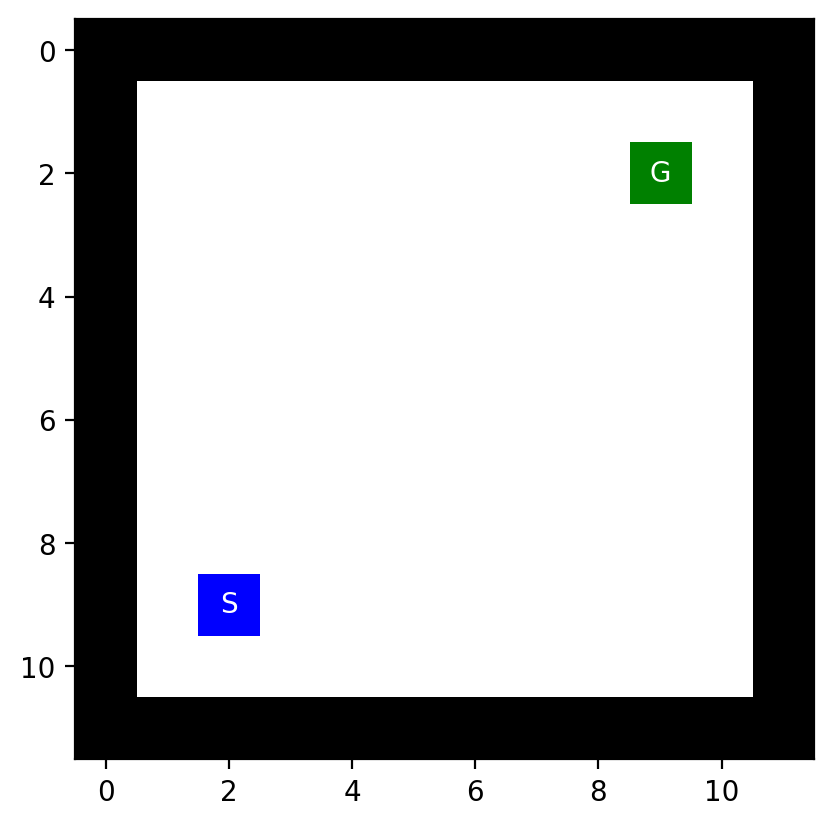

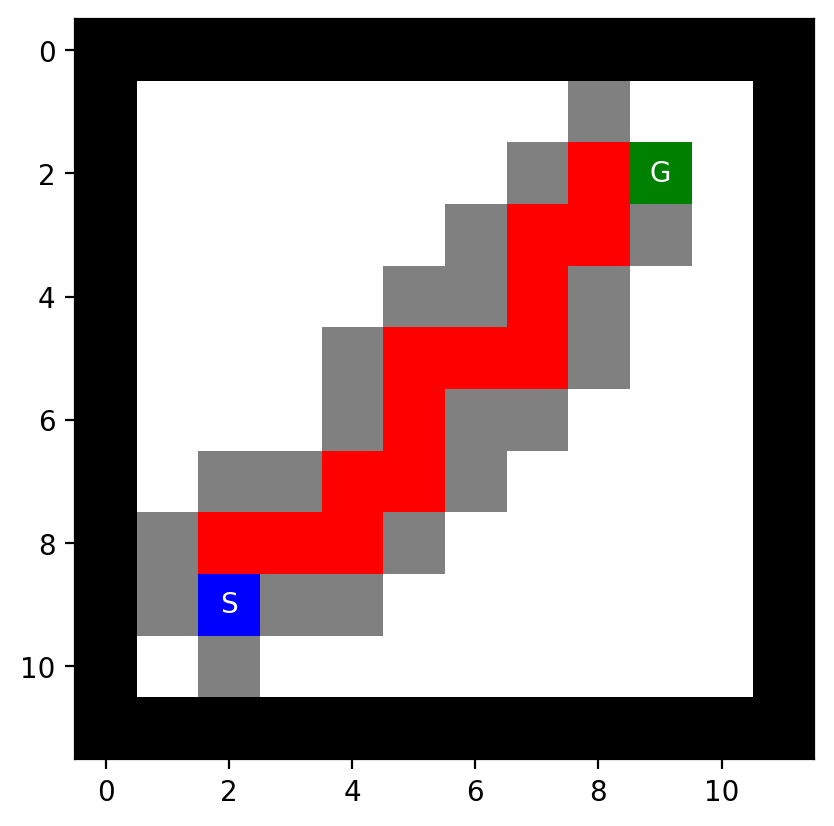

this is File empty_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: empty_2_maze.txt


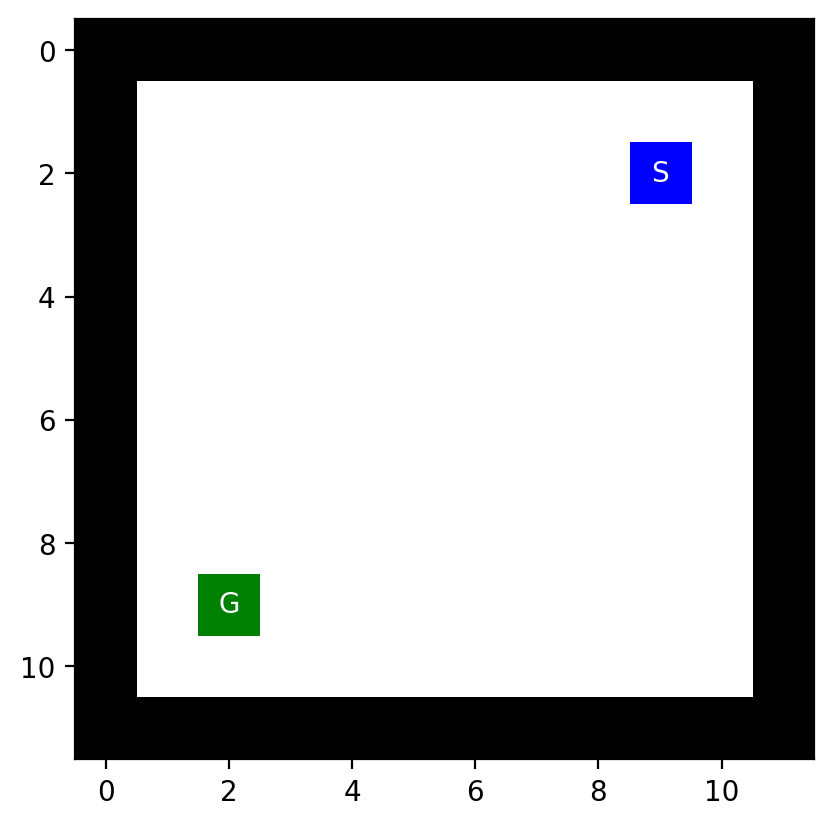

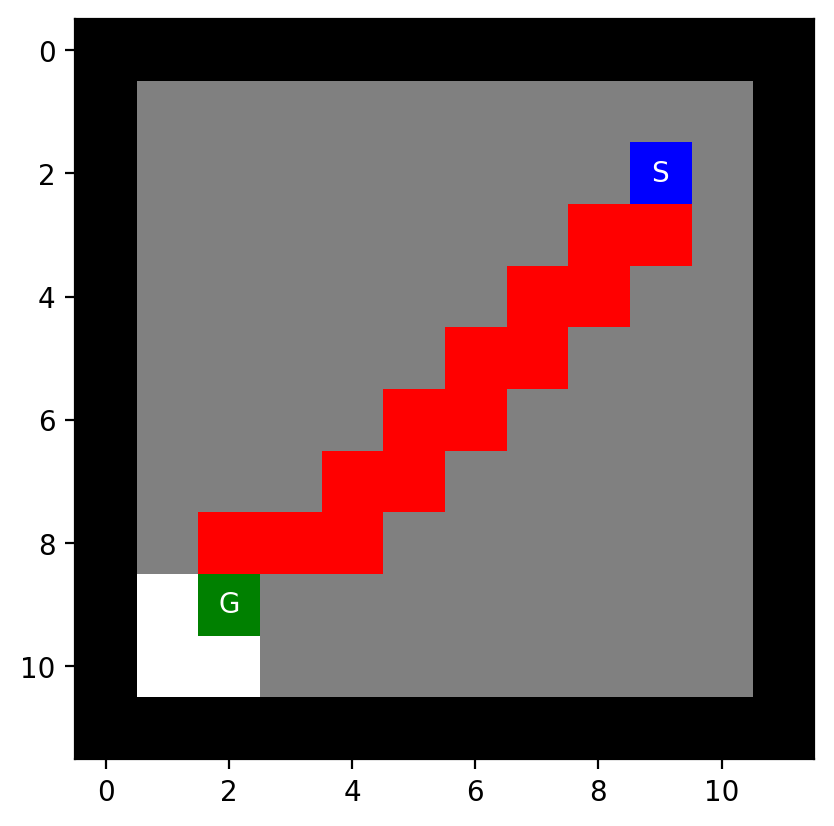

this is File empty_2_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: wall_maze.txt


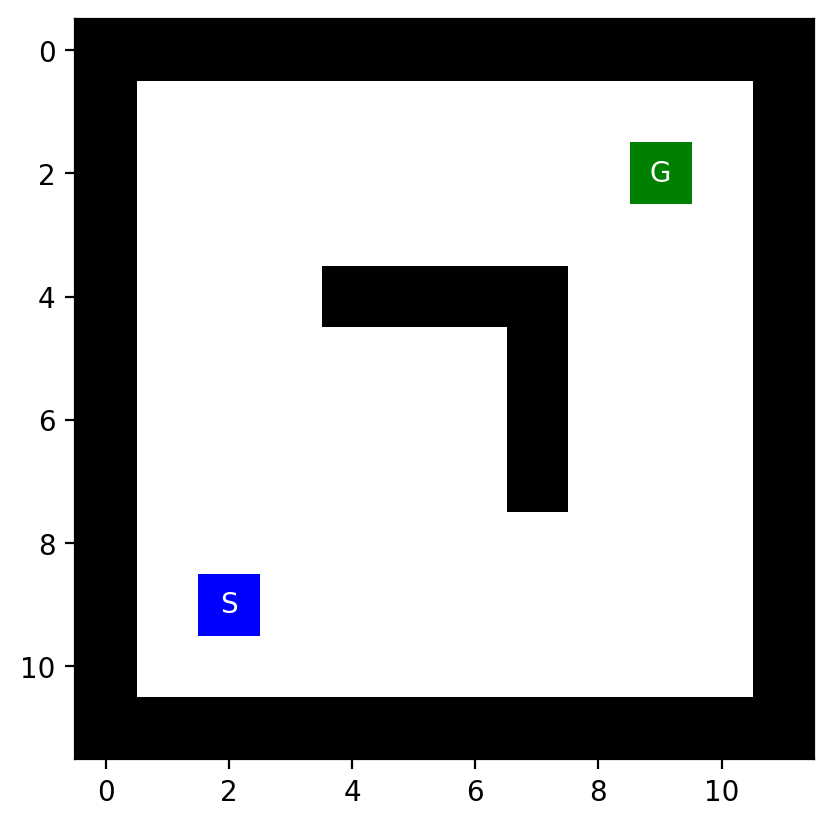

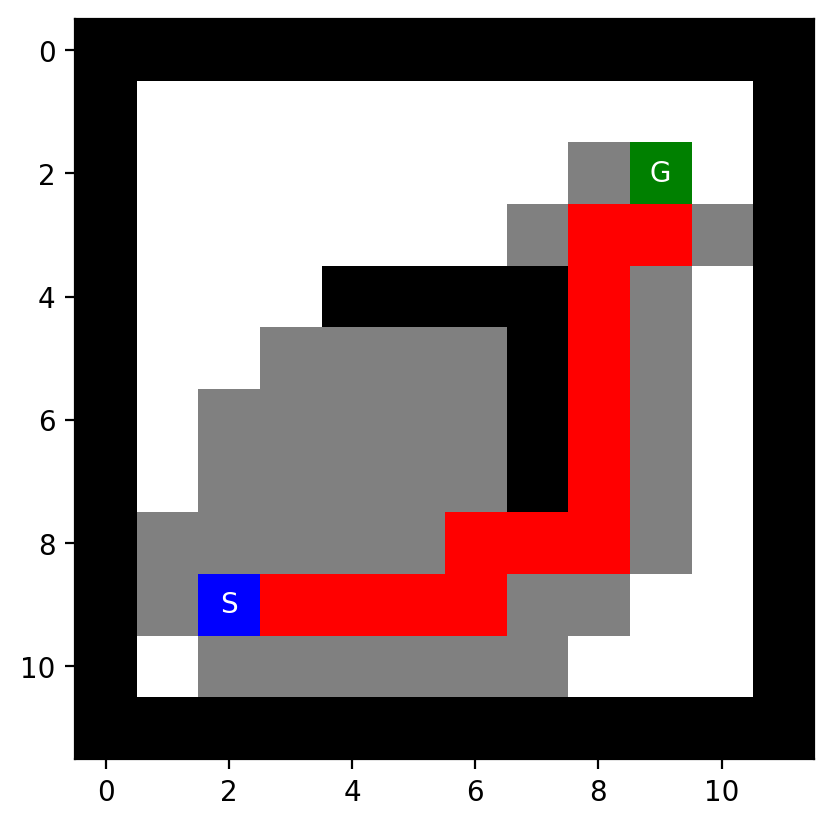

this is File wall_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: open_maze.txt


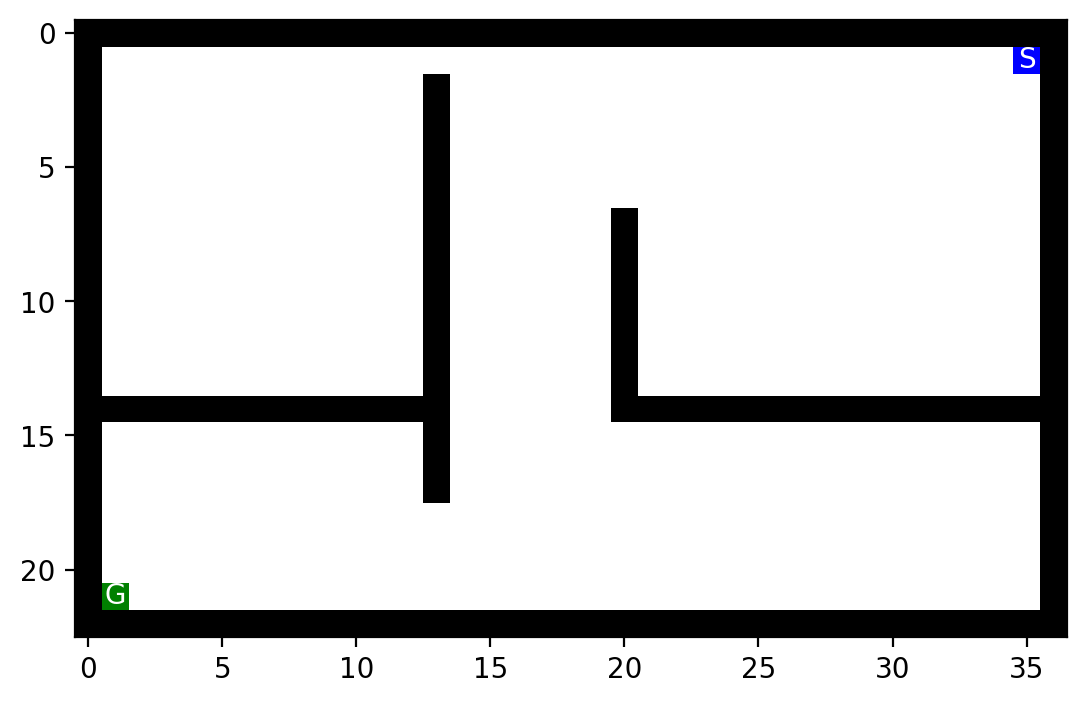

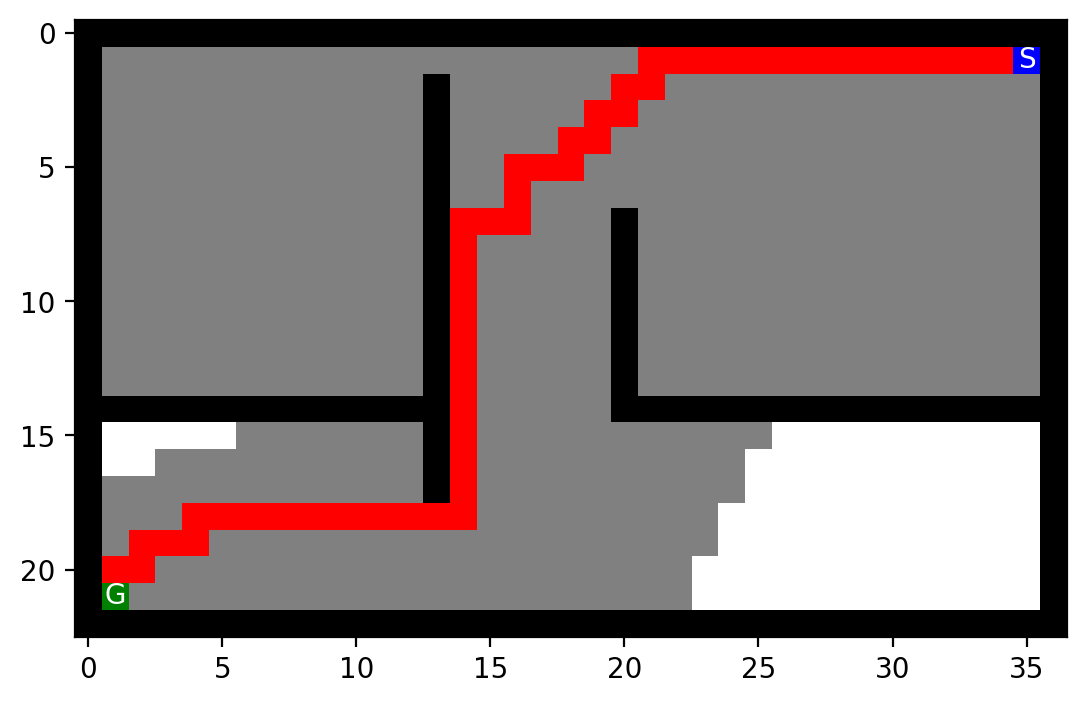

this is File open_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: loops_maze.txt


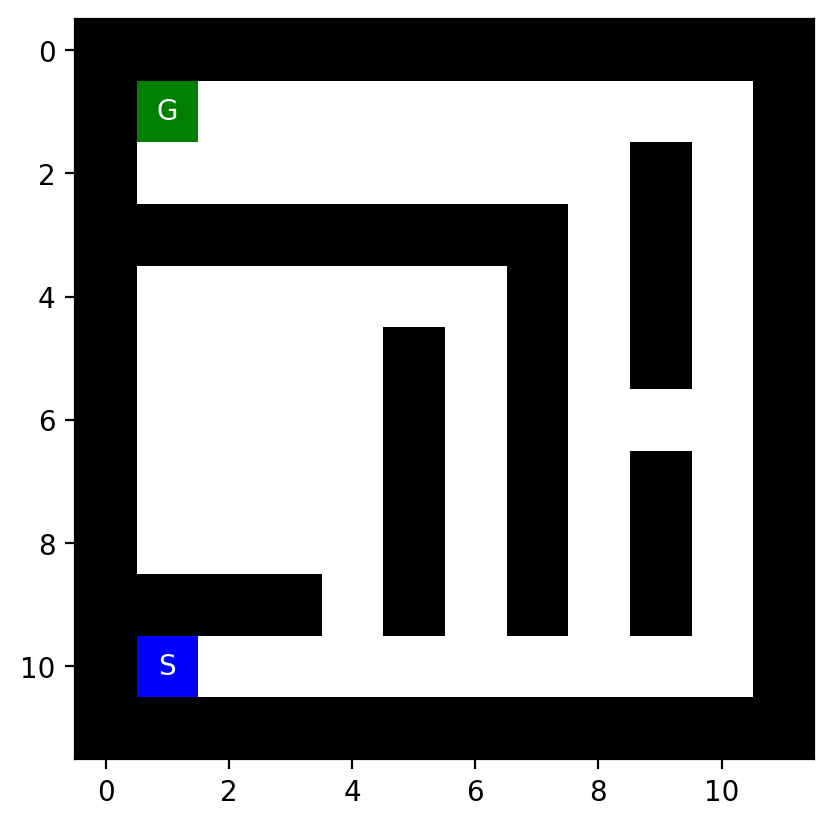

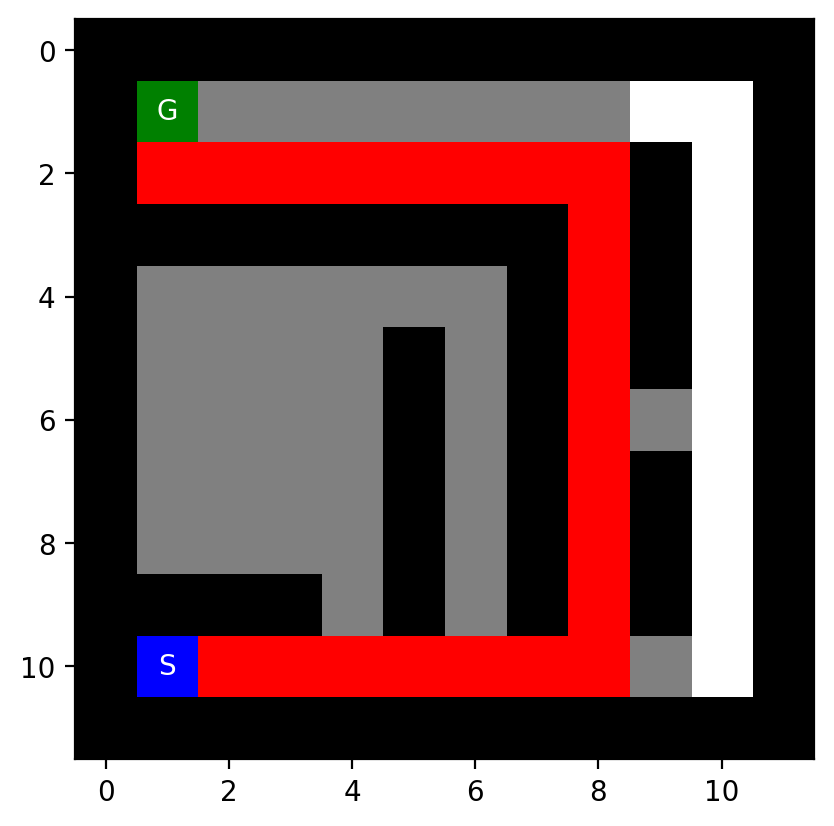

this is File loops_maze.txt
 
Algorithm Name: A*-E-weighted
Type of Maze: large_maze.txt


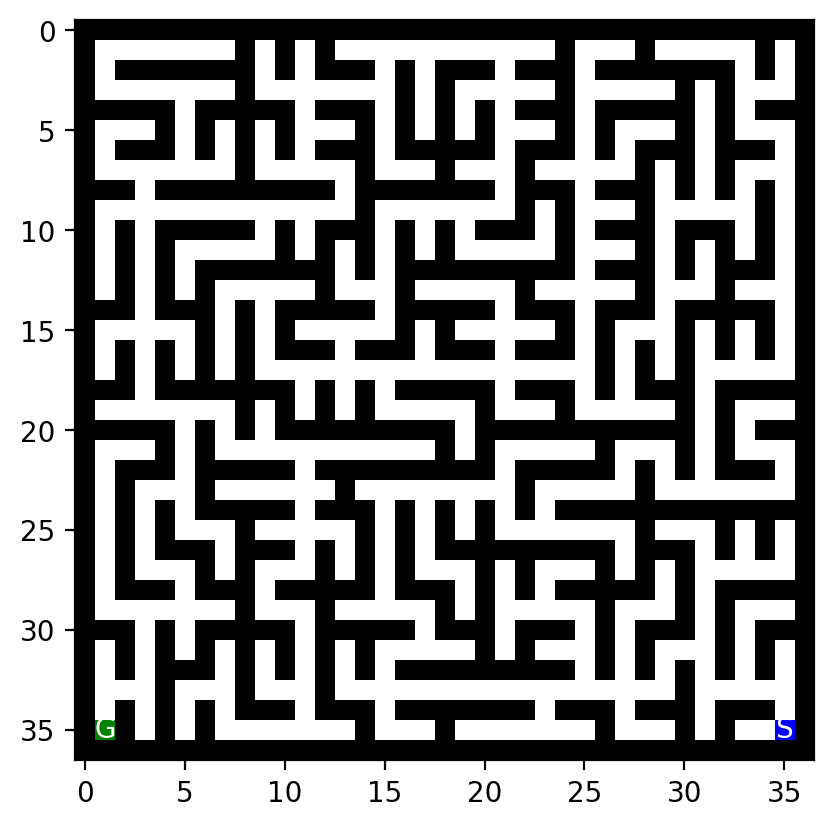

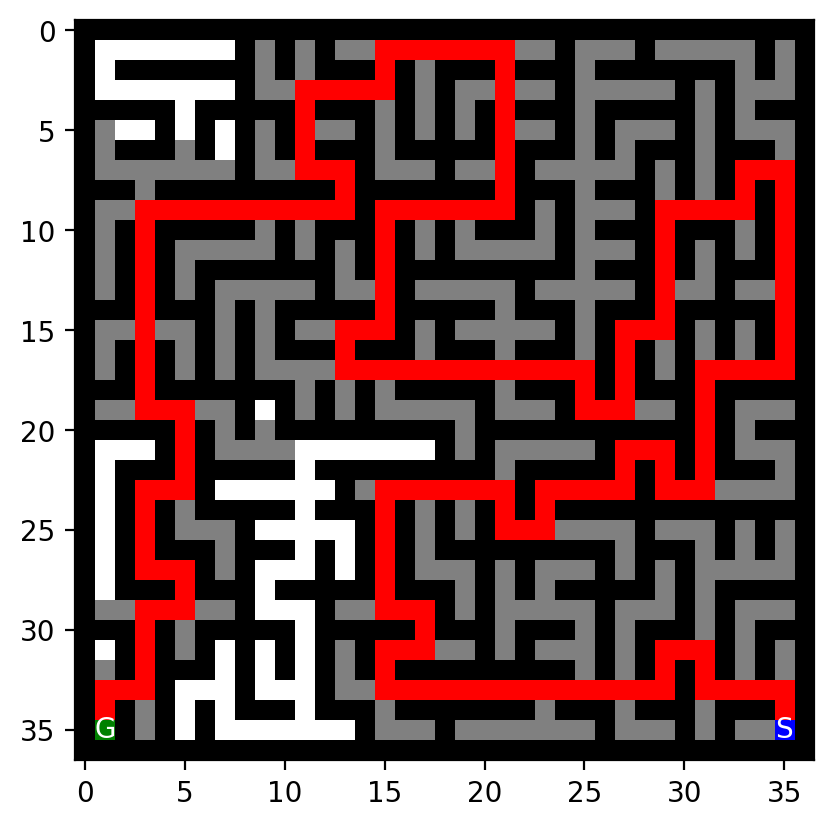

this is File large_maze.txt
 
Algorithm Name: IDS
Type of Maze: medium_maze.txt


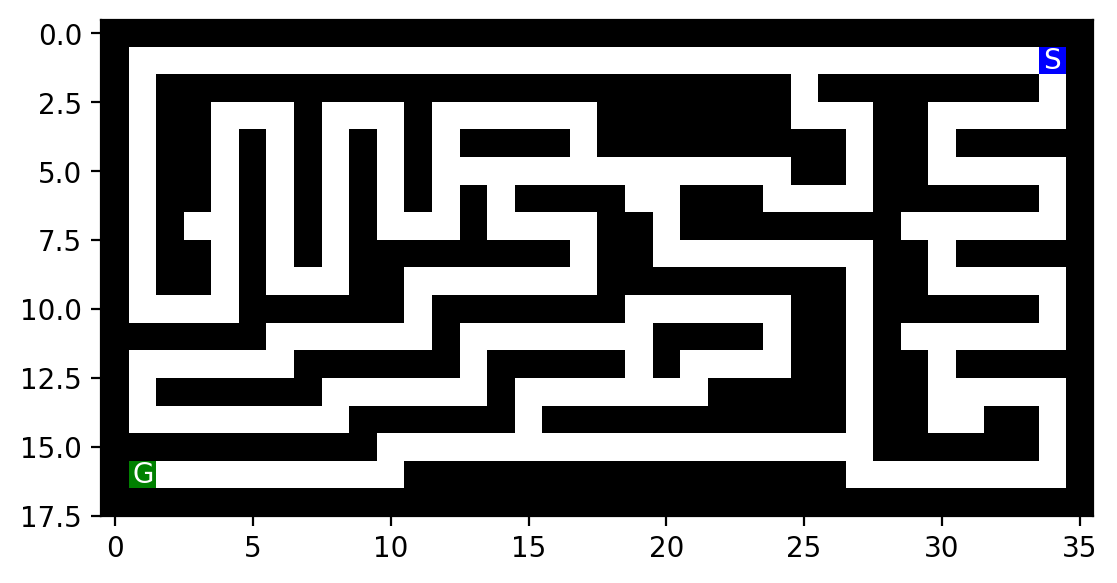

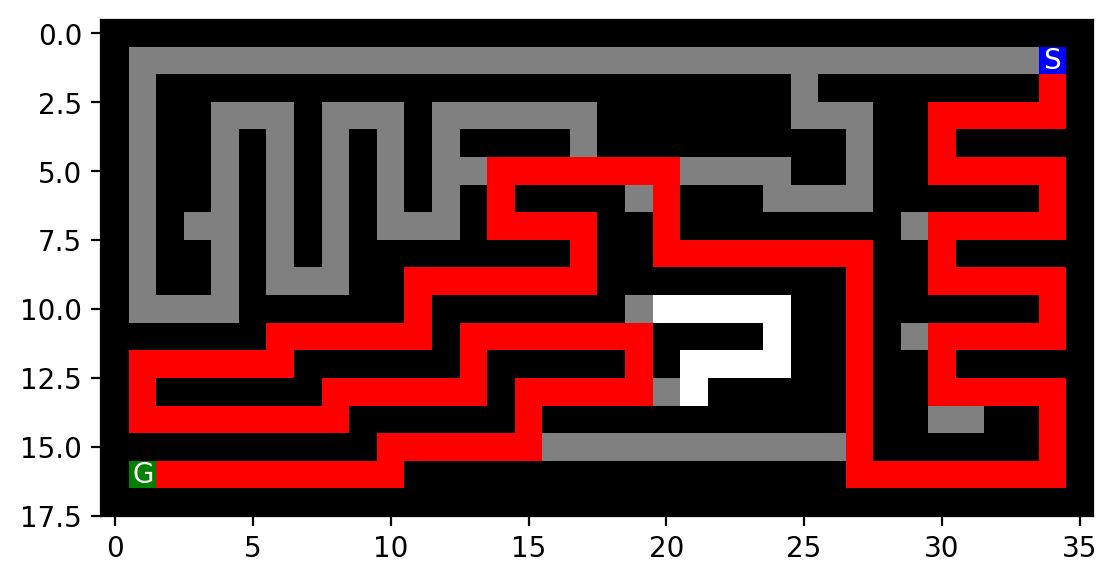

Path cost: 142
Number of nodes expanded: 263
Maximum size of the frontier: 13
Maximum Tree Depth: 155
this is File medium_maze.txt
 
Algorithm Name: IDS
Type of Maze: small_maze.txt


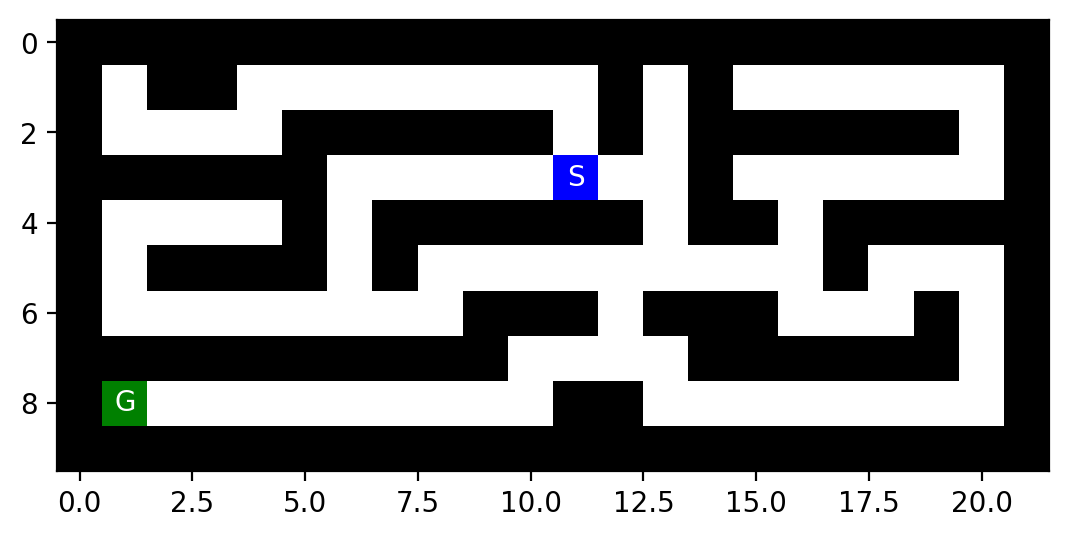

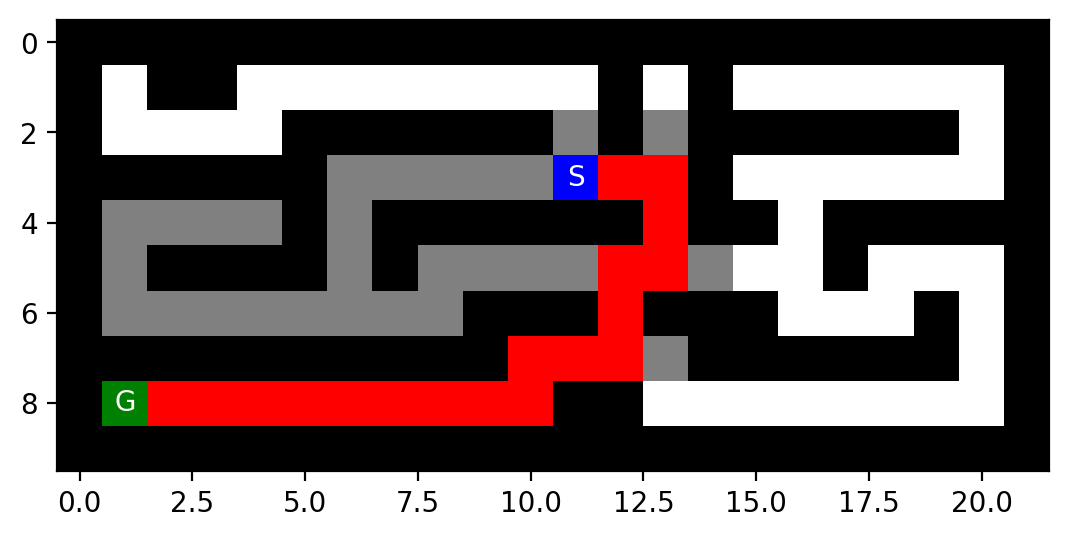

Path cost: 19
Number of nodes expanded: 48
Maximum size of the frontier: 7
Maximum Tree Depth: 23
this is File small_maze.txt
 
Algorithm Name: IDS
Type of Maze: empty_maze.txt


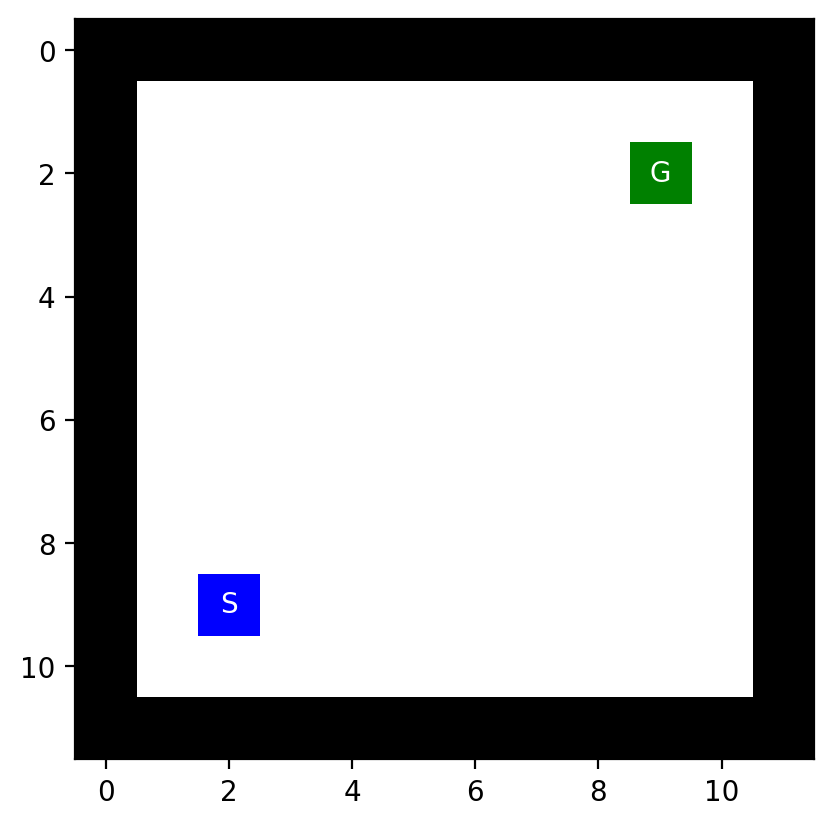

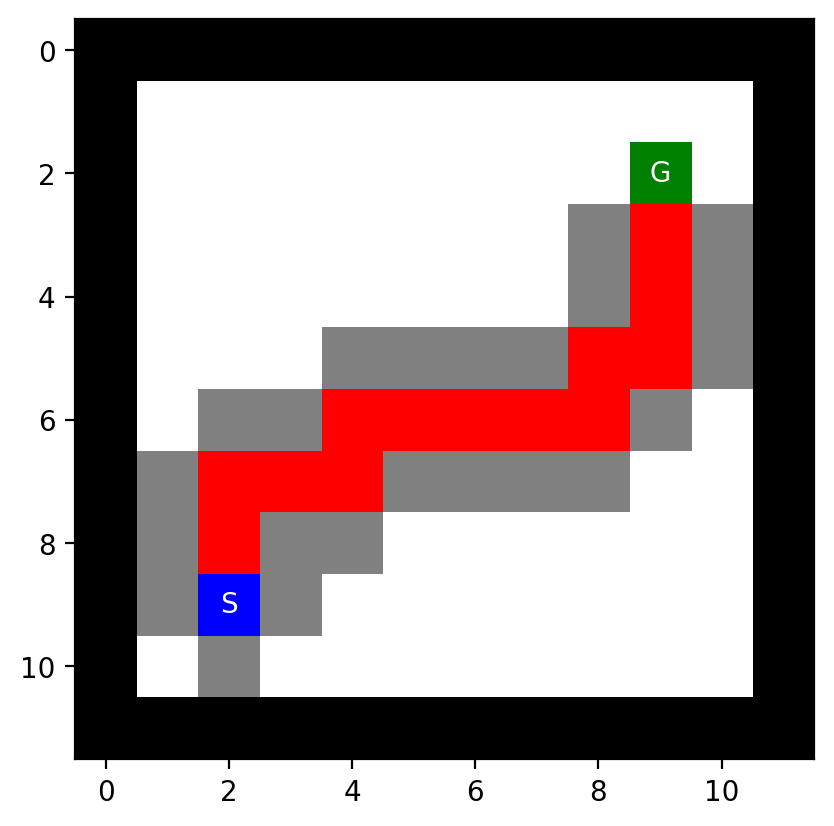

Path cost: 14
Number of nodes expanded: 38
Maximum size of the frontier: 24
Maximum Tree Depth: 14
this is File empty_maze.txt
 
Algorithm Name: IDS
Type of Maze: empty_2_maze.txt


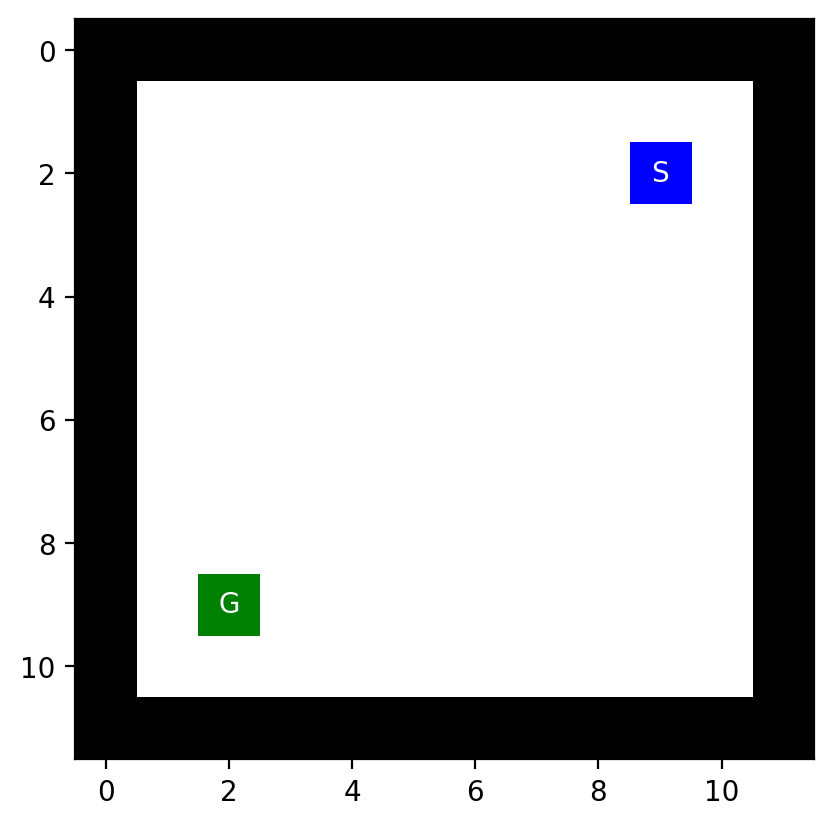

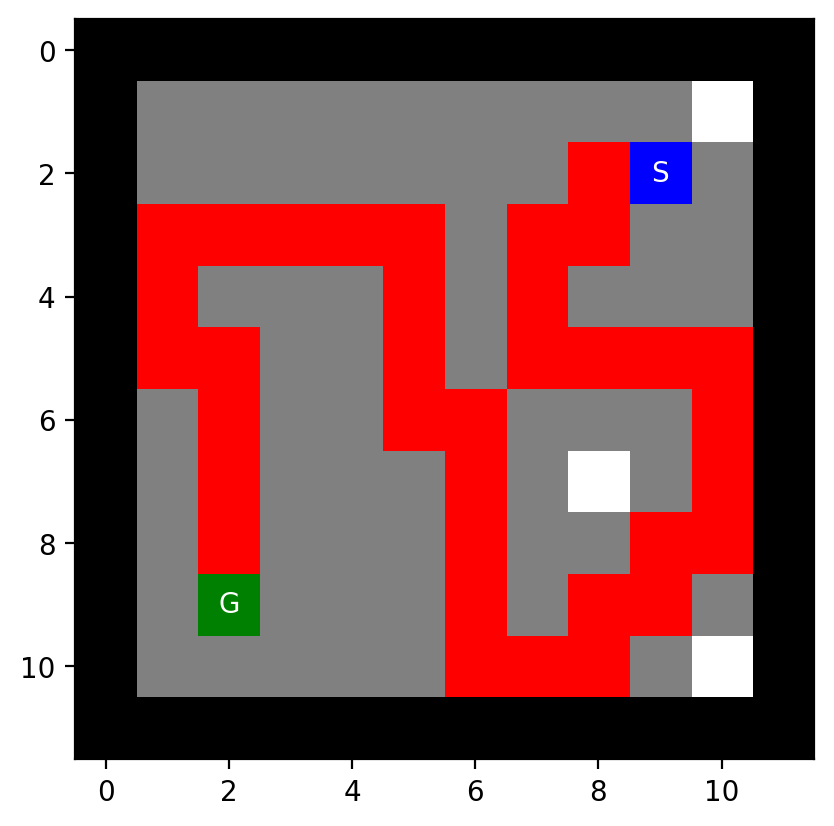

Path cost: 36
Number of nodes expanded: 97
Maximum size of the frontier: 41
Maximum Tree Depth: 45
this is File empty_2_maze.txt
 
Algorithm Name: IDS
Type of Maze: wall_maze.txt


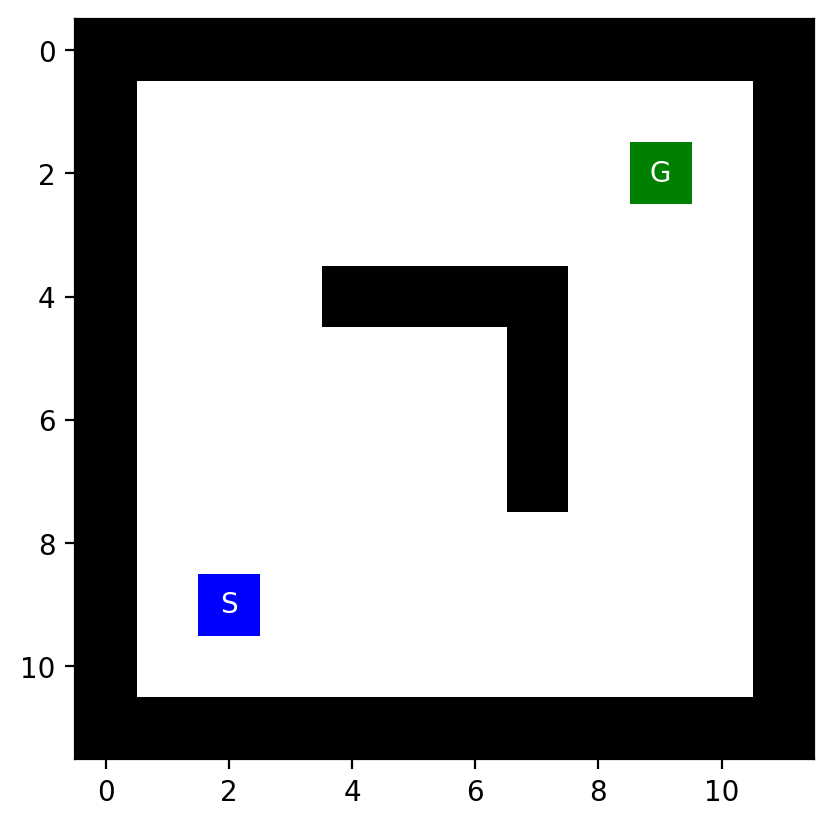

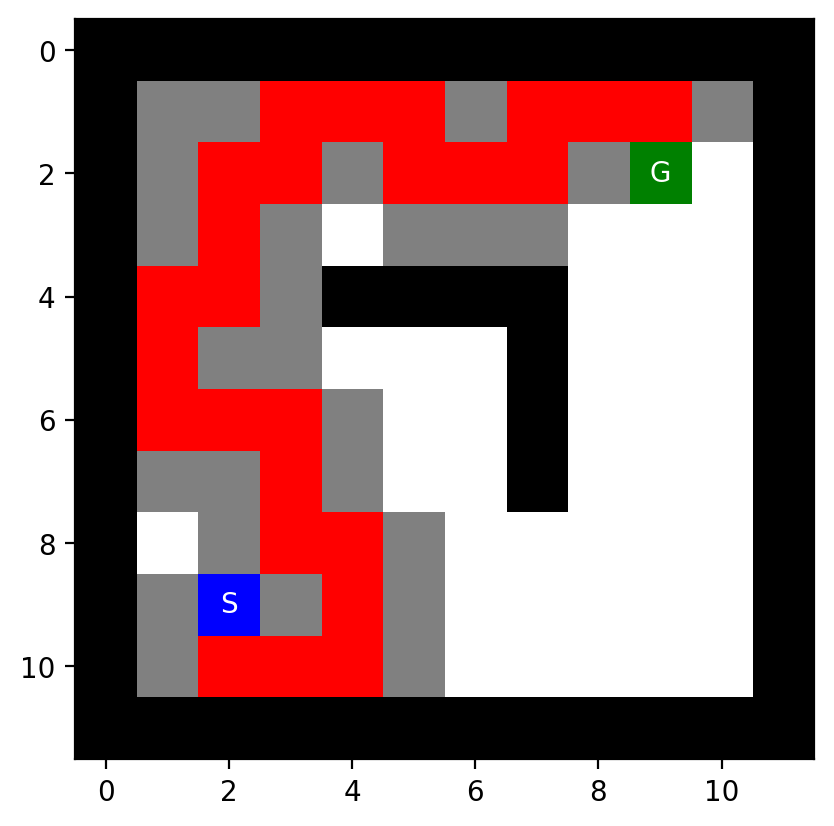

Path cost: 26
Number of nodes expanded: 53
Maximum size of the frontier: 25
Maximum Tree Depth: 26
this is File wall_maze.txt
 
Algorithm Name: IDS
Type of Maze: open_maze.txt


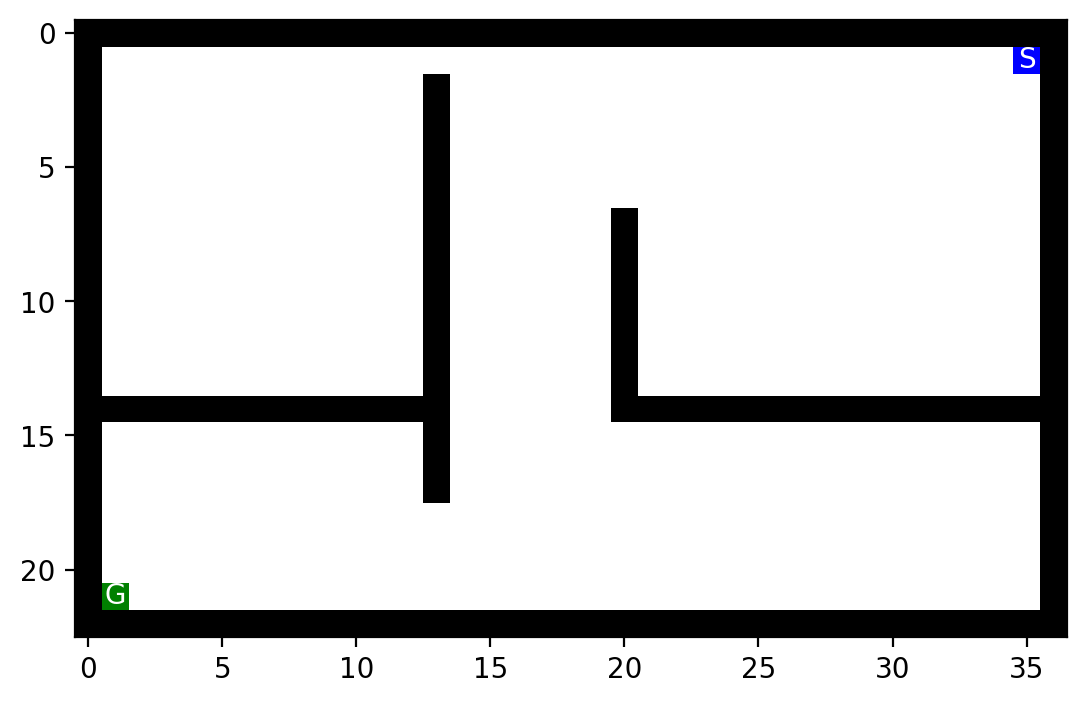

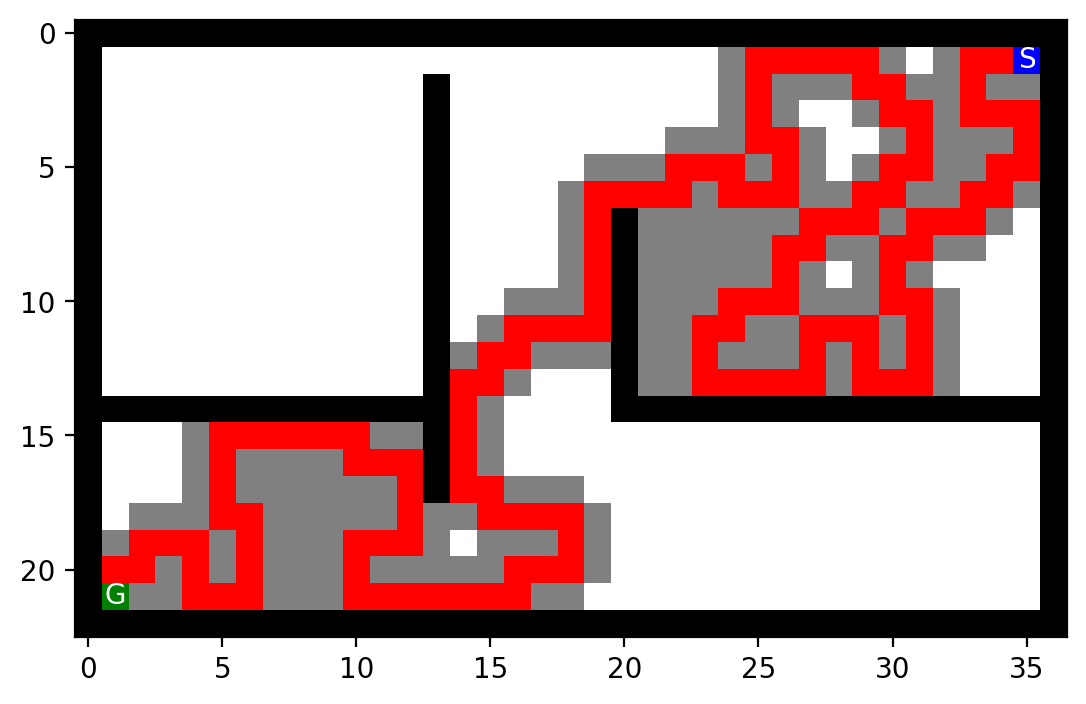

Path cost: 138
Number of nodes expanded: 299
Maximum size of the frontier: 135
Maximum Tree Depth: 138
this is File open_maze.txt
 
Algorithm Name: IDS
Type of Maze: loops_maze.txt


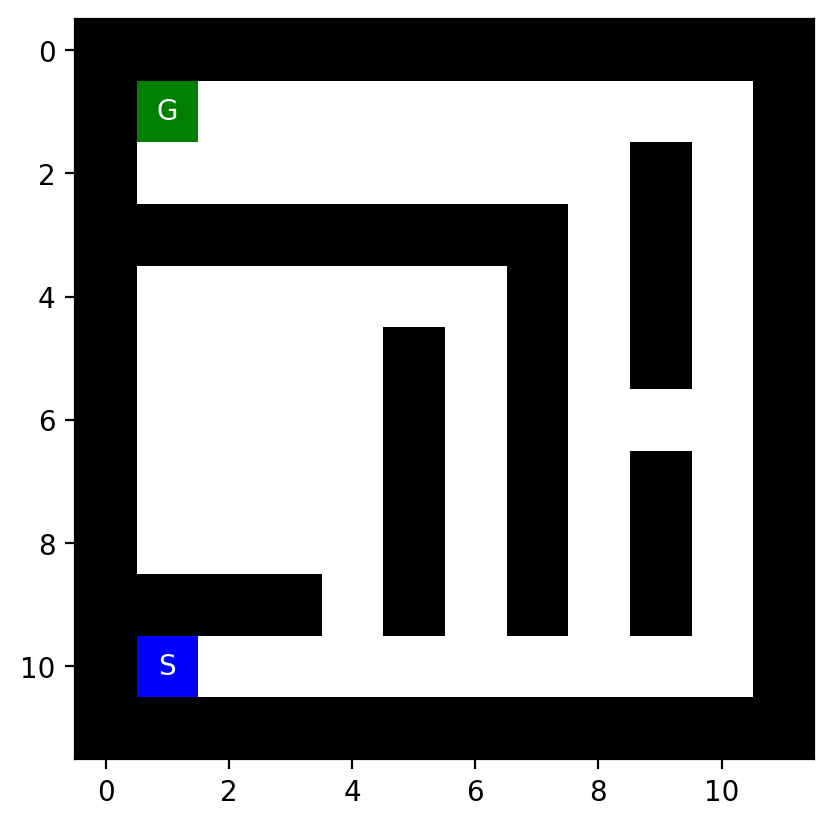

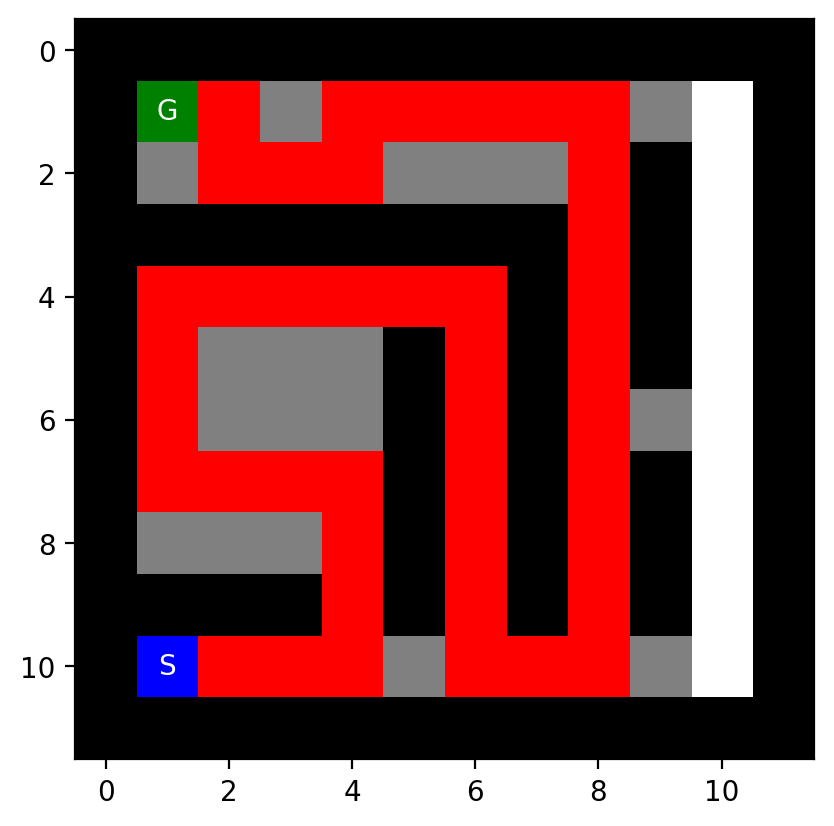

Path cost: 43
Number of nodes expanded: 62
Maximum size of the frontier: 16
Maximum Tree Depth: 43
this is File loops_maze.txt
 
Algorithm Name: IDS
Type of Maze: large_maze.txt


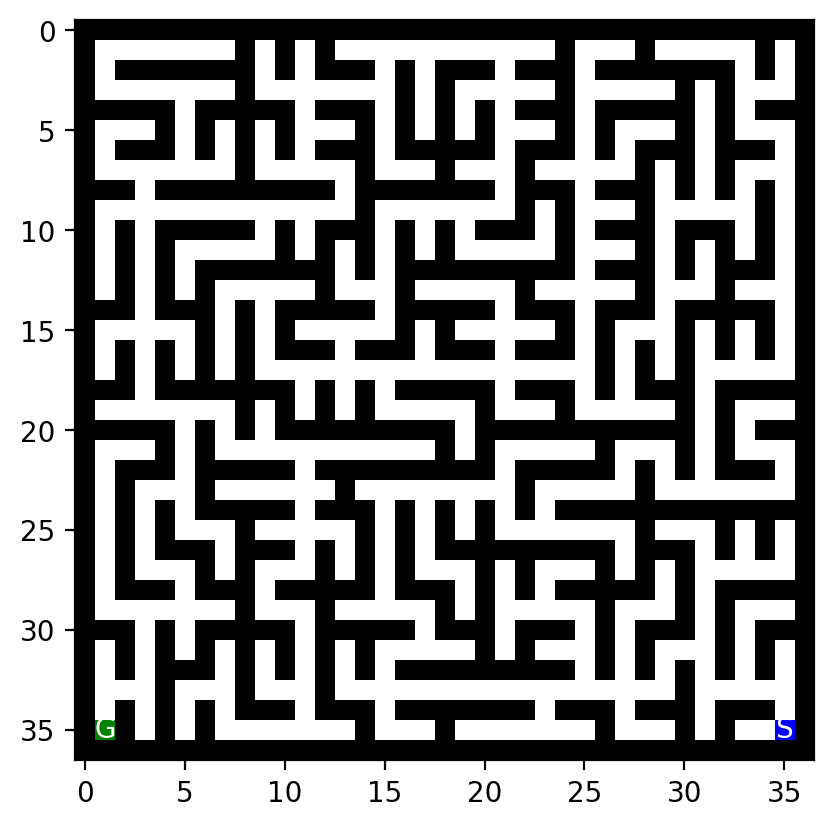

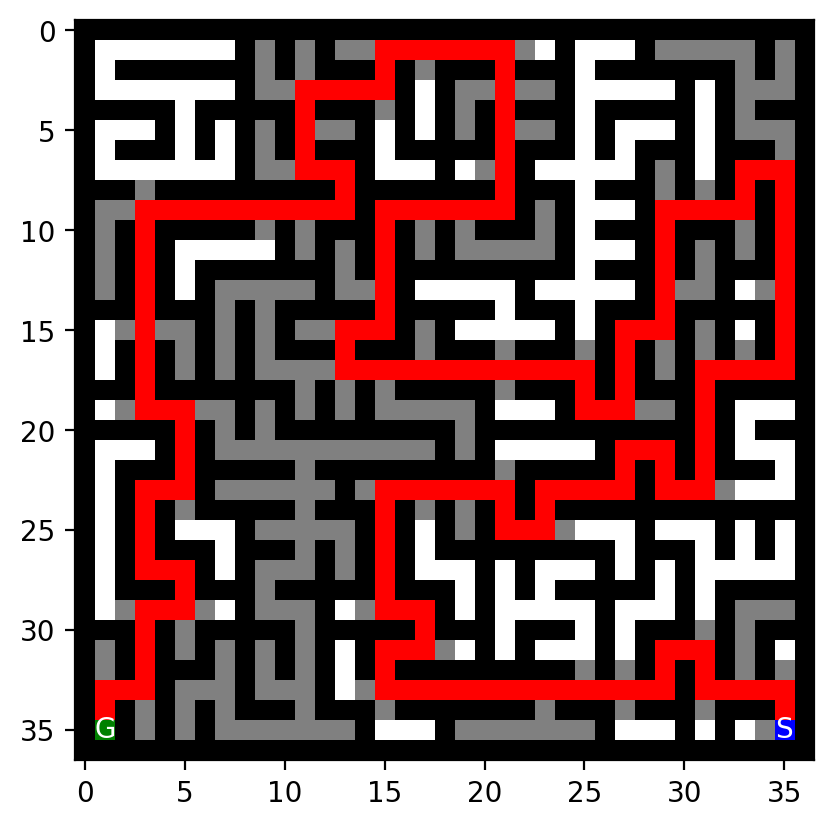

Path cost: 210
Number of nodes expanded: 439
Maximum size of the frontier: 36
Maximum Tree Depth: 223
this is File large_maze.txt


In [ ]:
files = []
AMweighted = np.zeros((30,5))
AEweighted = np.zeros((30,5) )
BFS = np.zeros((30,5))
DFS = np.zeros((30,5))
IDS = np.zeros((30,5))
GBFSM = np.zeros((30,5))
GBFSE = np.zeros((30,5))
AM = np.zeros((30,5))
AE = np.zeros((30,5))
for filename in glob.glob("*.txt"):
  if filename not in files:
    files.append(filename)



strategy = ["BFS","DFS", "GBFS-M", "GBFS-E", "A*-M", "A*-E", "A*-M-weighted","A*-E-weighted", "IDS"]
columns = ['Algorithm Name', 'Type of Maze', 'Path Cost', 'Nodes Expanded', 'Max Frontier Size', 'Max Tree Depth']
results_df = pd.DataFrame(columns=columns)
for k in strategy:
  for j in range(len(files)):
           f = open(files[j] , "r")
           max_memory_usage = 0
           maze_str = f.read()
           maze = mh.parse_maze(maze_str)
           print(" ")
           print("Algorithm Name:",k)
           print("Type of Maze:",files[j])
           mh.show_maze(maze)

           if k == "IDS":
            max_memory_usage = 0
            result = Itterative_DS(maze, max_limit=np.inf, debug = False,vis = False)
            show_path(maze, result["path"], result["reached"])
            print("Path cost:", len(result["path"]) - 1)
            print("Number of nodes expanded:", len(result["reached"]))
            print("Maximum size of the frontier:", int(max(max_frontier)))
            print("Maximum Tree Depth:", max(depth))
            IDS[j,0] = len(result["path"]) - 1
            IDS[j,1] = len(result["reached"])
            current_node_memory = len(result["path"]) + len(result["reached"])
            if current_node_memory > max_memory_usage:
              max_memory_usage = current_node_memory
            IDS[j,2] = int(max(max_frontier))
            IDS[j,3] = max(depth)
            IDS[j,4] = max_memory_usage

           else:
            result = TreeSearch(maze, strategy = k, debug = False, vis = False)
            show_path(maze, result["path"], result["reached"])

            if k == "BFS":
                  print("Path cost:", len(result["path"]) - 1)
                  print("Number of nodes expanded:", len(result["reached"]))
                  print("Maximum size of the frontier:",int(max(max_frontier)))
                  print("Maximum Tree Depth:", max(depth))
                  max_memory_usage = 0
                  current_node_memory = len(result["path"]) + len(result["reached"])
                  if current_node_memory > max_memory_usage:
                    max_memory_usage = current_node_memory

                  print("Maximum Number of Node in Memory:", max_memory_usage)
                  BFS[j,0] = len(result["path"]) - 1
                  BFS[j,1] = len(result["reached"])
                  BFS[j,2] = int(max(max_frontier))
                  BFS[j,3] = max(depth)
                  BFS[j,4] = max_memory_usage

            elif k == "DFS":


              print("Path cost:", len(result["path"]) - 1)
              print("Number of nodes expanded:", len(result["reached"]))
              print("Maximum size of the frontier:",int(max(max_frontier)))
              print("Maximum Tree Depth:", max(depth))
              max_memory_usage = 0
              current_node_memory = len(result["path"]) + len(result["reached"])
              if current_node_memory > max_memory_usage:
                max_memory_usage = current_node_memory
                print("Maximum Number of Node in Memory:", max_memory_usage)

              DFS[j,0] = len(result["path"]) - 1
              DFS[j,1] = len(result["reached"])
              DFS[j,2] = int(max(max_frontier))
              DFS[j,3] = max(depth)
              DFS[j,4] = max_memory_usage
              if current_node_memory > max_memory_usage:
                max_memory_usage = current_node_memory
                print("Maximum Number of Node in Memory:", max_memory_usage)

            elif k == "GBFS-M":
              print("Path cost:", len(result["path"]) - 1)
              print("Number of nodes expanded:", len(result["reached"]))
              print("Maximum size of the frontier:",int(max(max_frontier)))
              print("Maximum Tree Depth:", max(depth))
              ax_memory_usage = 0
              current_node_memory = len(result["path"]) + len(result["reached"])
              if current_node_memory > max_memory_usage:
                max_memory_usage = current_node_memory
                print("Maximum Number of Node in Memory:", max_memory_usage)
              GBFSM[j,0] = len(result["path"]) - 1
              GBFSM[j,1] = len(result["reached"])
              GBFSM[j,2] = int(max(max_frontier))
              GBFSM[j,3] = max(depth)
              GBFSM[j,4] = max_memory_usage


            elif k == "GBFS-E":
              print("Path cost:", len(result["path"]) - 1)
              print("Number of nodes expanded:", len(result["reached"]))
              print("Maximum size of the frontier:",int(max(max_frontier)))
              print("Maximum Tree Depth:", max(depth))
              max_memory_usage = 0
              current_node_memory = len(result["path"]) + len(result["reached"])
              if current_node_memory > max_memory_usage:
                  max_memory_usage = current_node_memory
                  print("Maximum Number of Node in Memory:", max_memory_usage)
              GBFSE[j,0] = len(result["path"]) - 1
              GBFSE[j,1] = len(result["reached"])
              GBFSE[j,2] = int(max(max_frontier))
              GBFSE[j,3] = max(depth)
              GBFSM[j,4] = max_memory_usage
            elif k == "A*-M":
                print("Path cost:", len(result["path"]) - 1)
                print("Number of nodes expanded:", len(result["reached"]))
                print("Maximum size of the frontier:",int(max(max_frontier)))
                print("Maximum Tree Depth:", max(depth))
                max_memory_usage = 0
                current_node_memory = len(result["path"]) + len(result["reached"])
                if current_node_memory > max_memory_usage:
                  max_memory_usage = current_node_memory
                  print("Maximum Number of Node in Memory:", max_memory_usage)
                AM[j,0] = len(result["path"]) - 1
                AM[j,1] = len(result["reached"])
                AM[j,2] = int(max(max_frontier))
                AM[j,3] = max(depth)
                AM[j,4] = max_memory_usage

            elif k == "A*-E":
                print("Path cost:", len(result["path"]) - 1)
                print("Number of nodes expanded:", len(result["reached"]))
                print("Maximum size of the frontier:",int(max(max_frontier)))
                print("Maximum Tree Depth:", max(depth))
                max_memory_usage = 0
                current_node_memory = len(result["path"]) + len(result["reached"])
                if current_node_memory > max_memory_usage:
                  max_memory_usage = current_node_memory
                  print("Maximum Number of Node in Memory:", max_memory_usage)
                AE[j,0] = len(result["path"]) - 1
                AE[j,1] = len(result["reached"])
                AE[j,2] = int(max(max_frontier))
                AE[j,3] = max(depth)
                AE[j,4] = max_memory_usage

            elif k == "A*-M-weighted":
              print("Path cost:", len(result["path"]) - 1)
              print("Number of nodes expanded:", len(result["reached"]))
              print("Maximum size of the frontier:",(max(max_frontier)))
              print("Maximum Tree Depth:", max(depth))
              max_memory_usage = 0
              current_node_memory = len(result["path"]) + len(result["reached"])
              if current_node_memory > max_memory_usage:
                 max_memory_usage = current_node_memory
                 print("Maximum Number of Node in Memory:", max_memory_usage)
              AEweighted[j,0] = len(result["path"]) - 1
              AEweighted[j,1] = len(result["reached"])
              AEweighted[j,2] = int(max(max_frontier))
              AEweighted[j,3] = max(depth)
              AEweighted[j,4] = max_memory_usage

           print("this is File", files[j])

  #  print(results_df)










How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

BFS explores the graph level by level, starting from the root node. It expands all nodes at a given depth before moving to the nodes at the next depth level.

Handling Loops: Without a reached data structure, BFS can get stuck in loops. If a node leads back to a previously visited node, BFS will re-queue this node and potentially explore it again, causing the algorithm to potentially explore the same path multiple times without ever terminating. This can lead to infinite loops in the search process if there's a cycle in the graph.

DFS explores as far as possible along each branch before backtracking. It uses a stack (implicitly through recursion or explicitly) to keep track of the path it's exploring

Handling Loops: Similar to BFS, without a mechanism to mark nodes as visited, DFS can repeatedly visit the same nodes, following cycles in the graph indefinitely. Since DFS goes deep into the graph, it might explore a looping path numerous times, consuming resources and potentially never finding a path to the goal if a loop leads away from it.

Both BFS and DFS can become highly inefficient without a reached data structure because they may explore the same paths multiple times. This can lead to exponential time complexity in the presence of loops, making the search impractical for large graphs.


## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?


1.   BFS  Complete and If all step costs are equal. tc = O(bd) sc = O(bd)
2.   UCS.  Yes complete and optimal tc = Number of Node g(n) <C* sc = [g(n) <C*]
3.   DFS    not complete nor optima. tc = O(bm) sc = O(bm)
4.   IDS    yes If all step costs are equal tc = O(bd) sc = O(bd)
5.   Greedy not complete nor optimal  tc = O(bd).  sc = O(bd)
6.   A*    is complete and optimal tc = g(n)+h(n) <C*  sc = [g(n)+h(n) <C*]


Are your implementations complete and optimal? What is the time and space complexity?

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In order to prevent rewriting coded, and while the explanation of implementation for algorithms have overlaps with each other, I will explain all of the tasks together and provide the code for all of the them afterward.ready explained. Then, it assigns starting point to the root of the tree.The most important list would be frontier and reached which the frontier includes the available nodes that the agent can take and the reached shows the squares that the agent have already passed.Finally, the code runs as long as the length of frontier is not less than 1 which means it runs as long as there is a frontier to take. Then, for each method/algorithms, the agent makes different decision. The algorithms and assumption are made based on the course textbook and the guidance of Professor Hahsler. After making decision according to the algorithms chosen, all of the data will store or some data will generate. For instance, in each iteration, the next node of the tree will created and attached to the root.As performance metrics, or in other words, for representing the performance of each algo- rithm, I have reported and presented four different values in order to help for comparison among methods to choose the best method for solving the related maze. The four differen values are path cost, number of nodes expanded, maximum size of the frontier, and maximum tree depth.
Besides, each algorithms has some advantageous and disadvantageous that I am going to show in a table by providing information about their time and space complexity and discussing wheather they are complete and optimal or not.
finally, I have implemented the bonus part of this assignment in this section but I will explain later.
In general, while I am working in finite mazes and spaces, and according to the results, my algorithms always find a solution for the maze, I would say all of the implementations are com- plete but not all of the are optimal because DFS and Greedy methods are not optimal while they return the first solution they find

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       | 14          |   98              |     11           |         15      |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

#Medium Maze


BFS       68     273.    8    69    

DFS       74     274     8     226

GBS       74.    82      4      74

A-star    14     82.     35     14

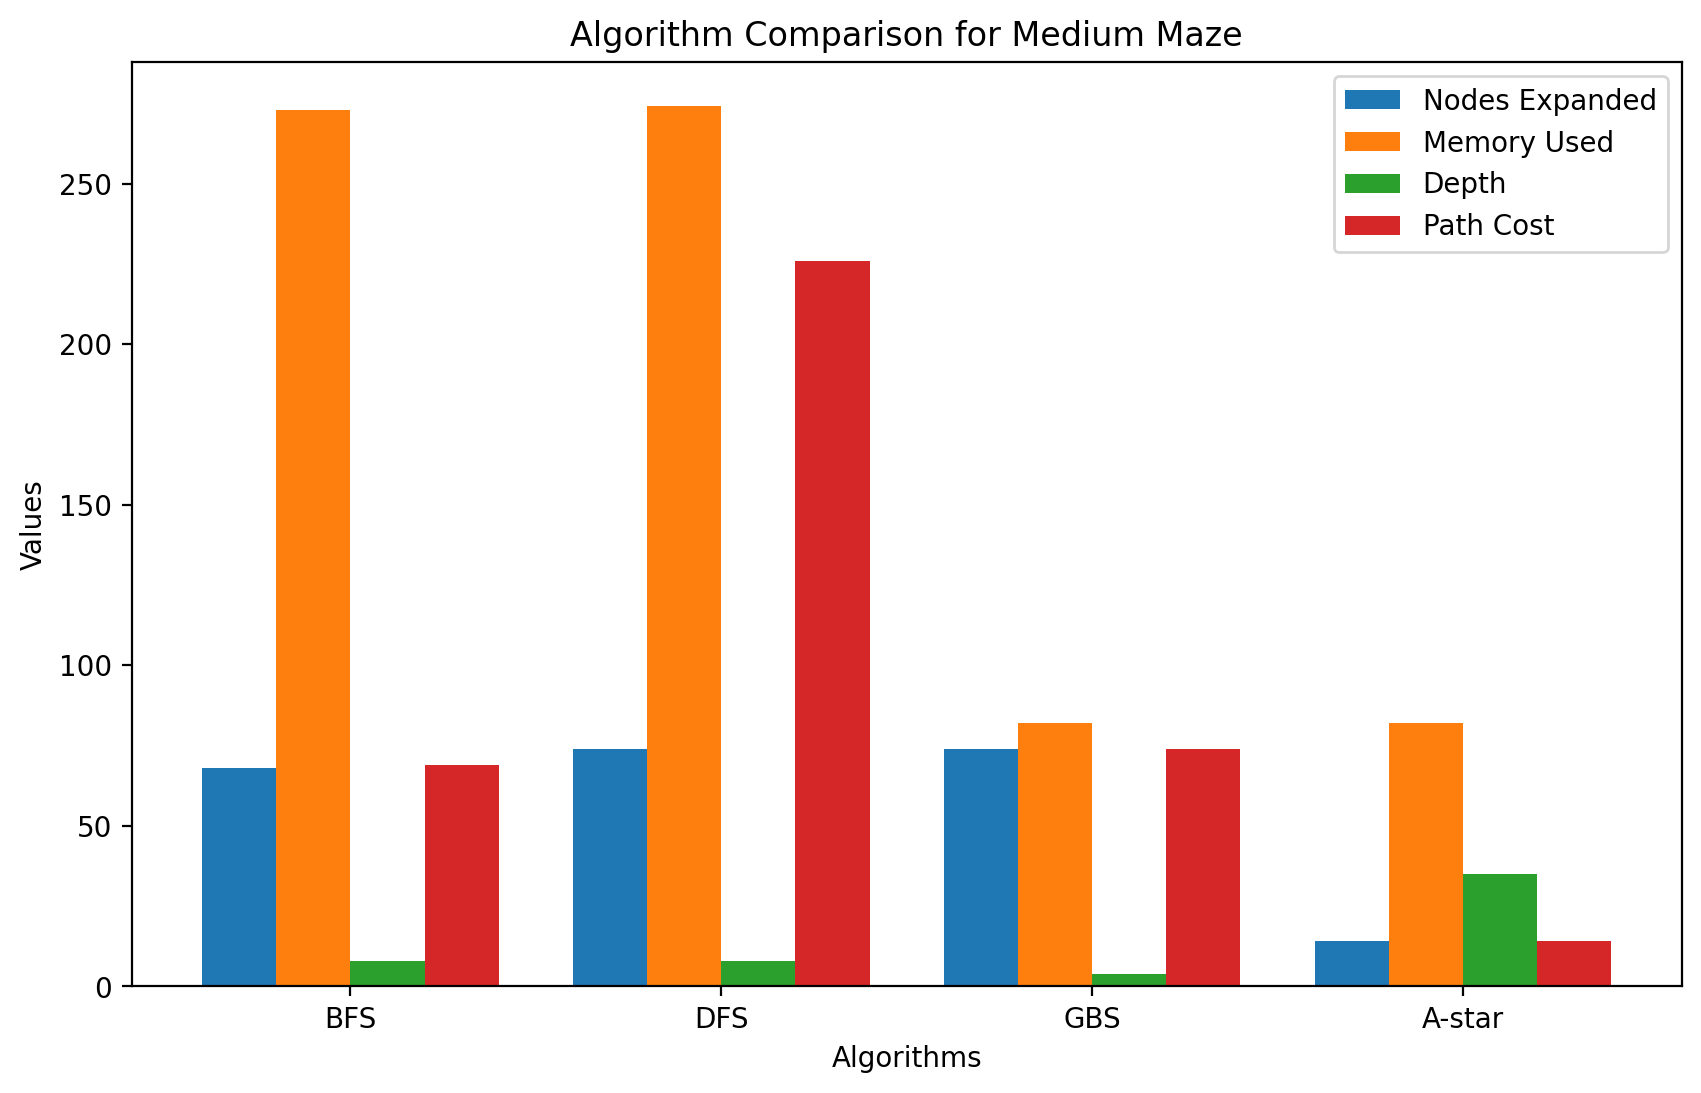

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [68, 74, 74, 14]
memory_used = [273, 274, 82, 82]
depth = [8, 8, 4, 35]
path_cost = [69, 226, 74, 14]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison for Medium Maze')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

# Empty Maze


BFS       14     98.    11    15    

DFS       24     78     37     33

GBS       14.    36      22     14

A-star    14     82.     35     14

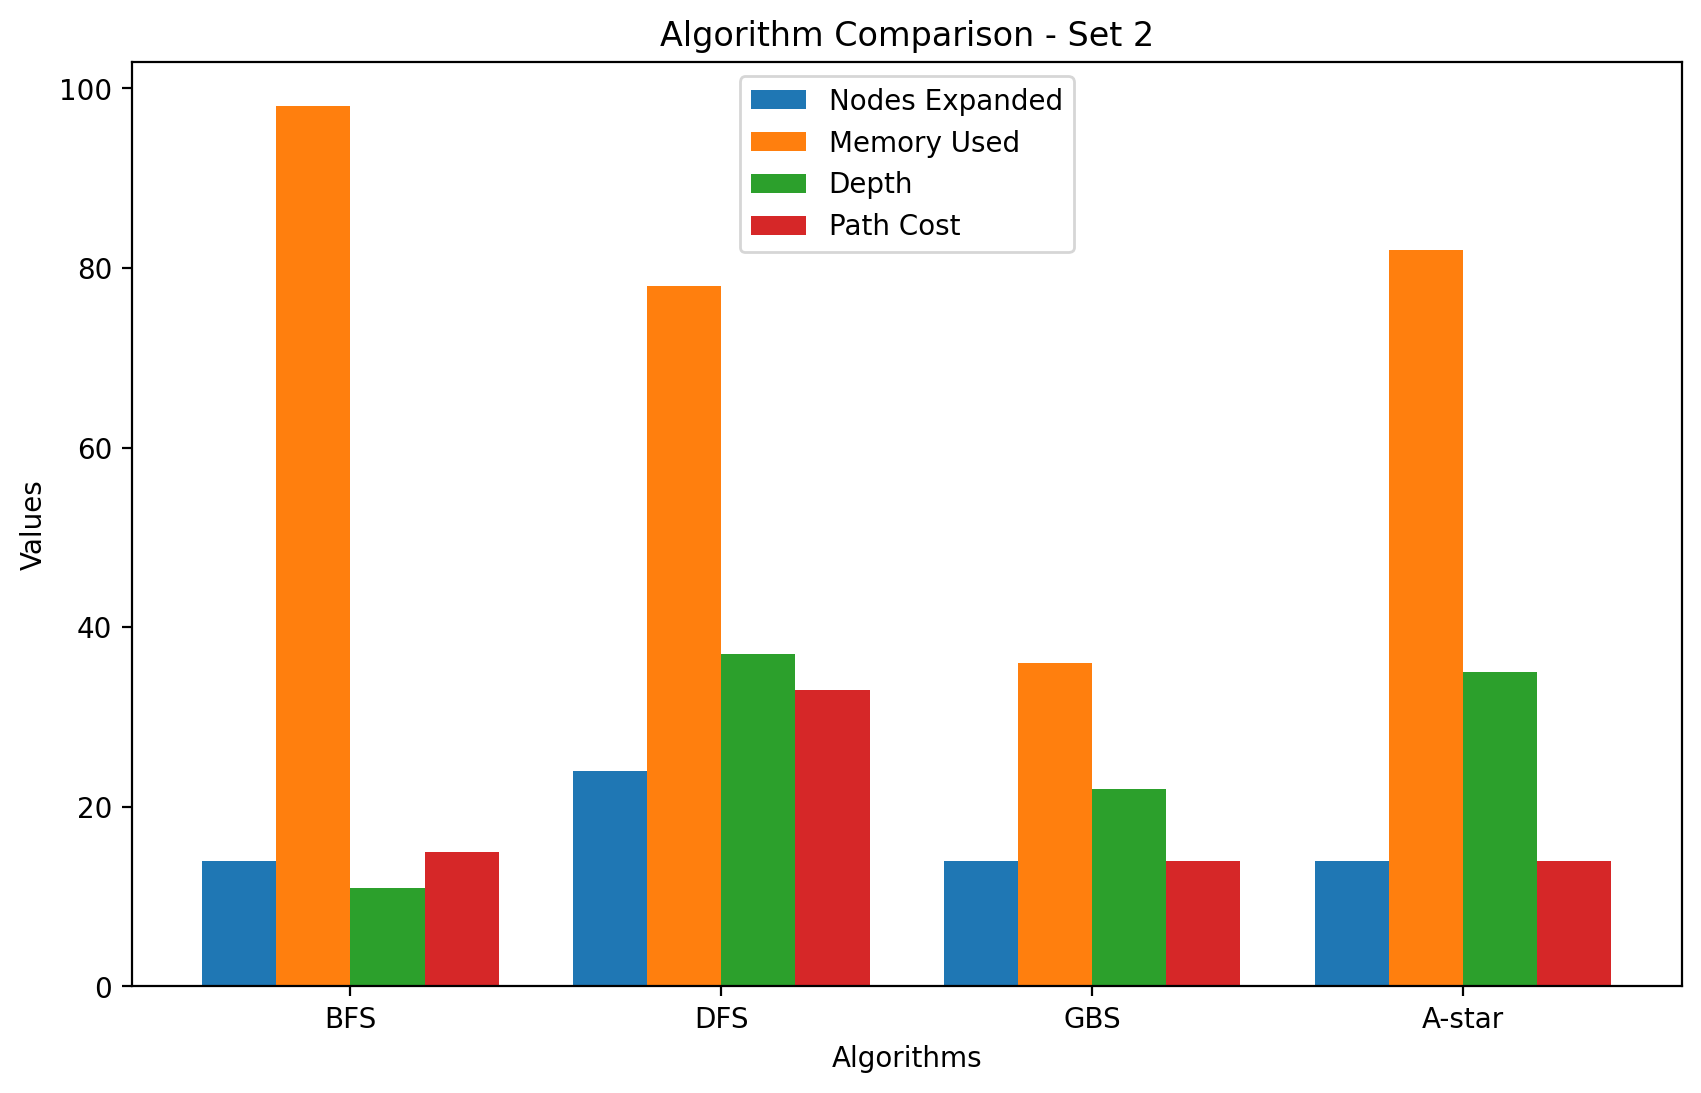

In [ ]:


# Data
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [14, 24, 14, 14]
memory_used = [98, 78, 36, 82]
depth = [11, 37, 22, 35]
path_cost = [15, 33, 14, 14]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison For Empty size')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

# Loops Maze


BFS       23     72.    8    23    

DFS       25     62     10     26

GBS       23.    61      11     23

A-star    23     61.     9     23


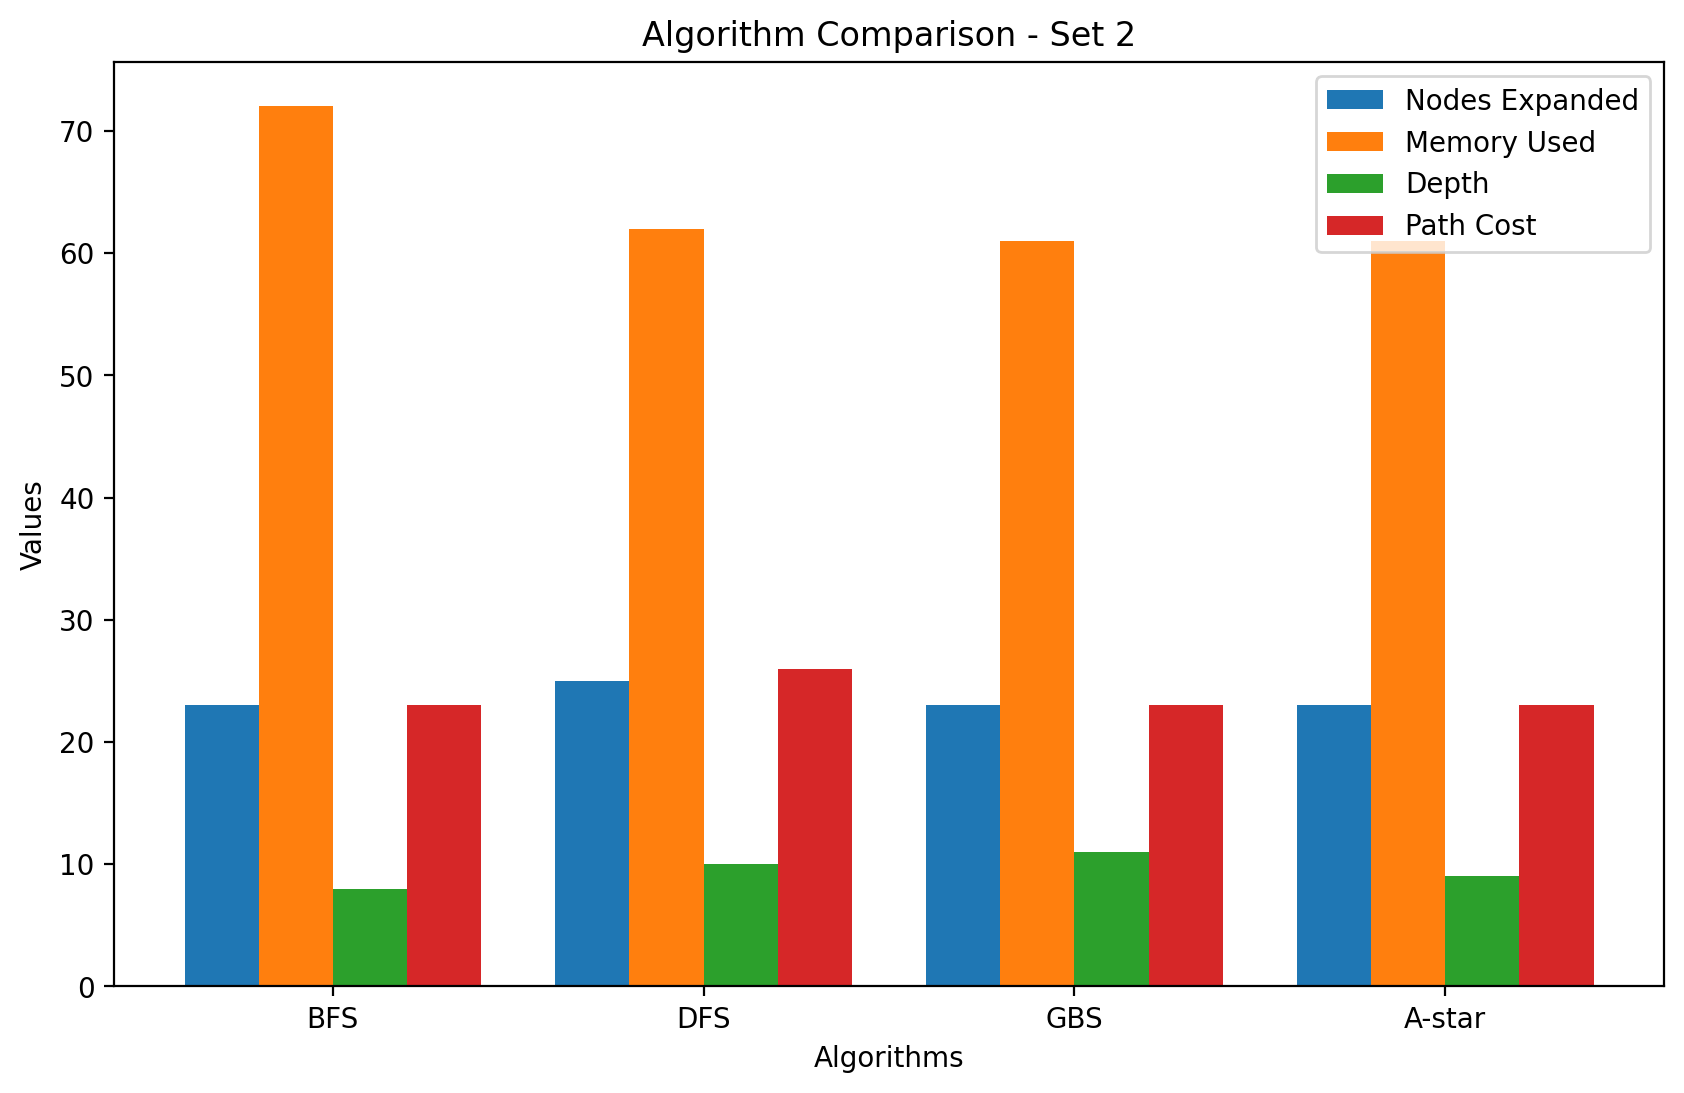

In [ ]:
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [23, 25, 23, 23]
memory_used = [72, 62, 61, 61]
depth = [8, 10, 11, 9]
path_cost = [23, 26, 23, 23]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison for loop maze')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies.

# Large Maze


BFS       210     626.    8    211    

DFS       210     400     32     215

GBS       210.    485      23     210

A-star    210     557.     12     210



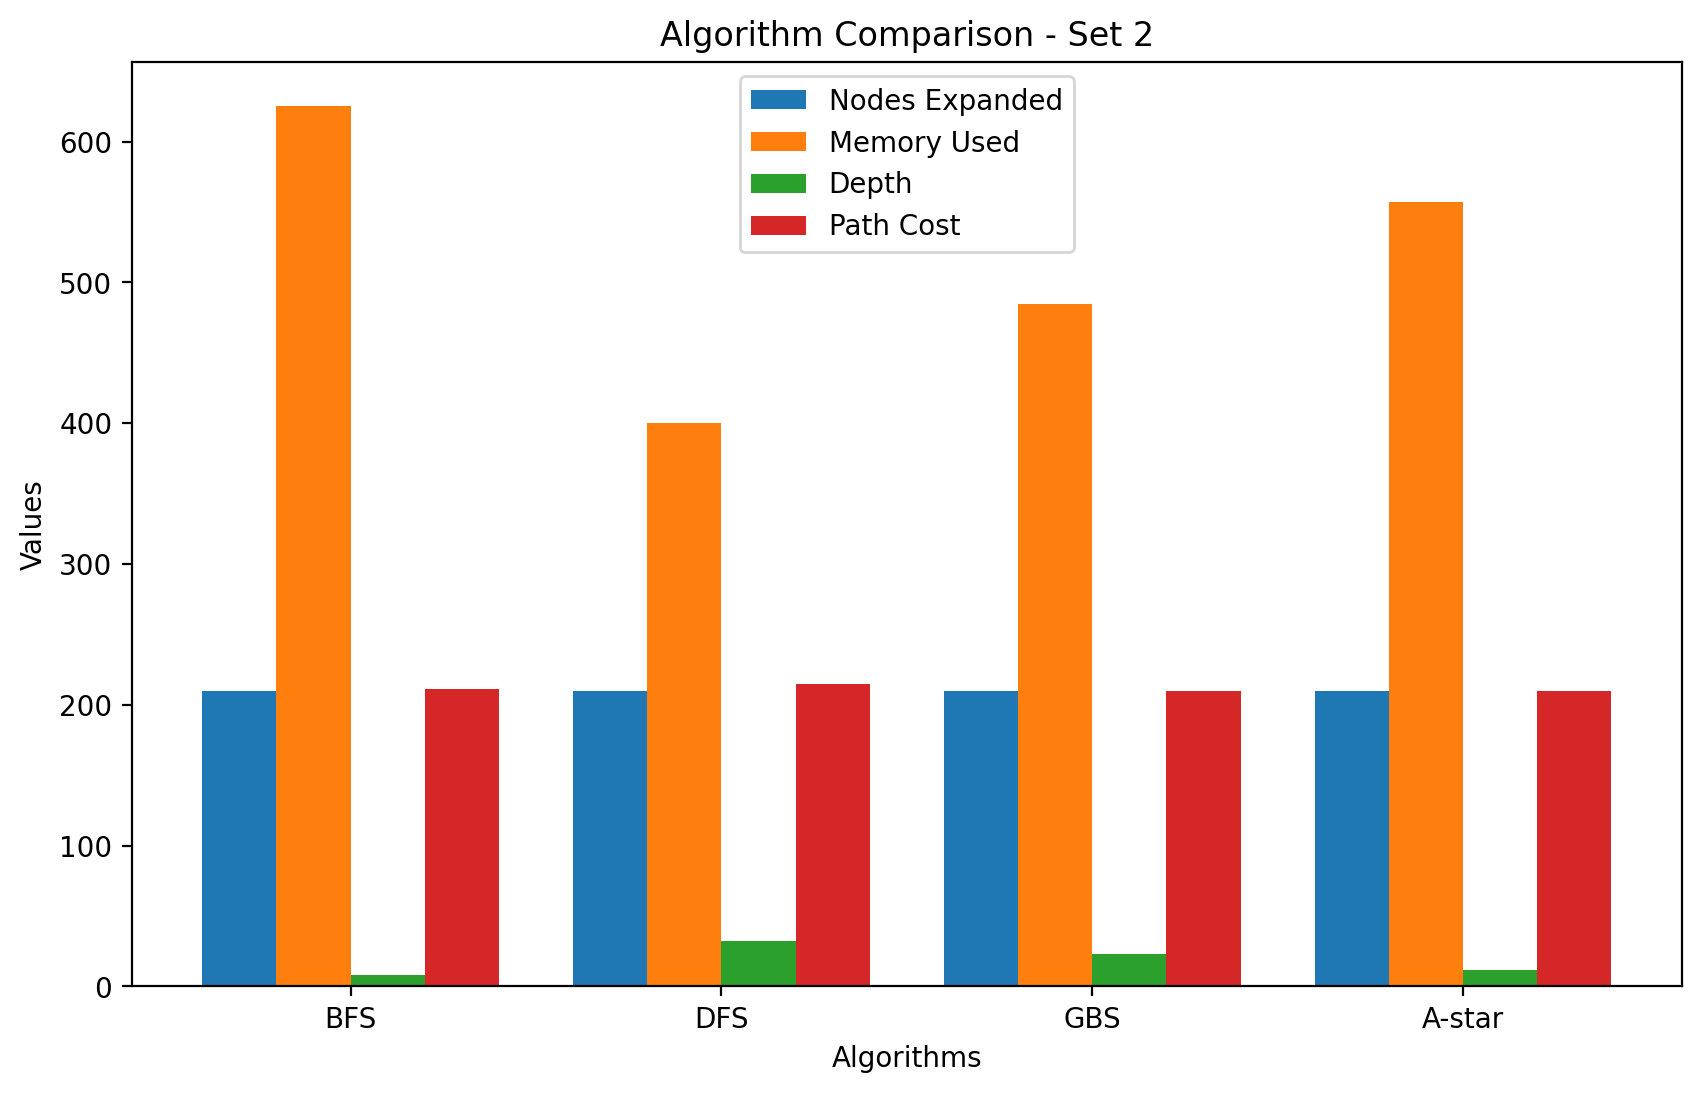

In [ ]:
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [210, 210, 210, 210]
memory_used = [625, 400, 485, 557]
depth = [8, 32, 23, 12]
path_cost = [211, 215, 210, 210]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison for large maze')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

# Open Maze


BFS       54     684.    25    54    

DFS       54     570     28     160

GBS       62    155      77     62

A-star    54     361.     69     54



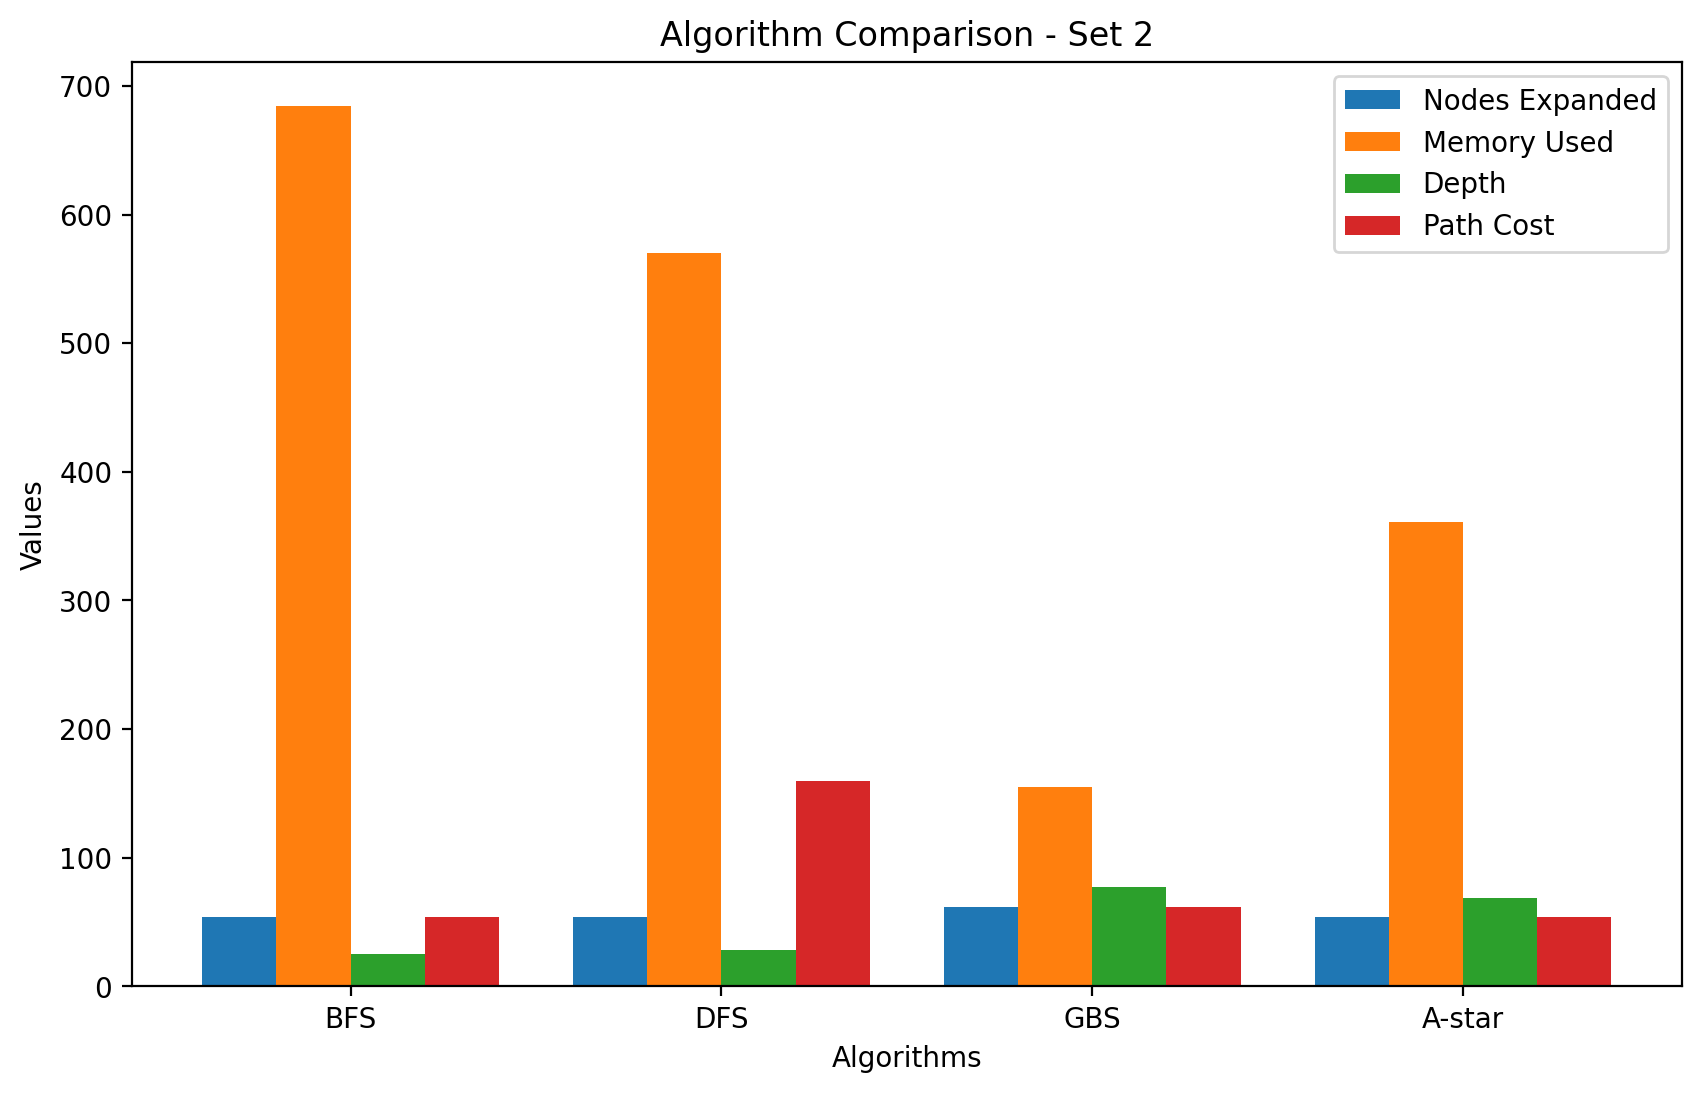

In [ ]:
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [54, 54, 62, 54]
memory_used = [684, 570, 155, 361]
depth = [25, 28, 77, 69]
path_cost = [54, 160, 62, 54]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison open maze')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

# simple Maze


BFS       19     94.    9    20    

DFS       37     70     6     37

GBS       29    44      5     29

A-star    19     59.     7     19

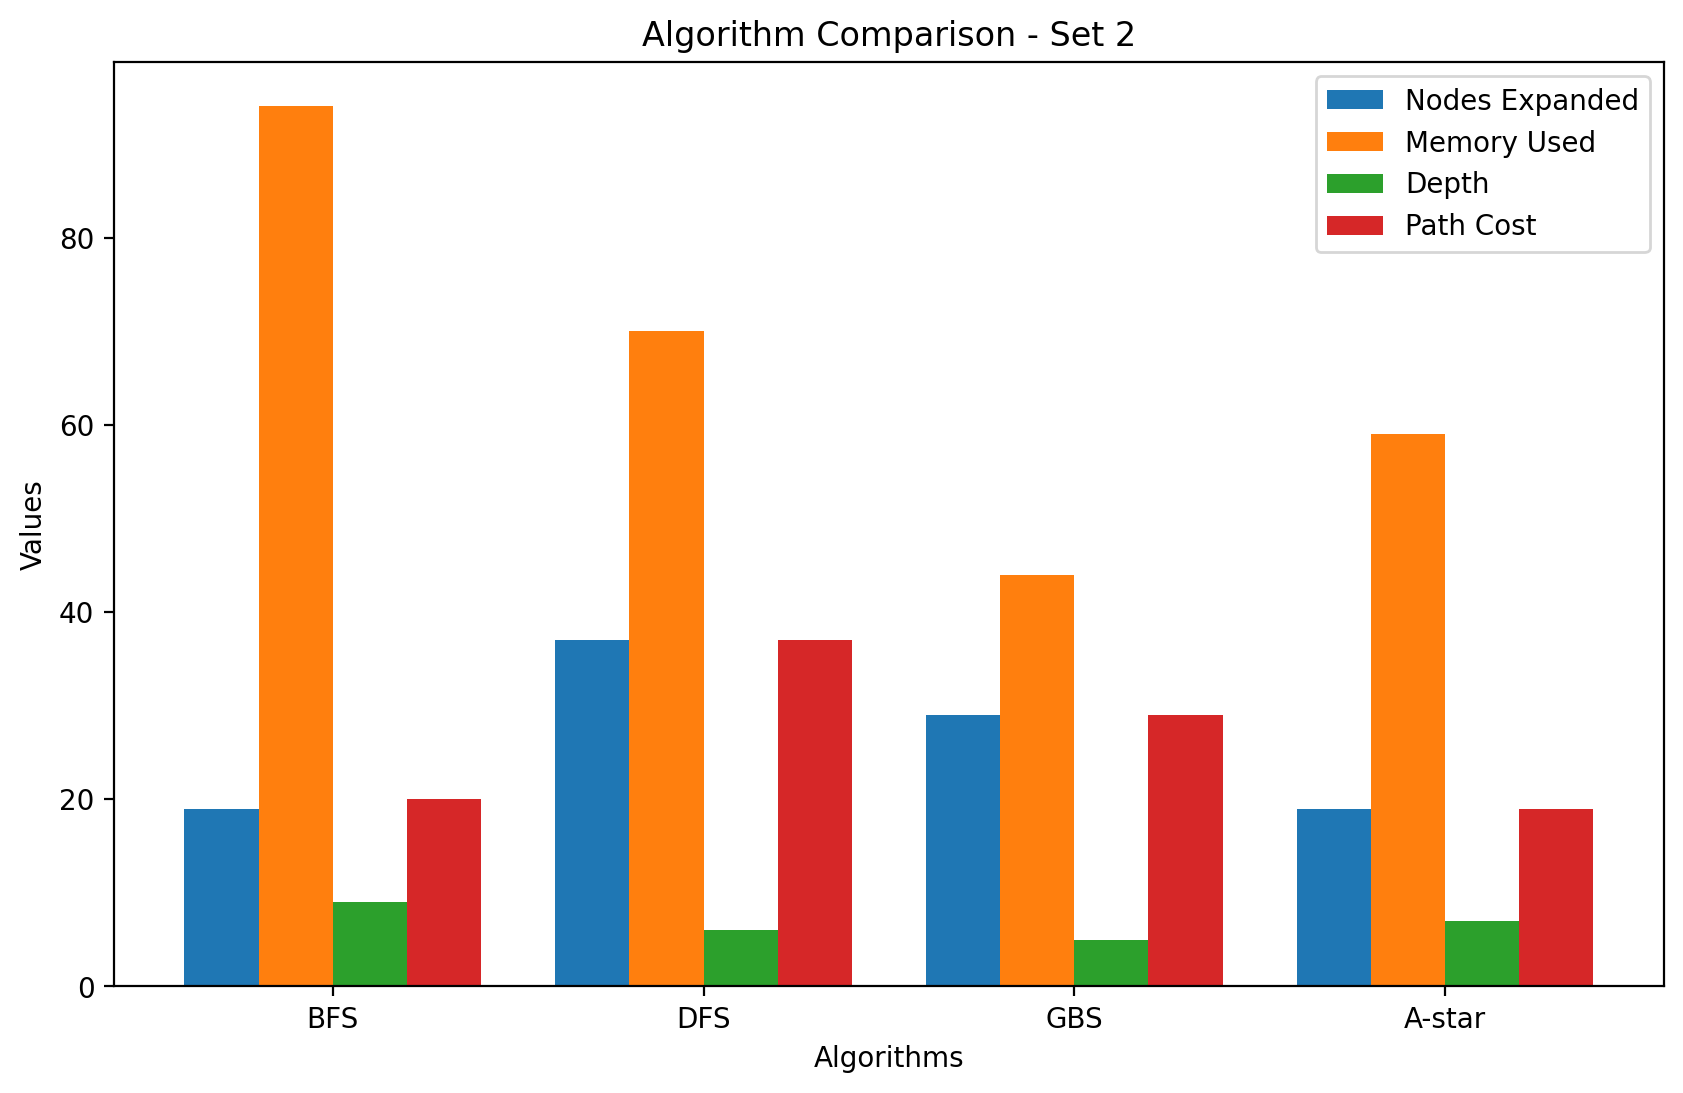

In [ ]:
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [19, 37, 29, 19]
memory_used = [94, 70, 44, 59]
depth = [9, 6, 5, 7]
path_cost = [20, 37, 29, 19]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison - for simple maze')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

# Wall Maze
BFS       14     91.    10    15    

DFS       37     70     6     37

GBS       29    44      5     29

A-star    19     59.     7     19

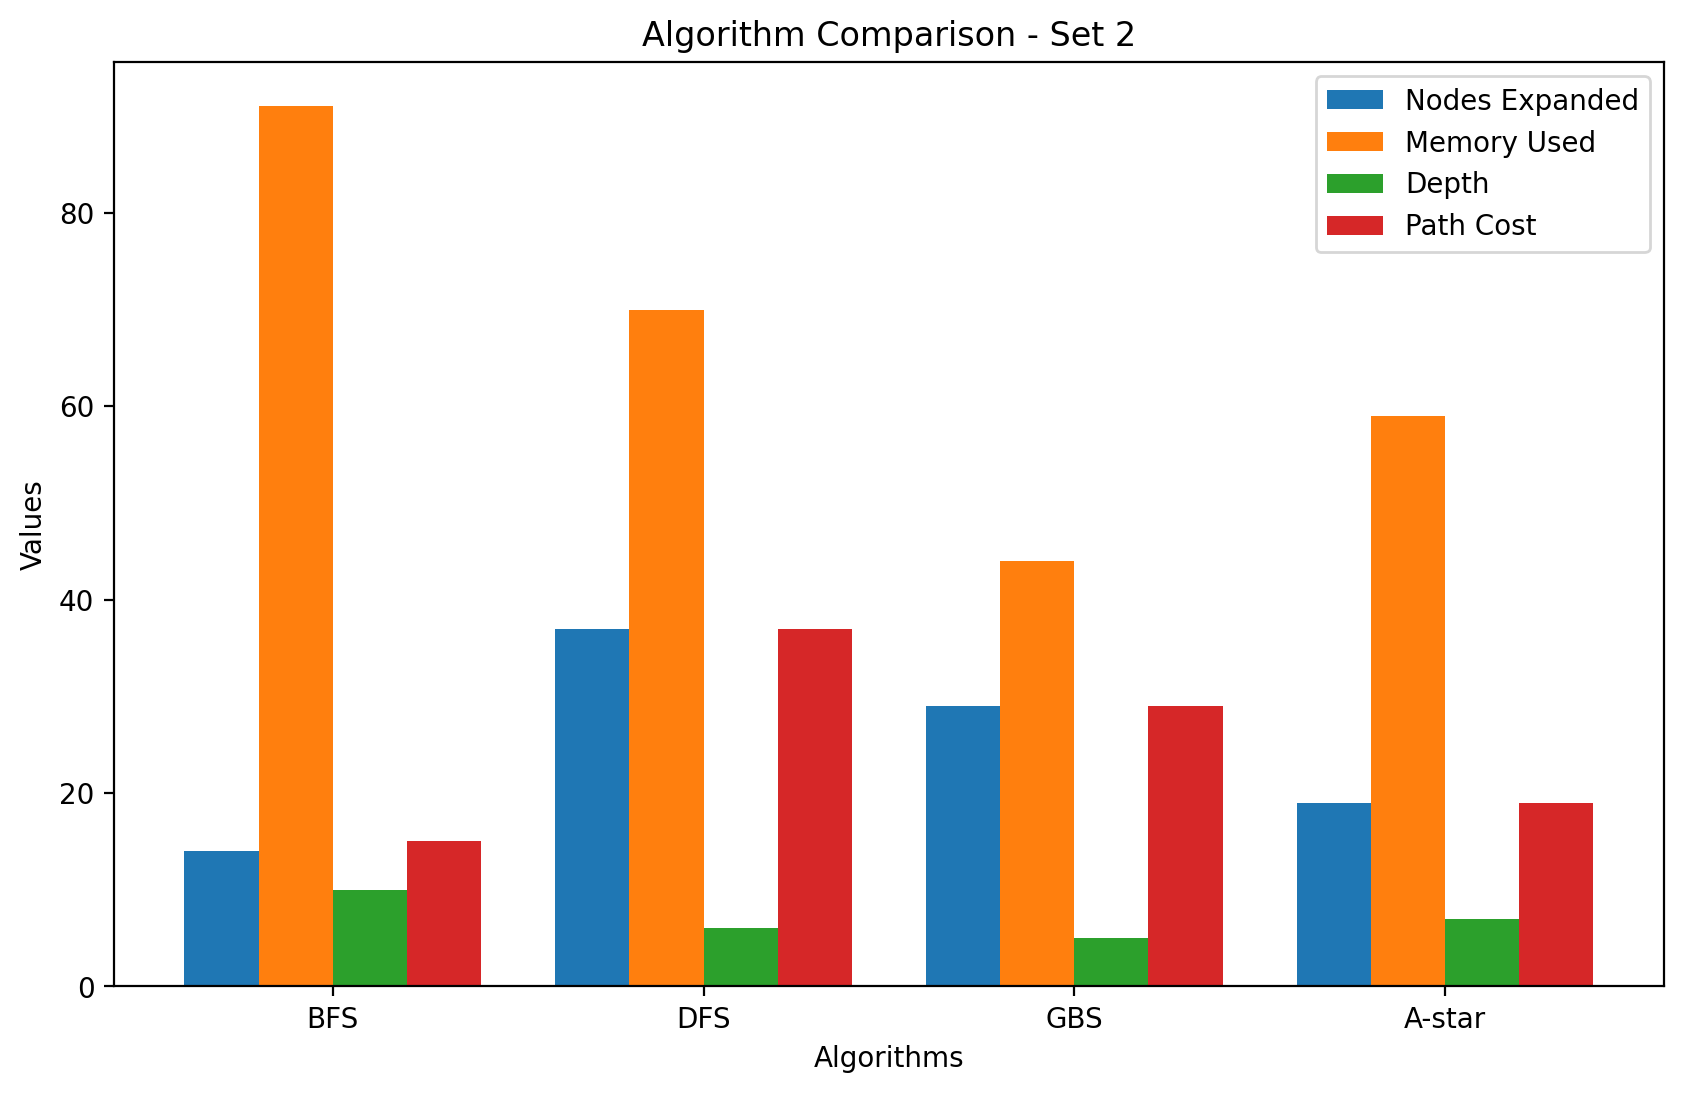

In [ ]:
algorithms = ['BFS', 'DFS', 'GBS', 'A-star']
nodes_expanded = [14, 37, 29, 19]
memory_used = [91, 70, 44, 59]
depth = [10, 6, 5, 7]
path_cost = [15, 37, 29, 19]

# Setting the positions and width for the bars
pos = np.arange(len(algorithms))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(pos - width*1.5, nodes_expanded, width, label='Nodes Expanded')
plt.bar(pos - width/2, memory_used, width, label='Memory Used')
plt.bar(pos + width/2, depth, width, label='Depth')
plt.bar(pos + width*1.5, path_cost, width, label='Path Cost')

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(algorithms)
plt.xlabel('Algorithms')
plt.ylabel('Values')
plt.title('Algorithm Comparison - wall maze')

# Adding a legend
plt.legend()

# Display the chart
plt.show()

## More advanced tasks to think about

### Intersection as states
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [ ]:
result = TreeSearch(maze, strategy = "BFS", debug = False, vis = False)
print("Path cost:", len(result["path"]) - 1)
print("Number of nodes expanded:", len(result["reached"]))
print("Maximum size of the frontier:", int(max(max_frontier)))
print("Total Number of Intersections:", len(pos_intersection) )
print("The Furthest Intersection from the root:", max(depth_Intersections))
print("The Closest Intersection from the root:", min(depth_Intersections))


Path cost: 210
Number of nodes expanded: 626
Maximum size of the frontier: 9


### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

Path cost: 210
Number of nodes expanded: 537
Maximum size of the frontier: 13
Maximum Tree Depth: 210


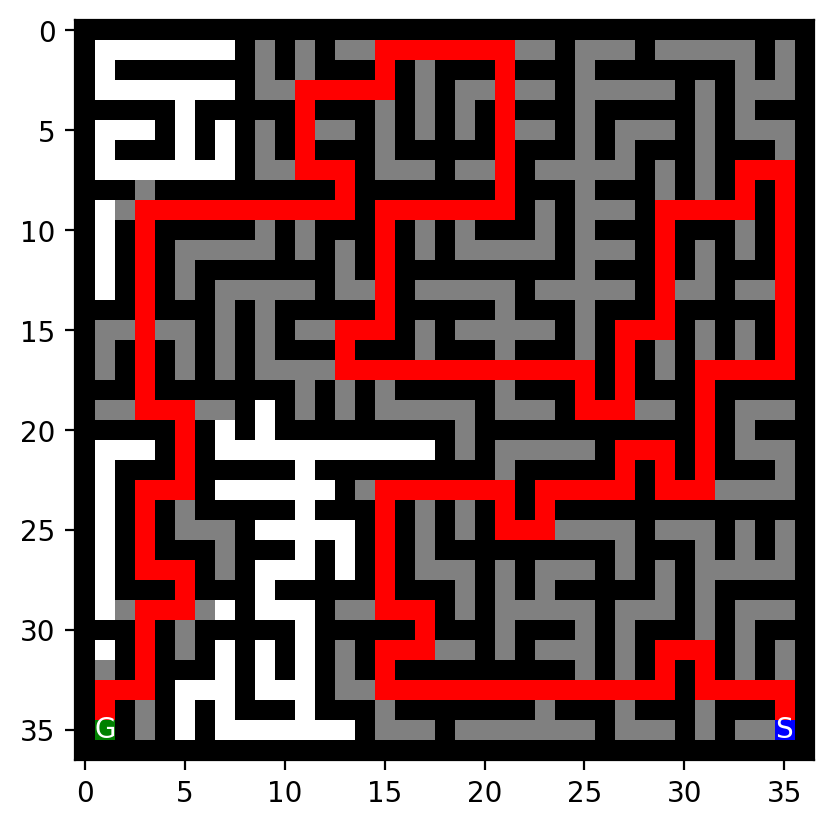

In [ ]:
result = TreeSearch(maze, strategy = "A*-E-weighted", debug = False, vis =False)
print("Path cost:", len(result["path"]) - 1)
print("Number of nodes expanded:", len(result["reached"]))
print("Maximum size of the frontier:", int(max(max_frontier)))
print("Maximum Tree Depth:", max(depth))
show_path(maze, result["path"], result["reached"])

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?


When an agent does not know the layout of the maze in advance, it means it's navigating an unknown environment. The environment's dynamics, or the transition function, which describes the outcome of actions taken by the agent in the environment, are unknown to the agent. This significantly complicates the task of navigating the maze efficiently.



For such a scenario, the PEAS (Performance measure, Environment, Actuators, Sensors) description would look something like this:

Performance Measure: The agent's performance could be measured by several factors, including the time it takes to reach the goal, the length of the path taken, and possibly the amount of information it has gathered about the environment.
Environment: The maze itself, with its paths, walls, and potentially dynamic changes. The environment is initially unknown to the agent, and it might only discover the layout by moving through it.
Actuators: The agent can move in different directions within the maze. The specific actions available might include moving forward, turning left, turning right, and possibly other actions depending on the maze's complexity.
Sensors: The agent has sensors to perceive its immediate surroundings, such as whether the path ahead or to the sides is blocked. If the agent has a GPS device, it can also sense the distance to the goal, although it might not know the direction explicitly.


    def solve_maze(self, start, goal):
        # The frontier is a priority queue that sorts nodes by their total cost.
        frontier = PriorityQueue()
        frontier.put(Node(start, heuristic=self.maze.heuristic(start)))
        explored = set()

        while not frontier.empty():
            node = frontier.get()
            if node.state == goal:
                return self.reconstruct_path(node)

            explored.add(node.state)
            for child in node.expand(self.maze):
                if child.state not in explored and child not in frontier.elements:
                    frontier.put(child)
                elif child in frontier.elements and frontier.elements[child] > child.total_cost:
                    frontier.replace(child)

        return None

    def reconstruct_path(self, node):
        path = []
        while node.parent is not None:
            path.append(node.action)
            node = node.parent
        path.reverse()
        return path
